In [1]:
import os
os.chdir('../../')
!ls

food_trade


In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import dask.dataframe as dd
from skimpy import skim, generate_test_data
import matplotlib.pyplot as plt
import seaborn as sns
from food_trade.demand_supply.balance_trade import get_area_codes
from food_trade.flow_prediction.get_all_features import get_trade_data, get_admin_reductions, get_transport_data, merge_data

sns.set()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, GammaRegressor, LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold, cross_validate, cross_val_predict, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score, matthews_corrcoef, f1_score, mean_squared_error, root_mean_squared_error, r2_score, roc_auc_score, precision_score, recall_score
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif, SelectKBest
from sklearn.decomposition import PCA

import networkx as nx
from node2vec import Node2Vec as n2v

import statsmodels.api as sm

/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/762496006.py:4: DeprecationWarning: The current Dask DataFrame implementation is deprecated. 
In a future release, Dask DataFrame will use a new implementation that
contains several improvements including a logical query planning.
The user-facing DataFrame API will remain unchanged.

The new implementation is already available and can be enabled by
installing the dask-expr library:

    $ pip install dask-expr

and turning the query planning option on:

    >>> import dask
    >>> dask.config.set({'dataframe.query-planning': True})
    >>> import dask.dataframe as dd

API documentation for the new implementation is available at
https://docs.dask.org/en/stable/dask-expr-api.html

Any feedback can be reported on the Dask issue tracker
https://github.com/dask/dask/issues 

To disable this warning in the future, set dask config:

    # via Python
    >>> dask.config.set({'dataframe.query-planning-warning': False})

    # via 

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from scikeras.wrappers import KerasRegressor
from tensorflow.keras import backend as K

2024-03-12 22:03:38.588415: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/shruti/anaconda3/envs/dphil1/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
df_country_log_false = pd.read_parquet('../../data/combined_features/df_country_log_false_thresh_1.parquet.gzip')
df_country_log_true = pd.read_parquet('../../data/combined_features/df_country_log_true_thresh_1.parquet.gzip')

cols = ['freight_USD_t', 'transport_USD_t', 'time_h',
       'distance_km', 'border_USD_t', 'customs_cost',
       'Pref_Applied_AVE', 'supply_Wheat', 'trade_Wheat',
       'supply_Maize (corn)', 'trade_Maize (corn)', 'supply_Rye', 'trade_Rye',
       'supply_Barley', 'trade_Barley', 'supply_Oats', 'trade_Oats',
       'supply_Sorghum', 'trade_Sorghum', 'supply_Rice, paddy (rice milled equivalent)',
       'trade_Rice, paddy (rice milled equivalent)', 'supply_Buckwheat', 'trade_Buckwheat',
       'supply_Millet', 'trade_Millet', 'supply_Quinoa', 'trade_Quinoa',
       'supply_Cereals n.e.c.', 'trade_Cereals n.e.c.', 
       'supply_cereals_all', 'trade_cereals_all', 'from_barley_area',
       'from_maize_area', 'from_millet_area', 'from_rice_area',
       'from_sorghum_area', 'from_wheat_area', 'from_other_cereals_area',
       'from_barley_production', 'from_maize_production',
       'from_millet_production', 'from_rice_production',
       'from_sorghum_production', 'from_wheat_production',
       'from_other_cereals_production', 'from_buffaloes', 'from_cattle',
       'from_chickens', 'from_ducks', 'from_goats', 'from_horses', 'from_pigs',
       'from_sheep', 'from_pop', 'from_gdp', 'from_area', 'from_built_surface',
       'from_built_volume_total', 'from_built_volume_nres', 'to_barley_area', 'to_maize_area',
       'to_millet_area', 'to_rice_area', 'to_sorghum_area', 'to_wheat_area',
       'to_other_cereals_area', 'to_barley_production', 'to_maize_production',
       'to_millet_production', 'to_rice_production', 'to_sorghum_production',
       'to_wheat_production', 'to_other_cereals_production', 'to_buffaloes',
       'to_cattle', 'to_chickens', 'to_ducks', 'to_goats', 'to_horses',
       'to_pigs', 'to_sheep', 'to_pop', 'to_gdp', 'to_area', 'to_built_surface',
       'to_built_volume_total', 'to_built_volume_nres']

log_cols = [i+'_log' for i in cols]

df_country = df_country_log_false.merge(df_country_log_true.rename(columns=dict(zip(cols, log_cols))))

In [5]:
print(df_country.shape)
df_country.head()

(37830, 203)


,from_iso3,to_iso3,freight_USD_t,transport_USD_t,time_h,distance_km,border_USD_t,customs_cost,mode,Pref_Applied_AVE,supply_Wheat,supply_Wheat_exists,trade_Wheat,trade_Wheat_exists,supply_Maize (corn),supply_Maize (corn)_exists,trade_Maize (corn),trade_Maize (corn)_exists,supply_Rye,supply_Rye_exists,trade_Rye,trade_Rye_exists,supply_Barley,supply_Barley_exists,trade_Barley,trade_Barley_exists,supply_Oats,supply_Oats_exists,trade_Oats,trade_Oats_exists,supply_Sorghum,supply_Sorghum_exists,trade_Sorghum,trade_Sorghum_exists,"supply_Rice, paddy (rice milled equivalent)","supply_Rice, paddy (rice milled equivalent)_exists","trade_Rice, paddy (rice milled equivalent)","trade_Rice, paddy (rice milled equivalent)_exists",supply_Buckwheat,supply_Buckwheat_exists,trade_Buckwheat,trade_Buckwheat_exists,supply_Millet,supply_Millet_exists,trade_Millet,trade_Millet_exists,supply_Quinoa,supply_Quinoa_exists,trade_Quinoa,trade_Quinoa_exists,supply_Cereals n.e.c.,supply_Cereals n.e.c._exists,trade_Cereals n.e.c.,trade_Cereals n.e.c._exists,supply_cereals_all,supply_cereals_all_exists,trade_cereals_all,trade_cereals_all_exists,from_barley_area,from_maize_area,from_millet_area,from_rice_area,from_sorghum_area,from_wheat_area,from_other_cereals_area,from_barley_production,from_maize_production,from_millet_production,from_rice_production,from_sorghum_production,from_wheat_production,from_other_cereals_production,from_buffaloes,from_cattle,from_chickens,from_ducks,from_goats,from_horses,from_pigs,from_sheep,from_pop,from_gdp,from_area,from_built_surface,from_built_volume_total,from_built_volume_nres,to_barley_area,to_maize_area,to_millet_area,to_rice_area,to_sorghum_area,to_wheat_area,to_other_cereals_area,to_barley_production,to_maize_production,to_millet_production,to_rice_production,to_sorghum_production,to_wheat_production,to_other_cereals_production,to_buffaloes,to_cattle,to_chickens,to_ducks,to_goats,to_horses,to_pigs,to_sheep,to_pop,to_gdp,to_area,to_built_surface,to_built_volume_total,to_built_volume_nres,from_region,to_region,freight_USD_t_log,transport_USD_t_log,time_h_log,distance_km_log,border_USD_t_log,customs_cost_log,Pref_Applied_AVE_log,supply_Wheat_log,trade_Wheat_log,supply_Maize (corn)_log,trade_Maize (corn)_log,supply_Rye_log,trade_Rye_log,supply_Barley_log,trade_Barley_log,supply_Oats_log,trade_Oats_log,supply_Sorghum_log,trade_Sorghum_log,"supply_Rice, paddy (rice milled equivalent)_log","trade_Rice, paddy (rice milled equivalent)_log",supply_Buckwheat_log,trade_Buckwheat_log,supply_Millet_log,trade_Millet_log,supply_Quinoa_log,trade_Quinoa_log,supply_Cereals n.e.c._log,trade_Cereals n.e.c._log,supply_cereals_all_log,trade_cereals_all_log,from_barley_area_log,from_maize_area_log,from_millet_area_log,from_rice_area_log,from_sorghum_area_log,from_wheat_area_log,from_other_cereals_area_log,from_barley_production_log,from_maize_production_log,from_millet_production_log,from_rice_production_log,from_sorghum_production_log,from_wheat_production_log,from_other_cereals_production_log,from_buffaloes_log,from_cattle_log,from_chickens_log,from_ducks_log,from_goats_log,from_horses_log,from_pigs_log,from_sheep_log,from_pop_log,from_gdp_log,from_area_log,from_built_surface_log,from_built_volume_total_log,from_built_volume_nres_log,to_barley_area_log,to_maize_area_log,to_millet_area_log,to_rice_area_log,to_sorghum_area_log,to_wheat_area_log,to_other_cereals_area_log,to_barley_production_log,to_maize_production_log,to_millet_production_log,to_rice_production_log,to_sorghum_production_log,to_wheat_production_log,to_other_cereals_production_log,to_buffaloes_log,to_cattle_log,to_chickens_log,to_ducks_log,to_goats_log,to_horses_log,to_pigs_log,to_sheep_log,to_pop_log,to_gdp_log,to_area_log,to_built_surface_log,to_built_volume_total_log,to_built_volume_nres_log
0,AFG,AGO,444.296266,192.935305,918.541029,14556.684483,60.583106,47.280295,0,21.061530,0.000000,0,0.0,0,0.000000,0,0.00,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,0,

In [6]:
len(df_country)

37830

In [7]:
df_admin_log_false = pd.read_parquet('../../data/combined_features/df_admin_log_false.parquet.gzip')
df_admin_log_true = pd.read_parquet('../../data/combined_features/df_admin_log_true.parquet.gzip')
df_admin = df_admin_log_false.merge(df_admin_log_true.rename(columns=dict(zip(cols, log_cols))))
df_admin = df_admin[(df_admin['from_id']!='NZL.10_1')].reset_index(drop=True)

In [8]:
# some error in domestic transport coding
df_admin.loc[df_admin['to_id']=='PAK.1_1', 'to_iso3'] = 'PAK'

In [9]:
print(df_admin.shape)
df_admin.head()

(12412218, 133)


,from_id,to_id,from_iso3,to_iso3,transport_USD_t,time_h,distance_km,border_USD_t,mode,customs_cost,freight_USD_t,Pref_Applied_AVE,from_barley_area,from_maize_area,from_millet_area,from_rice_area,from_sorghum_area,from_wheat_area,from_other_cereals_area,from_barley_production,from_maize_production,from_millet_production,from_rice_production,from_sorghum_production,from_wheat_production,from_other_cereals_production,from_buffaloes,from_cattle,from_chickens,from_ducks,from_goats,from_horses,from_pigs,from_sheep,from_pop,from_gdp,from_area,from_built_surface,from_built_volume_total,from_built_volume_nres,to_barley_area,to_maize_area,to_millet_area,to_rice_area,to_sorghum_area,to_wheat_area,to_other_cereals_area,to_barley_production,to_maize_production,to_millet_production,to_rice_production,to_sorghum_production,to_wheat_production,to_other_cereals_production,to_buffaloes,to_cattle,to_chickens,to_ducks,to_goats,to_horses,to_pigs,to_sheep,to_pop,to_gdp,to_area,to_built_surface,to_built_volume_total,to_built_volume_nres,from_region,to_region,transport_USD_t_log,time_h_log,distance_km_log,border_USD_t_log,customs_cost_log,freight_USD_t_log,Pref_Applied_AVE_log,from_barley_area_log,from_maize_area_log,from_millet_area_log,from_rice_area_log,from_sorghum_area_log,from_wheat_area_log,from_other_cereals_area_log,from_barley_production_log,from_maize_production_log,from_millet_production_log,from_rice_production_log,from_sorghum_production_log,from_wheat_production_log,from_other_cereals_production_log,from_buffaloes_log,from_cattle_log,from_chickens_log,from_ducks_log,from_goats_log,from_horses_log,from_pigs_log,from_sheep_log,from_pop_log,from_gdp_log,from_area_log,from_built_surface_log,from_built_volume_total_log,from_built_volume_nres_log,to_barley_area_log,to_maize_area_log,to_millet_area_log,to_rice_area_log,to_sorghum_area_log,to_wheat_area_log,to_other_cereals_area_log,to_barley_production_log,to_maize_production_log,to_millet_production_log,to_rice_production_log,to_sorghum_production_log,to_wheat_production_log,to_other_cereals_production_log,to_buffaloes_log,to_cattle_log,to_chickens_log,to_ducks_log,to_goats_log,to_horses_log,to_pigs_log,to_sheep_log,to_pop_log,to_gdp_log,to_area_log,to_built_surface_log,to_built_volume_total_log,to_built_volume_nres_log
0,AFG.10_1,AFG.11_1,AFG,AFG,65.871122,32.236673,660.758969,0.0,2,0.0,NaN,0.0,6934.274985,102.405748,0.035555,390.331297,0.000000,52036.407607,0.0,2361.412641,141.040796,0.037473,556.115496,0.0,95590.298738,0.0,0.000000,61902.900576,232166.704982,746.614500,288203.433887,31486.979558,0.000000,6.381769e+05,8.050400e+05,7.303179e+07,3.648191e+10,1.129523e+06,2.910470e+06,62173.0,4637.789863,17213.23135,15.009542,14245.234876,0.0,97730.563728,0.0,2844.254148,21936.263041,40.666162,23151.07756,0.0,194558.900416,0.0,7.48708,261658.151795,760546.219912,82609.326611,617432.367539,2766.289817,0.0,907226.394831,1.020848e+06,4.338721e+08,5.851475e+10,1.506232e+07,6.342997e+07,587526.0,1.0,1.0,4.202767,3.503654,6.494901,0.0,0.0,NaN,0.0,8.844376,4.638661,0.034937,5.969555,0.000000,10.859718,0.0,7.767439,4.956114,0.036788,6.322773,0.0,11.467837,0.0,0.000000,11.033338,12.355215,6.616887,12.571425,10.357361,0.000000,13.366372,13.598648,18.106405,24.320082,13.937307,14.883825,11.037692,8.442209,9.753492,2.773185,9.564248,0.0,11.48998,0.0,7.953408,9.995942,3.729689,10.04984,0.0,12.178495,0.0,2.138545,12.474798,13.541793,11.32189,13.333326,7.925624,0.0,13.718148,13.836145,19.88826,24.792545,16.527707,17.965447,13.283677
1,AFG.12_1,AFG.11_1,AFG,AFG,61.912076,27.660536,615.555500,0.0,2,0.0,NaN,0.0,54845.608066,14827.198732,38.744888,29434.495218,0.000000,234167.684163,0.0,16539.531877,18682.418993,141.024230,47261.136587,0.0,419969.443709,0.0,0.146332,261854.272692,805683.148299,4876.279919,695646.933597,4626.009046,4.728567,1.119931e+06,2.427348e+06,1.996920e+09,5.469317e+10,4.356513e+07,2.179682e+08,3607863.0,4637.789863,17213.23135,15.009542,14245.234876,0.0,97730.563728,0.0,2844.254148,21936.

#### Totals - trade, production, consumption

In [10]:
df_country['supply_other_cereals'] = df_country['supply_Rye'] + df_country['supply_Oats'] + df_country['supply_Buckwheat'] \
+ df_country['supply_Quinoa'] + df_country['supply_Barley'] + df_country['supply_Sorghum'] \
+ df_country['supply_Millet'] + df_country['supply_Cereals n.e.c.']
df_country['supply_other_cereals_exists'] = 0
df_country.loc[df_country['supply_other_cereals']>=1, 'supply_other_cereals_exists'] = 1
df_country['supply_other_cereals_log'] = np.log(df_country['supply_other_cereals'] + 1)

df_country = df_country.rename(columns={
     'supply_Wheat': 'supply_wheat',
     'supply_Wheat_exists': 'supply_wheat_exists',
     'supply_Wheat_log': 'supply_wheat_log',
     'supply_Maize (corn)': 'supply_maize',
     'supply_Maize (corn)_exists': 'supply_maize_exists',
     'supply_Maize (corn)_log': 'supply_maize_log',
     'supply_Rice, paddy (rice milled equivalent)': 'supply_rice',
     'supply_Rice, paddy (rice milled equivalent)_exists': 'supply_rice_exists',
     'supply_Rice, paddy (rice milled equivalent)_log': 'supply_rice_log'
     })

In [11]:
def get_totals(crop):

    excl = ['COK', 'FRO', 'GLP', 'GUF', 'KIR', 'MTQ', 'REU', 'TKL']
    
    supply_2017 = pd.read_csv(f"../../data/FAO_re_export/supply_matrix_{crop}_2017.csv")
    supply_2018 = pd.read_csv(f"../../data/FAO_re_export/supply_matrix_{crop}_2018.csv")
    supply_2019 = pd.read_csv(f"../../data/FAO_re_export/supply_matrix_{crop}_2019.csv")
    supply_2020 = pd.read_csv(f"../../data/FAO_re_export/supply_matrix_{crop}_2020.csv")
    supply_2021 = pd.read_csv(f"../../data/FAO_re_export/supply_matrix_{crop}_2021.csv")
    
    supply = pd.concat([supply_2017, supply_2018, supply_2019, supply_2020, supply_2021]).groupby('iso3').mean().reset_index()
    
    # melt supply data 
    supply = supply.rename(columns={'iso3': 'from_iso3'})
    supply = supply.melt(id_vars=['from_iso3'], value_vars=supply['from_iso3'].values.tolist()).rename(columns={'variable': 'to_iso3', 'value': 'trade'})
    supply = supply[supply['from_iso3']!=supply['to_iso3']]
    supply = supply[(~supply['from_iso3'].isin(excl)) & (~supply['to_iso3'].isin(excl))]

    trade_2017 = pd.read_csv(f"../../data/FAO_bal_trade_mat/trade_matrix_{crop}_2017.csv")
    trade_2018 = pd.read_csv(f"../../data/FAO_bal_trade_mat/trade_matrix_{crop}_2018.csv")
    trade_2019 = pd.read_csv(f"../../data/FAO_bal_trade_mat/trade_matrix_{crop}_2019.csv")
    trade_2020 = pd.read_csv(f"../../data/FAO_bal_trade_mat/trade_matrix_{crop}_2020.csv")
    trade_2021 = pd.read_csv(f"../../data/FAO_bal_trade_mat/trade_matrix_{crop}_2021.csv")
    
    trade = pd.concat([trade_2017, trade_2018, trade_2019, trade_2020, trade_2021]).groupby('iso3').mean().reset_index()
    
    # melt trade data 
    trade = trade.rename(columns={'iso3': 'from_iso3'})
    trade = trade.melt(id_vars=['from_iso3'], value_vars=trade['from_iso3'].values.tolist()).rename(columns={'variable': 'to_iso3', 'value': 'trade'})
    trade = trade[trade['from_iso3']!=trade['to_iso3']]
    trade = trade[(~trade['from_iso3'].isin(excl)) & (~trade['to_iso3'].isin(excl))]

    fao_prod_2017 = pd.read_csv(f"../../data/FAO_prod_mat/prod_matrix_{crop}_2017.csv").rename(columns={'prod': 'prod_2017'})
    fao_prod_2018 = pd.read_csv(f"../../data/FAO_prod_mat/prod_matrix_{crop}_2018.csv").rename(columns={'prod': 'prod_2018'})
    fao_prod_2019 = pd.read_csv(f"../../data/FAO_prod_mat/prod_matrix_{crop}_2019.csv").rename(columns={'prod': 'prod_2019'})
    fao_prod_2020 = pd.read_csv(f"../../data/FAO_prod_mat/prod_matrix_{crop}_2020.csv").rename(columns={'prod': 'prod_2020'})
    fao_prod_2021 = pd.read_csv(f"../../data/FAO_prod_mat/prod_matrix_{crop}_2021.csv").rename(columns={'prod': 'prod_2021'})
    
    fao_prod = fao_prod_2017.merge(fao_prod_2018, on='iso3').merge(fao_prod_2019, on='iso3').merge(
        fao_prod_2020, on='iso3').merge(fao_prod_2021, on='iso3')
    fao_prod['fao_prod'] = (fao_prod['prod_2017'] + fao_prod['prod_2018'] + fao_prod['prod_2019'] \
    + fao_prod['prod_2020'] + fao_prod['prod_2021']) / 5
    fao_prod = fao_prod[(~fao_prod['iso3'].isin(excl))]

    print(f"production: {fao_prod['fao_prod'].sum()}") # production
    print(f"trade: {trade['trade'].sum()}") # trade
    print(f"supply: {supply['trade'].sum()}") # re-export
    print(f"r2: {r2_score(trade['trade'], supply['trade'])}")
    print(f"r2 log: {r2_score(np.log(trade['trade']+1), np.log(supply['trade']+1))}")
    
    # sns.scatterplot(x=trade['trade'], y=supply['trade'])
    # sns.scatterplot(x=np.log(trade['trade']+1), y=np.log(supply['trade']+1))

    df = supply.groupby('from_iso3')[['trade']].sum().reset_index().rename(columns={'from_iso3': 'iso3', 'trade': f'{crop}_outflows'}).merge(
            supply.groupby('to_iso3')[['trade']].sum().reset_index().rename(columns={'to_iso3': 'iso3', 'trade': f'{crop}_inflows'})
        ).merge(
            trade.groupby('from_iso3')[['trade']].sum().reset_index().rename(columns={'from_iso3': 'iso3', 'trade': f'{crop}_exports'}).merge(
            trade.groupby('to_iso3')[['trade']].sum().reset_index().rename(columns={'to_iso3': 'iso3', 'trade': f'{crop}_imports'})
        )
        ).merge(
            fao_prod[['iso3', 'fao_prod']].rename(columns={'fao_prod': f'{crop}_prod'})
        )

    df[f'{crop}_cons_trade'] = df[f'{crop}_prod'] + df[f'{crop}_imports'] - df[f'{crop}_exports']
    df[f'{crop}_cons_flows'] = df[f'{crop}_prod'] + df[f'{crop}_inflows'] - df[f'{crop}_outflows']

    return df

In [12]:
crops = ['Wheat', 'Maize (corn)', 'Rye', 'Barley', 'Oats', 'Sorghum', 
         'Rice, paddy (rice milled equivalent)', 'Buckwheat', 
         'Millet', 'Quinoa', 'Cereals n.e.c.', 'cereals_all']

df_list = []

for crop in crops:
    print(crop)
    df = get_totals(crop)
    df_list.append(df)

dfs = [df.set_index('iso3') for df in df_list]
master_df = pd.concat(dfs, axis=1).reset_index()
master_df = master_df.rename(columns={
    'Maize (corn)_outflows': 'maize_outflows',
    'Maize (corn)_inflows': 'maize_inflows',
    'Maize (corn)_exports': 'maize_exports',
    'Maize (corn)_imports': 'maize_imports',
    'Maize (corn)_prod': 'maize_prod',
    'Maize (corn)_cons_trade': 'maize_cons_trade',
    'Maize (corn)_cons_flows': 'maize_cons_flows',
    'Wheat_outflows': 'wheat_outflows',
    'Wheat_inflows': 'wheat_inflows',
    'Wheat_exports': 'wheat_exports',
    'Wheat_imports': 'wheat_imports',
    'Wheat_prod': 'wheat_prod',
    'Wheat_cons_trade': 'wheat_cons_trade',
    'Wheat_cons_flows': 'wheat_cons_flows',
    'Barley_outflows': 'barley_outflows',
    'Barley_inflows': 'barley_inflows',
    'Barley_exports': 'barley_exports',
    'Barley_imports': 'barley_imports',
    'Barley_prod': 'barley_prod',
    'Barley_cons_trade': 'barley_cons_trade',
    'Barley_cons_flows': 'barley_cons_flows',
    'Rye_outflows': 'rye_outflows',
    'Rye_inflows': 'rye_inflows',
    'Rye_exports': 'rye_exports',
    'Rye_imports': 'rye_imports',
    'Rye_prod': 'rye_prod',
    'Rye_cons_trade': 'rye_cons_trade',
    'Rye_cons_flows': 'rye_cons_flows',
    'Sorghum_outflows': 'sorghum_outflows',
    'Sorghum_inflows': 'sorghum_inflows',
    'Sorhum_exports': 'sorghum_exports',
    'Sorghum_imports': 'sorghum_imports',
    'Sorghum_prod': 'sorghum_prod',
    'Sorghum_cons_trade': 'sorghum_cons_trade',
    'Sorghum_cons_flows': 'sorghum_cons_flows',
    'Oats_outflows': 'oats_outflows',
    'Oats_inflows': 'oats_inflows',
    'Oats_exports': 'oats_exports',
    'Oats_imports': 'oats_imports',
    'Oats_prod': 'oats_prod',
    'Oats_cons_trade': 'oats_cons_trade',
    'Oats_cons_flows': 'oats_cons_flows',
    'Millet_outflows': 'millet_outflows',
    'Millet_inflows': 'millet_inflows',
    'Millet_exports': 'millet_exports',
    'Millet_imports': 'millet_imports',
    'Millet_prod': 'millet_prod',
    'Millet_cons_trade': 'millet_cons_trade',
    'Millet_cons_flows': 'millet_cons_flows',
    'Buckwheat_outflows': 'buckwheat_outflows',
    'Buckwheat_inflows': 'buckwheat_inflows',
    'Buckwheat_exports': 'buckwheat_exports',
    'Buckwheat_imports': 'buckwheat_imports',
    'Buckwheat_prod': 'buckwheat_prod',
    'Buckwheat_cons_trade': 'buckwheat_cons_trade',
    'Buckwheat_cons_flows': 'buckwheat_cons_flows',
    'Quinoa_outflows': 'quinoa_outflows',
    'Quinoa_inflows': 'quinoa_inflows',
    'Quinoa_exports': 'quinoa_exports',
    'Quinoa_imports': 'quinoa_imports',
    'Quinoa_prod': 'quinoa_prod',
    'Quinoa_cons_trade': 'quinoa_cons_trade',
    'Quinoa_cons_flows': 'quinoa_cons_flows',
    'Rice, paddy (rice milled equivalent)_outflows': 'rice_outflows',
    'Rice, paddy (rice milled equivalent)_inflows': 'rice_inflows',
    'Rice, paddy (rice milled equivalent)_exports': 'rice_exports',
    'Rice, paddy (rice milled equivalent)_imports': 'rice_imports',
    'Rice, paddy (rice milled equivalent)_prod': 'rice_prod',
    'Rice, paddy (rice milled equivalent)_cons_trade': 'rice_cons_trade',
    'Rice, paddy (rice milled equivalent)_cons_flows': 'rice_cons_flows',
    'Cereals n.e.c._outflows': 'other_cereals_outflows',
    'Cereals n.e.c._inflows': 'other_cereals_inflows',
    'Cereals n.e.c._exports': 'other_cereals_exports',
    'Cereals n.e.c._imports': 'other_cereals_imports',
    'Cereals n.e.c._prod': 'other_cereals_prod',
    'Cereals n.e.c._cons_trade': 'other_cereals_cons_trade',
    'Cereals n.e.c._cons_flows': 'other_cereals_cons_flows',
})

Wheat
production: 759286222.978
trade: 191603317.442
supply: 184095431.63603896
r2: 0.9903866451262693
r2 log: 0.6710949475521168
Maize (corn)
production: 1154945359.6419997
trade: 183225626.212
supply: 177311607.62261817
r2: 0.9978135033444478
r2 log: 0.7675246473116366
Rye
production: 12960777.127999999
trade: 1633219.8439999998
supply: 1494226.310942788
r2: 0.9894132284347894
r2 log: 0.7619344773014047
Barley
production: 150335081.448
trade: 37739187.992000006
supply: 36353348.96389388
r2: 0.9937044594818409
r2 log: 0.7469953514735193
Oats
production: 23800042.393999998
trade: 4447701.568
supply: 4063298.745197851
r2: 0.997638059919766
r2 log: 0.6591236225774065
Sorghum
production: 58923480.83600001
trade: 7231737.362000001
supply: 7145479.315564948
r2: 0.9999067871951295
r2 log: 0.7782154628272036
Rice, paddy (rice milled equivalent)
production: 535073551.4936
trade: 44948759.199999996
supply: 42552480.69843106
r2: 0.9884377261031572
r2 log: 0.6848403403034335
Buckwheat
production:

In [13]:
453710031/2735271956

0.16587382837920633

In [14]:
master_df.head()

,iso3,wheat_outflows,wheat_inflows,wheat_exports,wheat_imports,wheat_prod,wheat_cons_trade,wheat_cons_flows,maize_outflows,maize_inflows,maize_exports,maize_imports,maize_prod,maize_cons_trade,maize_cons_flows,rye_outflows,rye_inflows,rye_exports,rye_imports,rye_prod,rye_cons_trade,rye_cons_flows,barley_outflows,barley_inflows,barley_exports,barley_imports,barley_prod,barley_cons_trade,barley_cons_flows,oats_outflows,oats_inflows,oats_exports,oats_imports,oats_prod,oats_cons_trade,oats_cons_flows,sorghum_outflows,sorghum_inflows,Sorghum_exports,sorghum_imports,sorghum_prod,sorghum_cons_trade,sorghum_cons_flows,rice_outflows,rice_inflows,rice_exports,rice_imports,rice_prod,rice_cons_trade,rice_cons_flows,buckwheat_outflows,buckwheat_inflows,buckwheat_exports,buckwheat_imports,buckwheat_prod,buckwheat_cons_trade,buckwheat_cons_flows,millet_outflows,millet_inflows,millet_exports,millet_imports,millet_prod,millet_cons_trade,millet_cons_flows,quinoa_outflows,quinoa_inflows,quinoa_exports,quinoa_imports,quinoa_prod,quinoa_cons_trade,quinoa_cons_flows,other_cereals_outflows,other_cereals_inflows,other_cereals_exports,other_cereals_imports,other_cereals_prod,other_cereals_cons_trade,other_cereals_cons_flows,cereals_all_outflows,cereals_all_inflows,cereals_all_exports,cereals_all_imports,cereals_all_prod,cereals_all_cons_trade,cereals_all_cons_flows
0,AFG,3.711946e+00,4.646460e+05,4.140000e+00,464646.418,4373815.20,4838457.478,4.838457e+06,5.770893e+01,16788.474544,5.870200e+01,16789.468,1.834058e+05,2.001366e+05,2.001366e+05,0.000000,0.199960,0.000,0.200,0.0,0.200,0.19996,1.288963e+03,7528.343009,1385.400,7624.780,105160.354,111399.734,1.113997e+05,0.000000,2108.799913,1193.008,3188.258,0.0,1995.250,2108.799913,0.00000,7199.993600,56.000,7255.988,0.0,7199.988,7.199994e+03,9.855934,309801.023858,18.6,309809.8,275970.4696,585761.6696,585761.637523,0.0,5.297835,10.400,26.608,0.0,16.208,5.297835,179.918717,2013.498715,348.600,2182.180,3240.040,5073.620,5073.619998,0.0,0.505949,0.000,0.506,0.0,0.506,0.505949,0.000000,3.064669,3063.802,24.208,0.000,-3039.594,3.064669,1.540159e+03,8.100952e+05,6.138652e+03,811548.414,4.941592e+06,5.747002e+06,5.750147e+06
1,AGO,1.743005e-03,4.273679e+05,1.060000e-01,427368.042,2939.71,430307.646,4.303076e+05,2.695505e+02,66309.680992,2.752100e+02,66315.342,2.781381e+06,2.847422e+06,2.847422e+06,0.000000,0.000000,0.000,0.000,0.0,0.000,0.00000,0.000000e+00,85.760000,0.000,85.760,0.000,85.760,8.576000e+01,0.000000,1241.127808,0.050,1241.190,0.0,1241.140,1241.127808,26.86221,22.852170,26.878,22.868,34989.2,34985.190,3.498519e+04,2.136559,462789.874181,149.6,463480.2,7043.1200,470373.7200,469830.857623,0.0,0.000000,0.000,0.000,0.0,0.000,0.000000,18.738361,9.556231,18.752,9.570,55300.024,55290.842,55290.841870,0.0,1.551899,0.000,1.556,0.0,1.556,1.551899,0.000000,0.960989,0.024,1.052,0.000,1.028,0.960989,3.172893e+02,9.578293e+05,4.706200e+02,958525.580,2.881653e+06,3.839708e+06,3.839165e+06
2,ALB,2.540582e+00,2.372139e+05,5.402000e+00,237216.772,241397.98,478609.350,4.786094e+05,1.359398e+01,77171.435982,1.628200e+01,77174.124,3.949020e+05,4.720598e+05,4.720598e+05,0.000000,143.896000,0.000,143.896,2810.8,2954.696,2954.69600,0.000000e+00,4963.966000,0.000,4963.966,10917.400,15881.366,1.588137e+04,0.035518,588.673513,0.036,588.674,34200.8,34789.438,34789.437995,0.00000,0.650000,0.000,0.650,0.0,0.650,6.500000e-01,0.000000,10854.468401,51.6,10909.6,0.0000,10858.0000,10854.468401,0.0,0.041992,0.000,0.042,0.0,0.042,0.041992,0.000000,5.881874,0.000,5.882,0.000,5.882,5.881874,0.0,12.697630,0.000,12.698,0.0,12.698,12.697630,0.000000,1.890000,0.000,1.890,0.000,1.890,1.890000,1.617008e+01,3.309575e+05,7.332000e+01,331018.194,6.842289e+05,1.015174e+06,1.015170e+06
3,ARE,0.000000e+00,1.488124e+06,6.964995e+04,1557768.602,0.00,1488118.654,1.488124e+06,2.436625e+03,522438.516903,6.085046e+04,580848.302,2.028566e+04,5.402835e+05,5.402876e+05,0.000000,3.688220,10.160,29.264,0.0,19.104,3.68822,0.000000e+00,413883.189068,30777.438,

In [15]:
# consumption
crop = 'cereals_all'

cons = master_df[['iso3', f'{crop}_cons_flows']].merge(df_country[['from_iso3', 'from_buffaloes_log', 'from_cattle_log', 'from_chickens_log', 'from_ducks_log', 'from_goats_log',
                              'from_horses_log', 'from_pigs_log', 'from_sheep_log', 'from_pop_log', 'from_gdp_log']].drop_duplicates(), 
                  left_on='iso3', right_on='from_iso3').drop('from_iso3', axis=1)

# cons[f"{crop}_cons_flows_log"] = np.log(cons[f"{crop}_cons_flows"])

fml = f"{crop}_cons_flows ~ " + " + ".join([
    'from_buffaloes_log', 
    'from_cattle_log', 
    'from_chickens_log', 
    'from_ducks_log', 
    'from_goats_log', 
    'from_horses_log', 
    'from_pigs_log', 
    'from_sheep_log',           
    'from_pop_log',
    # 'from_gdp_log'
]) + " - 1 "

# cons_mod = sm.OLS.from_formula(fml, data=cons)
cons_mod = sm.GLM.from_formula(fml, family=sm.families.Gamma(link=sm.families.links.Log()), data=cons)
res = cons_mod.fit()
res.summary(cons_mod)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                            Generalized Linear Model Regression Results                                            
===================================================================================================================================
Dep. Variable:     <statsmodels.genmod.generalized_linear_model.GLM object at 0x30a5b0730>   No. Observations:                  195
Model:                                                                                 GLM   Df Residuals:                      186
Model Family:                                                                        Gamma   Df Model:                            8
Link Function:                                                                         Log   Scale:                         0.53415
Method:                                                                               IRLS   Log-Likelihood:                -2982.5
Date:                                                                     Tue, 12 Mar 2024   Deviance:                       114.79
Time:                                                                             22:14:57   Pearson chi2:                     99.4
No. Iterations:                                                                         30   Pseudo R-squ. (CS):             0.9996
Covariance Type:                                                                 nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
from_buffaloes_log     0.0133      0.013      1.027      0.305      -0.012       0.039
from_cattle_log        0.0586      0.044      1.340      0.180      -0.027       0.144
from_chickens_log      0.0568      0.029      1.991      0.047       0.001       0.113
from_ducks_log         0.0471      0.015      3.094      0.002       0.017       0.077
from_goats_log        -0.0900      0.030     -3.036      0.002      -0.148      -0.032
from_horses_log        0.0591      0.021      2.764      0.006       0.017       0.101
from_pigs_log         -0.0269      0.019     -1.383      0.167      -0.065       0.011
from_sheep_log         0.0721      0.030      2.380      0.017       0.013       0.132
from_pop_log           0.7808      0.019     40.564      0.000       0.743       0.819
======================================================================================
"""

In [16]:
fml = f"{crop}_cons_flows ~ " + " + ".join([
    # 'from_buffaloes_log', 
    # 'from_cattle_log', 
    # 'from_chickens_log', 
    # 'from_ducks_log', 
    # 'from_goats_log', 
    # 'from_horses_log', 
    # 'from_pigs_log', 
    # 'from_sheep_log',           
    'from_pop_log',
    # 'from_gdp_log'
]) + " - 1 "

# cons_mod = sm.OLS.from_formula(fml, data=cons)
cons_mod = sm.GLM.from_formula(fml, family=sm.families.Gamma(link=sm.families.links.Log()), data=cons)
res1 = cons_mod.fit()
res1.summary(cons_mod)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                            Generalized Linear Model Regression Results                                            
===================================================================================================================================
Dep. Variable:     <statsmodels.genmod.generalized_linear_model.GLM object at 0x30a55b1f0>   No. Observations:                  195
Model:                                                                                 GLM   Df Residuals:                      194
Model Family:                                                                        Gamma   Df Model:                            0
Link Function:                                                                         Log   Scale:                         0.57046
Method:                                                                               IRLS   Log-Likelihood:                -3030.9
Date:                                                                     Tue, 12 Mar 2024   Deviance:                       169.89
Time:                                                                             22:14:57   Pearson chi2:                     111.
No. Iterations:                                                                         12   Pseudo R-squ. (CS):             0.9988
Covariance Type:                                                                 nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
from_pop_log     0.9290      0.003    272.089      0.000       0.922       0.936
================================================================================
"""

0.8517437889294738


<Axes: xlabel='cereals_all_cons_flows', ylabel='cons_pred'>

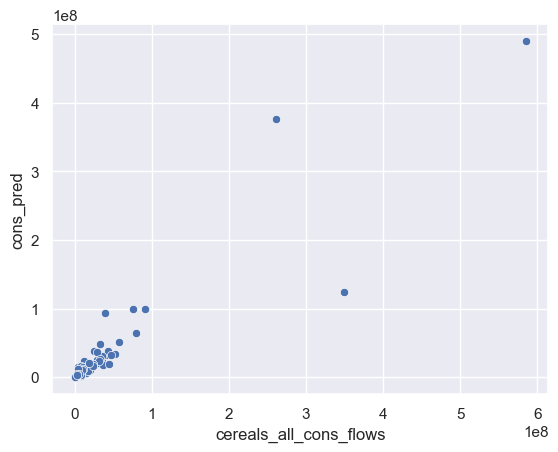

In [17]:
cons['cons_pred'] = res.predict(cons[[
    'from_buffaloes_log', 
    'from_cattle_log', 
    'from_chickens_log', 
    'from_ducks_log',
    'from_goats_log', 
    'from_horses_log', 
    'from_pigs_log', 
    'from_sheep_log', 
    'from_pop_log',
    'from_gdp_log'
]])

cons['cons_pred1'] = res1.predict(cons[[
    'from_buffaloes_log', 
    'from_cattle_log', 
    'from_chickens_log', 
    'from_ducks_log',
    'from_goats_log', 
    'from_horses_log', 
    'from_pigs_log', 
    'from_sheep_log', 
    'from_pop_log',
    'from_gdp_log'
]])
print(r2_score(cons[f'{crop}_cons_flows'], cons['cons_pred']))
sns.scatterplot(x=cons[f'{crop}_cons_flows'], y=cons['cons_pred'])
# plt.xlim(0,2.5e9)
# plt.ylim(0,2.5e9)

0.904144803595733


<Axes: xlabel='cons_pred', ylabel='cons_pred1'>

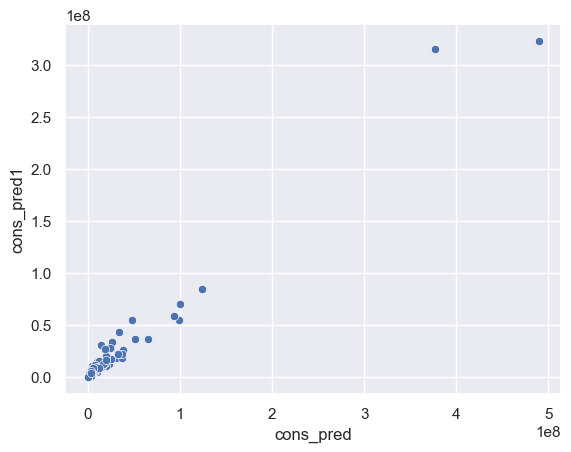

In [18]:
print(r2_score(cons['cons_pred'], cons['cons_pred1']))
sns.scatterplot(x=cons['cons_pred'], y=cons['cons_pred1'])

0.9407366908692777


(0.0, 22.0)

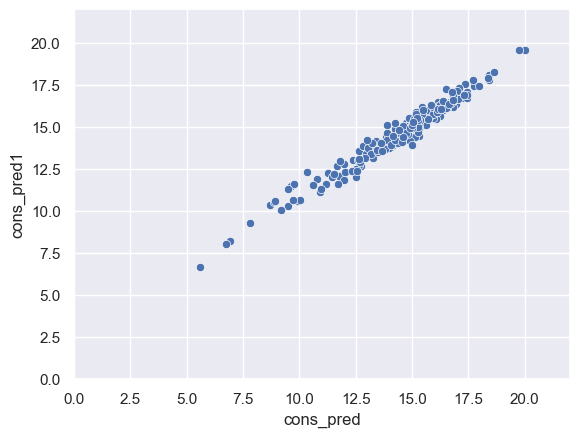

In [19]:
print(r2_score(np.log(cons['cons_pred']+1), np.log(cons['cons_pred1']+1)))
sns.scatterplot(x=np.log(cons['cons_pred']+1), y=np.log(cons['cons_pred1']+1))
plt.xlim(0,22)
plt.ylim(0,22)

0.8674813998322809


(0.0, 22.0)

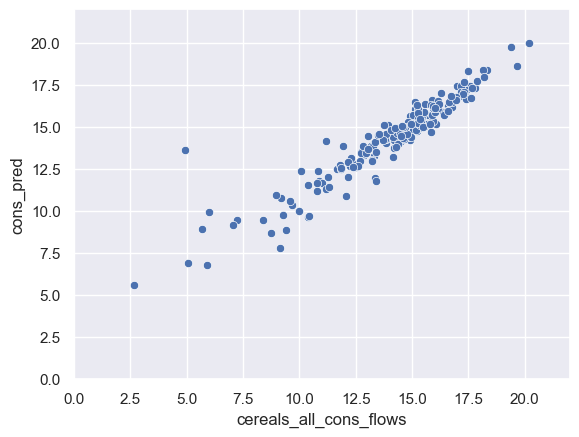

In [20]:
print(r2_score(np.log(cons[f'{crop}_cons_flows']+1), np.log(cons['cons_pred']+1)))
sns.scatterplot(x=np.log(cons[f'{crop}_cons_flows']+1), y=np.log(cons['cons_pred']+1))
plt.xlim(0,22)
plt.ylim(0,22)

0.7880990070627929


(0.0, 22.0)

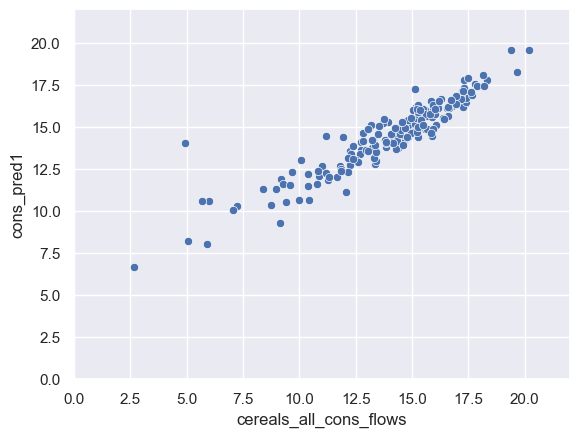

In [21]:
print(r2_score(np.log(cons[f'{crop}_cons_flows']+1), np.log(cons['cons_pred1']+1)))
sns.scatterplot(x=np.log(cons[f'{crop}_cons_flows']+1), y=np.log(cons['cons_pred1']+1))
plt.xlim(0,22)
plt.ylim(0,22)

In [22]:
cons_admin = df_admin[['from_iso3', 'from_id', 'from_buffaloes_log', 'from_cattle_log', 'from_chickens_log', 
                       'from_ducks_log', 'from_goats_log', 'from_horses_log', 'from_pigs_log', 
                       'from_sheep_log', 'from_pop_log', 'from_gdp_log']].drop_duplicates().reset_index(drop=True).rename(columns={'from_iso3': 'iso3', 'from_id': 'ID'})

cons_admin['cons_admin_pred'] = res.predict(cons_admin[[
    'from_buffaloes_log', 'from_cattle_log', 'from_chickens_log', 'from_ducks_log', 
    'from_goats_log', 'from_horses_log',  
    'from_pigs_log', 'from_sheep_log', 
    'from_pop_log', 'from_gdp_log']])

cons_comp = cons_admin.groupby('iso3').sum()[['cons_admin_pred']].reset_index().rename(columns={'cons_admin_pred': 'cons_admin_pred_total'}).merge(cons[['iso3', f'{crop}_cons_flows']])

In [23]:
cons[['from_buffaloes_log', 'from_cattle_log', 'from_chickens_log', 
      'from_ducks_log', 'from_goats_log', 'from_horses_log', 'from_pigs_log', 
      'from_sheep_log', 'from_pop_log']].corr()['from_pop_log']

from_buffaloes_log    0.462746
from_cattle_log       0.831501
from_chickens_log     0.814894
from_ducks_log        0.695071
from_goats_log        0.769141
from_horses_log       0.674331
from_pigs_log         0.553989
from_sheep_log        0.719532
from_pop_log          1.000000
Name: from_pop_log, dtype: float64

In [24]:
cons_admin[['from_buffaloes_log', 'from_cattle_log', 'from_chickens_log', 
            'from_ducks_log', 'from_goats_log', 'from_horses_log', 'from_pigs_log', 
            'from_sheep_log', 'from_pop_log']].corr()['from_pop_log']

from_buffaloes_log    0.338086
from_cattle_log       0.704470
from_chickens_log     0.737005
from_ducks_log        0.568165
from_goats_log        0.626676
from_horses_log       0.432934
from_pigs_log         0.428930
from_sheep_log        0.459581
from_pop_log          1.000000
Name: from_pop_log, dtype: float64

<Axes: xlabel='from_cattle_log', ylabel='from_pop_log'>

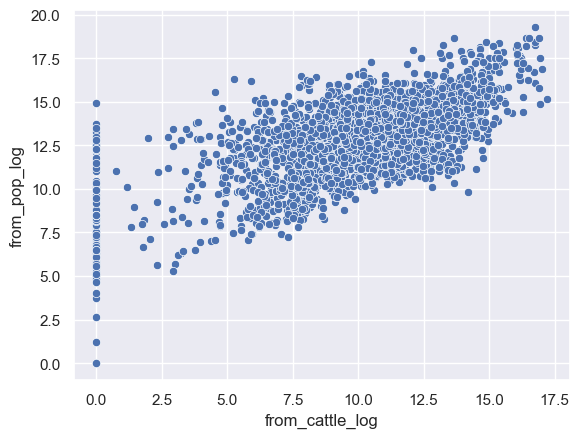

In [25]:
sns.scatterplot(x=cons_admin['from_cattle_log'], y=cons_admin['from_pop_log'])

0.7877558566876424


<Axes: xlabel='cereals_all_cons_flows', ylabel='cons_admin_pred_total'>

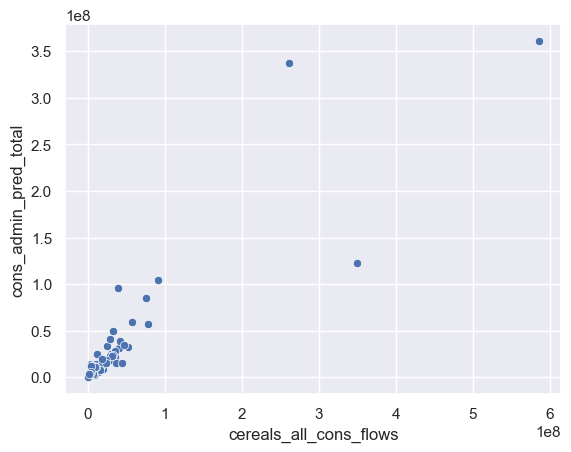

In [26]:
print(r2_score(cons_comp[f'{crop}_cons_flows'], cons_comp['cons_admin_pred_total']))
sns.scatterplot(x=cons_comp[f'{crop}_cons_flows'], y=cons_comp['cons_admin_pred_total'])
# plt.xlim(0,2.5e9)
# plt.ylim(0,2.5e9)

0.8624421421661763


<Axes: xlabel='cereals_all_cons_flows', ylabel='cons_admin_pred_total'>

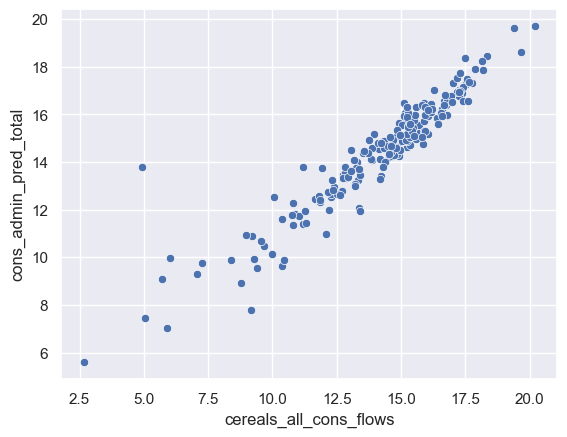

In [27]:
print(r2_score(np.log(cons_comp[f'{crop}_cons_flows']+1), np.log(cons_comp['cons_admin_pred_total']+1)))
sns.scatterplot(x=np.log(cons_comp[f'{crop}_cons_flows']+1), y=np.log(cons_comp['cons_admin_pred_total']+1))
# plt.xlim(0,25)
# plt.ylim(0,25)

In [28]:
cons_admin = cons_admin.merge(cons_comp)
cons_admin['cons_admin_pred_scaled'] = cons_admin['cons_admin_pred'] * cons_admin['cereals_all_cons_flows'] / cons_admin['cons_admin_pred_total']
cons_admin = cons_admin[['iso3', 'ID', 'cons_admin_pred_scaled']]

In [29]:
prod_admin = df_admin[['from_id', 'from_barley_production', 'from_maize_production', 'from_millet_production',
                       'from_rice_production', 'from_sorghum_production', 'from_wheat_production', 
                       'from_other_cereals_production']].drop_duplicates()
cons_admin = cons_admin.merge(prod_admin, left_on='ID', right_on='from_id').drop('from_id', axis=1).reset_index(drop=True)
cons_admin['production_admin_est'] = cons_admin['from_barley_production'] + cons_admin['from_maize_production'] \
+ cons_admin['from_millet_production'] + cons_admin['from_rice_production'] + cons_admin['from_sorghum_production'] \
+ cons_admin['from_wheat_production'] + cons_admin['from_other_cereals_production']
cons_admin = cons_admin.drop(['from_barley_production', 'from_maize_production', 'from_millet_production',
                       'from_rice_production', 'from_sorghum_production', 'from_wheat_production', 
                       'from_other_cereals_production'], axis=1).rename(columns={'cons_admin_pred_scaled': 'cons'})
cons_admin['exp_max'] = cons_admin['production_admin_est'] - cons_admin['cons']

In [30]:
cons_admin.head()

,iso3,ID,cons,production_admin_est,exp_max
0,AFG,AFG.10_1,157999.512209,98648.905145,-59350.607065
1,AFG,AFG.12_1,391789.928831,502593.555395,110803.626565
2,AFG,AFG.13_1,109799.646137,214094.376564,104294.730427
3,AFG,AFG.14_1,639229.622363,94267.444149,-544962.178215
4,AFG,AFG.15_1,273387.915166,267978.221607,-5409.693559


In [31]:
# network
supply_2017 = pd.read_csv("../../data/FAO_re_export/supply_matrix_cereals_all_2017.csv")
supply_2018 = pd.read_csv("../../data/FAO_re_export/supply_matrix_cereals_all_2018.csv")
supply_2019 = pd.read_csv("../../data/FAO_re_export/supply_matrix_cereals_all_2019.csv")
supply_2020 = pd.read_csv("../../data/FAO_re_export/supply_matrix_cereals_all_2020.csv")
supply_2021 = pd.read_csv("../../data/FAO_re_export/supply_matrix_cereals_all_2021.csv")
supply = pd.concat([supply_2017, supply_2018, supply_2019, supply_2020, supply_2021]).groupby('iso3').mean().reset_index()

supply = supply.set_index('iso3')
supply = supply.applymap(lambda x: 1 if x >=1 else 0)

supply_mat = supply.values
np.fill_diagonal(supply_mat,0)

graph = nx.from_numpy_array(supply_mat, create_using=nx.MultiDiGraph())

WINDOW = 1 # Node2Vec fit window
MIN_COUNT = 1 # Node2Vec min. count
BATCH_WORDS = 4 # Node2Vec batch words
DIMENSIONS = 16 

g_emb = n2v(
    graph,
	dimensions=DIMENSIONS
)

WINDOW = 1 # Node2Vec fit window
MIN_COUNT = 1 # Node2Vec min. count
BATCH_WORDS = 4 # Node2Vec batch words
DIMENSIONS = 16 

g_emb = n2v(
    graph,
	dimensions=DIMENSIONS
)

mdl = g_emb.fit(
    window=WINDOW,
    min_count=MIN_COUNT,
    batch_words=BATCH_WORDS
)

emb_df = (
    pd.DataFrame(
        [mdl.wv.get_vector(str(n)) for n in graph.nodes()],
        index = graph.nodes,
        columns = ['dim_'+str(i) for i in range(DIMENSIONS)]
    )
)

emb_df['iso3'] = supply.index
emb_df['degree'] = pd.Series(list(dict(graph.degree()).values()))
emb_df['in_degree'] = pd.Series(list(dict(graph.in_degree()).values()))
emb_df['out_degree'] = pd.Series(list(dict(graph.out_degree()).values()))

python(23838) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Computing transition probabilities:   0%|          | 0/203 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████| 10/10 [00:00<00:00, 62.87it/s]


Computing transition probabilities:   0%|          | 0/203 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████| 10/10 [00:00<00:00, 61.68it/s]


In [32]:
df_country['barley_ratio'] = df_country['from_barley_production'] / (df_country['to_barley_production']+1)
df_country['maize_ratio'] = df_country['from_maize_production'] / (df_country['to_maize_production']+1)
df_country['millet_ratio'] = df_country['from_millet_production'] / (df_country['to_millet_production']+1)
df_country['rice_ratio'] = df_country['from_rice_production'] / (df_country['to_rice_production']+1)
df_country['sorghum_ratio'] = df_country['from_sorghum_production'] / (df_country['to_sorghum_production']+1)
df_country['wheat_ratio'] = df_country['from_wheat_production'] / (df_country['to_wheat_production']+1)
df_country['other_cereals_ratio'] = df_country['from_other_cereals_production'] / (df_country['to_other_cereals_production']+1)

df_admin['barley_ratio'] = df_admin['from_barley_production'] / (df_admin['to_barley_production']+1)
df_admin['maize_ratio'] = df_admin['from_maize_production'] / (df_admin['to_maize_production']+1)
df_admin['millet_ratio'] = df_admin['from_millet_production'] / (df_admin['to_millet_production']+1)
df_admin['rice_ratio'] = df_admin['from_rice_production'] / (df_admin['to_rice_production']+1)
df_admin['sorghum_ratio'] = df_admin['from_sorghum_production'] / (df_admin['to_sorghum_production']+1)
df_admin['wheat_ratio'] = df_admin['from_wheat_production'] / (df_admin['to_wheat_production']+1)
df_admin['other_cereals_ratio'] = df_admin['from_other_cereals_production'] / (df_admin['to_other_cereals_production']+1)

In [33]:
df_country['buffaloes_ratio'] = df_country['from_cattle'] / (df_country['to_buffaloes']+1)
df_country['cattle_ratio'] = df_country['from_cattle'] / (df_country['to_cattle']+1)
df_country['chickens_ratio'] = df_country['from_chickens'] / (df_country['to_chickens']+1)
df_country['ducks_ratio'] = df_country['from_ducks'] / (df_country['to_ducks']+1)
df_country['goats_ratio'] = df_country['from_goats'] / (df_country['to_goats']+1)
df_country['horses_ratio'] = df_country['from_horses'] / (df_country['to_horses']+1)
df_country['pigs_ratio'] = df_country['from_pigs'] / (df_country['to_pigs']+1)
df_country['sheep_ratio'] = df_country['from_sheep'] / (df_country['to_sheep']+1)
df_country['pop_ratio'] = df_country['from_pop'] / (df_country['to_pop']+1)

df_admin['buffaloes_ratio'] = df_admin['from_cattle'] / (df_admin['to_buffaloes']+1)
df_admin['cattle_ratio'] = df_admin['from_cattle'] / (df_admin['to_cattle']+1)
df_admin['chickens_ratio'] = df_admin['from_chickens'] / (df_admin['to_chickens']+1)
df_admin['ducks_ratio'] = df_admin['from_ducks'] / (df_admin['to_ducks']+1)
df_admin['goats_ratio'] = df_admin['from_goats'] / (df_admin['to_goats']+1)
df_admin['horses_ratio'] = df_admin['from_horses'] / (df_admin['to_horses']+1)
df_admin['pigs_ratio'] = df_admin['from_pigs'] / (df_admin['to_pigs']+1)
df_admin['sheep_ratio'] = df_admin['from_sheep'] / (df_admin['to_sheep']+1)
df_admin['pop_ratio'] = df_admin['from_pop'] / (df_admin['to_pop']+1)

In [34]:
df_country = df_country.merge(emb_df, left_on='from_iso3', right_on='iso3').drop('iso3', axis=1).rename(columns={
    'dim_0': 'from_dim_0', 
    'dim_1': 'from_dim_1', 
    'dim_2': 'from_dim_2', 
    'dim_3': 'from_dim_3', 
    'dim_4': 'from_dim_4', 
    'dim_5': 'from_dim_5', 
    'dim_6': 'from_dim_6', 
    'dim_7': 'from_dim_7',
    'dim_8': 'from_dim_8', 
    'dim_9': 'from_dim_9', 
    'dim_10': 'from_dim_10', 
    'dim_11': 'from_dim_11', 
    'dim_12': 'from_dim_12', 
    'dim_13': 'from_dim_13', 
    'dim_14': 'from_dim_14',
    'dim_15': 'from_dim_15',
    'degree': 'from_degree',
    'in_degree': 'from_in_degree',
    'out_degree': 'from_out_degree'
})

df_country = df_country.merge(emb_df, left_on='to_iso3', right_on='iso3').drop('iso3', axis=1).rename(columns={
    'dim_0': 'to_dim_0', 
    'dim_1': 'to_dim_1', 
    'dim_2': 'to_dim_2', 
    'dim_3': 'to_dim_3', 
    'dim_4': 'to_dim_4', 
    'dim_5': 'to_dim_5', 
    'dim_6': 'to_dim_6', 
    'dim_7': 'to_dim_7',
    'dim_8': 'to_dim_8', 
    'dim_9': 'to_dim_9', 
    'dim_10': 'to_dim_10', 
    'dim_11': 'to_dim_11', 
    'dim_12': 'to_dim_12', 
    'dim_13': 'to_dim_13', 
    'dim_14': 'to_dim_14',
    'dim_15': 'to_dim_15',
    'degree': 'to_degree',
    'in_degree': 'to_in_degree',
    'out_degree': 'to_out_degree'
})

In [35]:
X_cols1 = [ 
    'transport_USD_t_log',
    'time_h_log',
    'distance_km_log', 
    'border_USD_t_log',  
    'from_barley_area_log', 
    'from_maize_area_log', 
    'from_millet_area_log', 
    'from_rice_area_log',
    'from_sorghum_area_log', 
    'from_wheat_area_log', 
    'from_other_cereals_area_log',
    'from_barley_production_log', 
    'from_maize_production_log',
    'from_millet_production_log', 
    'from_rice_production_log',
    'from_sorghum_production_log', 
    'from_wheat_production_log',
    'from_other_cereals_production_log', 
    'from_buffaloes_log', 
    'from_cattle_log',
    'from_chickens_log', 
    'from_ducks_log', 
    'from_goats_log', 
    'from_horses_log', 
    'from_pigs_log',
    'from_sheep_log', 
    'from_pop_log', 
    'from_gdp_log',
    'from_area_log', 
    'from_built_volume_total_log',
    # 'from_region_0', 
    # 'from_region_1', 
    # 'from_region_2', 
    # 'from_region_3',
    # 'from_region_4', 
    # 'from_region_5',
    'to_barley_area_log', 
    'to_maize_area_log',
    'to_millet_area_log', 
    'to_rice_area_log', 
    'to_sorghum_area_log', 
    'to_wheat_area_log',
    'to_other_cereals_area_log', 
    'to_barley_production_log', 
    'to_maize_production_log',
    'to_millet_production_log', 
    'to_rice_production_log', 
    'to_sorghum_production_log',
    'to_wheat_production_log', 
    'to_other_cereals_production_log', 
    'to_buffaloes_log',
    'to_cattle_log', 
    'to_chickens_log', 
    'to_ducks_log', 
    'to_goats_log', 
    'to_horses_log',
    'to_pigs_log', 
    'to_sheep_log', 
    'to_pop_log', 
    'to_gdp_log',
    'to_area_log', 
    'to_built_volume_total_log', 
    # 'to_region_0', 
    # 'to_region_1', 
    # 'to_region_2', 
    # 'to_region_3',
    # 'to_region_4', 
    # 'to_region_5',
    'barley_ratio', 
    'maize_ratio',
    'millet_ratio', 
    'rice_ratio', 
    'sorghum_ratio', 
    'wheat_ratio',
    'pop_ratio',
    'buffaloes_ratio', 
    'cattle_ratio',
    'chickens_ratio', 
    'ducks_ratio', 
    'goats_ratio', 
    'horses_ratio',
    'pigs_ratio',
    'sheep_ratio'
]

to_transform1 = [
    # 'transport_USD_t', 'time_h', 'distance_km', 'border_USD_t',  
    # 'from_barley_area', 'from_maize_area', 'from_millet_area', 'from_rice_area', 'from_sorghum_area', 'from_wheat_area', 
    # 'from_other_cereals_area', 'from_barley_production', 'from_maize_production', 'from_millet_production', 'from_rice_production',
    # 'from_sorghum_production', 'from_wheat_production', 'from_other_cereals_production', 
    # 'from_buffaloes', 'from_cattle', 'from_chickens', 'from_ducks', 'from_goats', 'from_horses', 'from_pigs','from_sheep', 
    # 'from_pop', 'from_gdp','from_area', 'from_built_volume_total', 
    # 'to_barley_area', 'to_maize_area', 'to_millet_area', 'to_rice_area', 'to_sorghum_area', 'to_wheat_area','to_other_cereals_area', 
    # 'to_barley_production', 'to_maize_production','to_millet_production', 'to_rice_production', 'to_sorghum_production',
    # 'to_wheat_production', 'to_other_cereals_production', 
    # 'to_buffaloes','to_cattle', 'to_chickens', 'to_ducks', 'to_goats', 'to_horses','to_pigs', 'to_sheep', 
    # 'to_pop', 'to_gdp','to_area', 'to_built_volume_total',
    # 'from_in_degree','from_out_degree', 'to_in_degree','to_out_degree'
]

X_cols2 = X_cols1 + ['from_in_degree', 'from_out_degree', 'to_in_degree', 'to_out_degree']
to_transform2 = to_transform1 + ['from_in_degree', 'from_out_degree', 'to_in_degree', 'to_out_degree']

In [36]:
# df_country.loc[df_country['supply_cereals_all']<1, 'supply_cereals_all_exists'] = 0

#### trade links

In [34]:
df_country[['trade_cereals_all', 'supply_cereals_all']].sum()

trade_cereals_all     4.719630e+08
supply_cereals_all    4.537087e+08
dtype: float64

In [35]:
print(len(df_country[(df_country['trade_cereals_all']>1)]))
print(df_country[(df_country['trade_cereals_all']>1)]['trade_cereals_all'].sum())
print(df_country[(df_country['trade_cereals_all']<=1)]['trade_cereals_all'].sum())

6599
471963003.37
40.0


In [36]:
print(len(df_country[(df_country['supply_cereals_all']>1)]))
print(df_country[(df_country['supply_cereals_all']>1)]['supply_cereals_all'].sum())
print(df_country[(df_country['supply_cereals_all']<=1)]['supply_cereals_all'].sum())

9985
453708745.48764473
0.0


In [37]:
train, test = train_test_split(df_country, test_size=0.2, random_state=0)
train = pd.concat([train, pd.get_dummies(train['from_region'].astype('int32').astype('category'), prefix = 'from_region')], axis=1)
train = pd.concat([train, pd.get_dummies(train['to_region'].astype('int32').astype('category'), prefix = 'to_region')], axis=1)
test = pd.concat([test, pd.get_dummies(test['from_region'].astype('int32').astype('category'), prefix = 'from_region')], axis=1)              
test = pd.concat([test, pd.get_dummies(test['to_region'].astype('int32').astype('category'), prefix = 'to_region')], axis=1)              

In [38]:
# thresh 1, 10, 100, 1000 - [1 captures most links]
# no logs, transform some columns; logs, no transformation; no logs, no tranformation - logs, no transformation works best

In [39]:
y_col1 = 'supply_cereals_all_exists'

In [113]:
X_train = train[X_cols1]
y_train = train[y_col1]

X_test = test[X_cols1]
y_test = test[y_col1]

In [114]:
train.shape

(30264, 272)

In [115]:
test.shape

(7566, 272)

In [116]:
train[train[y_col1]==1].shape

(7959, 272)

In [117]:
test[test[y_col1]==1].shape

(2026, 272)

In [118]:
# clf = LogisticRegression()
clf = HistGradientBoostingClassifier(
    max_iter=5000, 
    class_weight='balanced', 
    min_samples_leaf=100, 
    max_features=0.8,
    # categorical_features=['from_region_0','from_region_0', 'from_region_2', 'from_region_3', 'from_region_4', 'from_region_5',
    #    'to_region_0', 'to_region_1', 'to_region_2', 'to_region_3',
    #    'to_region_4', 'to_region_5'],
    # early_stopping=True, 
    # scoring='f1'
)
# clf = RandomForestClassifier(
#     n_estimators=500, 
#     class_weight='balanced', 
#     max_depth=10, 
#     min_samples_leaf=100
# )

preprocessor = ColumnTransformer(
    transformers=[('scaler', preprocessing.StandardScaler(), to_transform1)],
    remainder='passthrough'
)

pipe_clf = Pipeline([                                                                                        
        # ('scale', preprocessor),
        ('clf', clf)
])

pipe_clf.fit(X_train, y_train)

Pipeline(steps=[('clf',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                max_features=0.8, max_iter=5000,
                                                min_samples_leaf=100))])

In [119]:
y_train_pred = pipe_clf.predict(X_train)
y_test_pred = pipe_clf.predict(X_test)

In [120]:
print(accuracy_score(y_train, y_train_pred))
print(matthews_corrcoef(y_train, y_train_pred))
print(f1_score(y_train, y_train_pred))
print(roc_auc_score(y_train, y_train_pred))
print(precision_score(y_train, y_train_pred))
print(recall_score(y_train, y_train_pred))

0.9721451229183188
0.9311584482929721
0.9490357293996735
0.9766582906866419
0.9145886739687719
0.9861791682372157


In [121]:
print(accuracy_score(y_test, y_test_pred))
print(matthews_corrcoef(y_test, y_test_pred))
print(f1_score(y_test, y_test_pred))
print(roc_auc_score(y_test, y_test_pred))
print(precision_score(y_test, y_test_pred))
print(recall_score(y_test, y_test_pred))

0.9395982024848004
0.8517928783190613
0.8920897284533649
0.9373086696055966
0.8551380715255772
0.9323790720631787


In [122]:
print(y_test_pred.sum())
print(y_test.sum())

2209
2026


In [123]:
train['supply_exists_pred'] = y_train_pred
test['supply_exists_pred'] = y_test_pred

In [124]:
train[(train[y_col1]==1) & (train['supply_exists_pred']==0)]['supply_cereals_all'].describe()

count     110.000000
mean       61.524718
std       289.727735
min         1.010148
25%         1.475645
50%         3.290334
75%        19.149680
max      2955.575363
Name: supply_cereals_all, dtype: float64

In [125]:
test[(test[y_col1]==1) & (test['supply_exists_pred']==0)]['supply_cereals_all'].describe()

count     137.000000
mean       68.845300
std       220.327861
min         1.004931
25%         1.827130
50%         4.251300
75%        21.550623
max      1483.702388
Name: supply_cereals_all, dtype: float64

In [126]:
train_dfs = []
test_dfs = []
for i in range(5):  
    train, test= train_test_split(df_country, test_size=0.2, random_state=i)
    train = pd.concat([train, pd.get_dummies(train['from_region'].astype('int32').astype('category'), prefix = 'from_region')], axis=1)
    train = pd.concat([train, pd.get_dummies(train['to_region'].astype('int32').astype('category'), prefix = 'to_region')], axis=1)
    test = pd.concat([test, pd.get_dummies(test['from_region'].astype('int32').astype('category'), prefix = 'from_region')], axis=1)              
    test = pd.concat([test, pd.get_dummies(test['to_region'].astype('int32').astype('category'), prefix = 'to_region')], axis=1)              
    train_dfs.append(train)
    test_dfs.append(test)
    
all_metrics = []

for clf in [LogisticRegression(solver='liblinear', max_iter=500), 
            HistGradientBoostingClassifier(max_iter=5000, 
                                           class_weight='balanced', 
                                           min_samples_leaf=100, 
                                           max_features=0.8,
                                           # categorical_features=['from_region_0','from_region_0', 'from_region_2', 
                                           #                       'from_region_3', 'from_region_4', 'from_region_5',
                                           #                       'to_region_0', 'to_region_1', 'to_region_2', 'to_region_3',
                                           #                       'to_region_4', 'to_region_5'], 
                                           early_stopping=True), 
            RandomForestClassifier(n_estimators=200, class_weight='balanced', max_depth=15, min_samples_leaf=4)]:
    acc_train = []
    prec_train = []
    rec_train = []
    mcc_train = []
    roc_auc_train = []

    acc_test = []
    prec_test = []
    rec_test = []
    mcc_test = []
    roc_auc_test = []
    
    for i in range(5):
        print(i)
        train = train_dfs[i]
        test = test_dfs[i]
        
        X_train = train[X_cols1]
        y_train = train[y_col1]
        
        X_test = test[X_cols1]
        y_test = test[y_col1]
    
        clf.fit(X_train, y_train)
        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)
        
        acc_train.append(accuracy_score(y_train, y_train_pred))
        prec_train.append(precision_score(y_train, y_train_pred))
        rec_train.append(recall_score(y_train, y_train_pred))
        mcc_train.append(matthews_corrcoef(y_train, y_train_pred))
        roc_auc_train.append(roc_auc_score(y_train, y_train_pred))

        acc_test.append(accuracy_score(y_test, y_test_pred))
        prec_test.append(precision_score(y_test, y_test_pred))
        rec_test.append(recall_score(y_test, y_test_pred))
        mcc_test.append(matthews_corrcoef(y_test, y_test_pred))
        roc_auc_test.append(roc_auc_score(y_test, y_test_pred))
    
    metrics = [acc_train, prec_train, rec_train, mcc_train, roc_auc_train,
               acc_test, prec_test, rec_test, mcc_test, roc_auc_test]
    all_metrics.append(metrics)

print('logistic')

print('train')
print(f'acc: {np.mean(all_metrics[0][0])}')
print(f'prec: {np.mean(all_metrics[0][1])}')
print(f'rec: {np.mean(all_metrics[0][2])}')
print(f'mcc: {np.mean(all_metrics[0][3])}')
print(f'roc_auc: {np.mean(all_metrics[0][4])}')

print('test')
print(f'acc: {np.mean(all_metrics[0][5])}')
print(f'prec: {np.mean(all_metrics[0][6])}')
print(f'rec: {np.mean(all_metrics[0][7])}')
print(f'mcc: {np.mean(all_metrics[0][8])}')
print(f'roc_auc: {np.mean(all_metrics[0][9])}')

print('grad')

print('train')
print(f'acc: {np.mean(all_metrics[1][0])}')
print(f'prec: {np.mean(all_metrics[1][1])}')
print(f'rec: {np.mean(all_metrics[1][2])}')
print(f'mcc: {np.mean(all_metrics[1][3])}')
print(f'roc_auc: {np.mean(all_metrics[1][4])}')

print('test')
print(f'acc: {np.mean(all_metrics[1][5])}')
print(f'prec: {np.mean(all_metrics[1][6])}')
print(f'rec: {np.mean(all_metrics[1][7])}')
print(f'mcc: {np.mean(all_metrics[1][8])}')
print(f'roc_auc: {np.mean(all_metrics[1][9])}')

print('rf')

print('train')
print(f'acc: {np.mean(all_metrics[2][0])}')
print(f'prec: {np.mean(all_metrics[2][1])}')
print(f'rec: {np.mean(all_metrics[2][2])}')
print(f'mcc: {np.mean(all_metrics[2][3])}')
print(f'roc_auc: {np.mean(all_metrics[2][4])}')

print('test')
print(f'acc: {np.mean(all_metrics[2][5])}')
print(f'prec: {np.mean(all_metrics[2][6])}')
print(f'rec: {np.mean(all_metrics[2][7])}')
print(f'mcc: {np.mean(all_metrics[2][8])}')
print(f'roc_auc: {np.mean(all_metrics[2][9])}')

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
logistic
train
acc: 0.768080888183981
prec: 0.684528414693618
rec: 0.23269498112673367
mcc: 0.29723834560324963
roc_auc: 0.5963984394121199
test
acc: 0.768781390430875
prec: 0.6911405387374382
rec: 0.23031555008730567
mcc: 0.29896815636992413
roc_auc: 0.5960153338369777
grad
train
acc: 0.9610494316679883
prec: 0.886428744459178
rec: 0.9777956923222219
mcc: 0.9050827165819438
roc_auc: 0.9664195581529423
test
acc: 0.9330161247687021
prec: 0.8334138730854468
rec: 0.9323207542693062
mcc: 0.8363502001538814
roc_auc: 0.9327947048160666
rf
train
acc: 0.9668649220195611
prec: 0.9076696840152303
rec: 0.9735162775625966
mcc: 0.917737031609964
roc_auc: 0.968997820816164
test
acc: 0.9278350515463918
prec: 0.83447980714258
rec: 0.9060800997319985
mcc: 0.8204724875272211
roc_auc: 0.9208597285521574


In [129]:
# try hyperparameter tuning first

acc_train = []
prec_train = []
rec_train = []
mcc_train = []
roc_auc_train = []

acc_test = []
prec_test = []
rec_test = []
mcc_test = []
roc_auc_test = []

params = {'lr': 0.0001,
     'batch_size': 256,
     'epochs': 100,
     'optimizer': tf.keras.optimizers.Adam,
     'dropout': 0.1,
     'dense_neurons': 32
    }

lr = params['lr']
# decay = params['decay']
batch_size = params['batch_size']
epochs = params['epochs']
optimizer = params['optimizer']
dropout = params['dropout']
dense_neurons = params['dense_neurons']

metrics = ['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
activation='relu'

for i in range(5):
    print(i)
    train = train_dfs[i]
    test = test_dfs[i]
    train[['from_region_0', 'from_region_1', 'from_region_2', 'from_region_3','from_region_4', 
    'from_region_5','to_region_0', 'to_region_1', 'to_region_2', 'to_region_3',
    'to_region_4', 'to_region_5']] = train[['from_region_0', 'from_region_1', 'from_region_2', 'from_region_3','from_region_4', 
        'from_region_5','to_region_0', 'to_region_1', 'to_region_2', 'to_region_3',
        'to_region_4', 'to_region_5']].astype('float32')
    test[['from_region_0', 'from_region_1', 'from_region_2', 'from_region_3','from_region_4', 
    'from_region_5','to_region_0', 'to_region_1', 'to_region_2', 'to_region_3',
    'to_region_4', 'to_region_5']] = test[['from_region_0', 'from_region_1', 'from_region_2', 'from_region_3','from_region_4', 
        'from_region_5','to_region_0', 'to_region_1', 'to_region_2', 'to_region_3',
        'to_region_4', 'to_region_5']].astype('float32')
    
    X_train = train[X_cols1]
    y_train = train[y_col1]
    
    X_test = test[X_cols1]
    y_test = test[y_col1]
    
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1])))
    model.add(layers.Dense(dense_neurons, activation=activation)) # hidden layer 1
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(dense_neurons, activation=activation)) # hidden layer 2
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation='sigmoid')) 
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer(learning_rate=lr), metrics=metrics)
    
    model.fit(X_train, y_train, 
              # validation_split=0.1,
              validation_data=(X_test, y_test), 
              epochs=epochs, 
              batch_size=batch_size, 
              verbose=0)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    y_train_pred[y_train_pred <= 0.5] = 0
    y_train_pred[y_train_pred > 0.5] = 1
    y_test_pred[y_test_pred <= 0.5] = 0.
    y_test_pred[y_test_pred > 0.5] = 1.

    acc_train.append(accuracy_score(y_train, y_train_pred))
    prec_train.append(precision_score(y_train, y_train_pred))
    rec_train.append(recall_score(y_train, y_train_pred))
    mcc_train.append(matthews_corrcoef(y_train, y_train_pred))
    roc_auc_train.append(roc_auc_score(y_train, y_train_pred))

    acc_test.append(accuracy_score(y_test, y_test_pred))
    prec_test.append(precision_score(y_test, y_test_pred))
    rec_test.append(recall_score(y_test, y_test_pred))
    mcc_test.append(matthews_corrcoef(y_test, y_test_pred))
    roc_auc_test.append(roc_auc_score(y_test, y_test_pred))

print('deep learning')

print('train')
print(f'acc: {np.mean(acc_train)}')
print(f'prec: {np.mean(prec_train)}')
print(f'rec: {np.mean(rec_train)}')
print(f'mcc: {np.mean(mcc_train)}')
print(f'roc_auc: {np.mean(roc_auc_train)}')

print('test')
print(f'acc: {np.mean(acc_test)}')
print(f'prec: {np.mean(prec_test)}')
print(f'rec: {np.mean(rec_test)}')
print(f'mcc: {np.mean(mcc_test)}')
print(f'roc_auc: {np.mean(roc_auc_test)}')

0
237/237 [==============================] - 0s 637us/step
1
237/237 [==============================] - 0s 632us/step
2
237/237 [==============================] - 0s 746us/step
3
237/237 [==============================] - 0s 710us/step
4
237/237 [==============================] - 0s 728us/step
deep learning
train
acc: 0.6590999206978588
prec: 0.3862136042395036
rec: 0.46039349275357083
mcc: 0.18726070231003772
roc_auc: 0.5955120633525119
test
acc: 0.6595294739624638
prec: 0.38047044314158834
rec: 0.46511581360427795
mcc: 0.1871885027936735
roc_auc: 0.596622175233437


#### volume of trade

In [71]:
crop = 'cereals_all'
y_col2 = f'supply_{crop}_log'

In [72]:
train, test = train_test_split(df_country, test_size=0.2, random_state=0)
train = pd.concat([train, pd.get_dummies(train['from_region'].astype('int32').astype('category'), prefix = 'from_region')], axis=1)
train = pd.concat([train, pd.get_dummies(train['to_region'].astype('int32').astype('category'), prefix = 'to_region')], axis=1)
test = pd.concat([test, pd.get_dummies(test['from_region'].astype('int32').astype('category'), prefix = 'from_region')], axis=1)              
test = pd.concat([test, pd.get_dummies(test['to_region'].astype('int32').astype('category'), prefix = 'to_region')], axis=1)              

train =  train[train[f'supply_{crop}']>1].reset_index(drop=True)
test = test[test[f'supply_{crop}']>1].reset_index(drop=True)

X_train = train[X_cols2]
y_train = train[y_col2]

X_test = test[X_cols2]
y_test = test[y_col2]

In [73]:
fml = f"{y_col2} ~ " + " + ".join(X_cols1) + " - 1"
mod = sm.OLS.from_formula(fml, data=train)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     supply_cereals_all_log   R-squared (uncentered):                   0.815
Model:                                OLS   Adj. R-squared (uncentered):              0.813
Method:                     Least Squares   F-statistic:                              489.8
Date:                    Tue, 12 Mar 2024   Prob (F-statistic):                        0.00
Time:                            23:15:49   Log-Likelihood:                         -19033.
No. Observations:                    7959   AIC:                                  3.821e+04
Df Residuals:                        7888   BIC:                                  3.870e+04
Df Model:                              71                                                  
Covariance Type:                nonrobust                                                  
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
transport_USD_t_log                  -0.6425      0.130     -4.955      0.000      -0.897      -0.388
time_h_log                           -0.0494      0.140     -0.353      0.724      -0.324       0.225
distance_km_log                      -1.2387      0.141     -8.812      0.000      -1.514      -0.963
border_USD_t_log                     -0.7864      0.079     -9.976      0.000      -0.941      -0.632
from_barley_area_log                 -0.1772      0.023     -7.649      0.000      -0.223      -0.132
from_maize_area_log                  -0.0347      0.027     -1.289      0.197      -0.088       0.018
from_millet_area_log                  0.0253      0.012      2.087      0.037       0.002       0.049
from_rice_area_log                   -0.0249      0.023     -1.090      0.276      -0.070       0.020
from_sorghum_area_log                 0.0498      0.013      3.842      0.000       0.024       0.075
from_wheat_area_log                   0.1858      0.029      6.301      0.000       0.128       0.244
from_other_cereals_area_log           0.2450      0.016     15.284      0.000       0.214       0.276
from_barley_production_log            0.1455      0.020      7.310      0.000       0.106       0.184
from_maize_production_log            -0.0309      0.022     -1.382      0.167      -0.075       0.013
from_millet_production_log            0.0185      0.012      1.570      0.116      -0.005       0.042
from_rice_production_log              0.0595      0.021      2.776      0.006       0.017       0.102
from_sorghum_production_log           0.0594      0.013      4.553      0.000       0.034       0.085
from_wheat_production_log             0.0541      0.027      2.036      0.042       0.002       0.106
from_other_cereals_production_log    -0.2013      0.017    -12.194      0.000      -0.234      -0.169
from_buffaloes_log                    0.1370      0.010     14.287      0.000       0.118       0.156
from_cattle_log                      -0.1453      0.053     -2.768      0.006      -0.248      -0.042
from_chickens_log                     0.2960      0.050      5.950      0.000       0.198       0.393
from_ducks_log                        0.1217      0.016      7.460      0.000       0.090       0.154
from_goats_log                       -0.2065      0.027     -7.673      0.000      -0.259      -0.154
from_horses_log                       0.1588      0.026      6.122      0.000       0.108       0.210
from_pigs_log                         0.0540      0.020      2.635      0.008       0.014       0.094
from_sheep_log                       -0.3413      0.024    -14.177      0.000      -

0.4263210439639106


<Axes: xlabel='supply_cereals_all_log'>

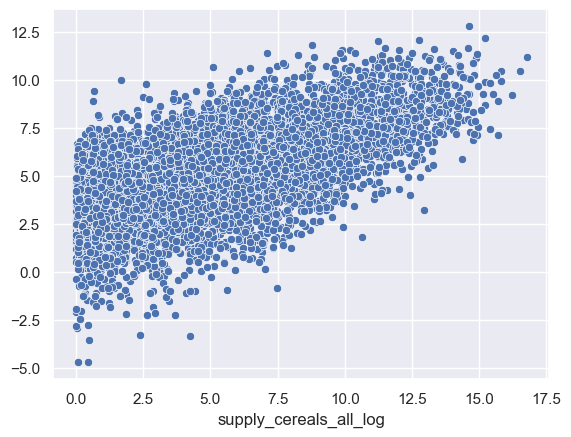

In [74]:
y_train_pred = res.predict(train)
y_test_pred = res.predict(test)
print(r2_score(train[y_col2], y_train_pred))
sns.scatterplot(x=train[y_col2], y=y_train_pred)

In [75]:
print(r2_score(np.exp(train[y_col2]), np.exp(y_train_pred)))
print(r2_score(test[y_col2], y_test_pred))
print(r2_score(np.exp(test[y_col2]), np.exp(y_test_pred)))

-0.0011961016736055097
0.41721184203654826
0.010835405741889792


In [45]:
def custom_r2(y, y_pred):
    return r2_score(np.exp(y), np.exp(y_pred))
    
def custom_rmse(y, y_pred):
    return root_mean_squared_error(np.exp(y), np.exp(y_pred))

def hyperparameters_tuning_hist(pipe, X_train, y_train):
    
    gridparam = dict(
                    reg__l2_regularization=[3, 10, 100],
                    reg__min_samples_leaf=[100],
                    reg__max_features=[0.4, 0.8],
                    reg__max_depth=[5, 10],
                    reg__max_iter=[1000, 2000]
    )
    
    cv = GridSearchCV(pipe, gridparam, cv=5, verbose=2, 
                      return_train_score=True, scoring={
                          'r2 - log trade': 'r2', 
                          'r2 - trade': make_scorer(custom_r2),
                          'rmse - trade': make_scorer(custom_rmse)
                      }, refit='r2 - log trade') 
    cv.fit(X_train, y_train)
    print(f"best cv val metric : {cv.best_score_}")
    print(f"train r2 - log trade : {cv.cv_results_['mean_train_r2 - log trade']}")
    print(f"test r2 - log trade : {cv.cv_results_['mean_test_r2 - log trade']}")
    print(f"train r2 - trade : {cv.cv_results_['mean_train_r2 - trade']}")
    print(f"test r2 - trade : {cv.cv_results_['mean_test_r2 - trade']}")
    print(f"train rmse - trade : {cv.cv_results_['mean_train_rmse - trade']}")
    print(f"test rmse - trade : {cv.cv_results_['mean_test_rmse - trade']}")
    print(cv.best_params_)

    return cv.best_params_

def model_hist(X_train, y_train, X_test, y_test):
    
    preprocessor = ColumnTransformer(
        transformers=[('scaler', preprocessing.StandardScaler(), to_transform2)],
        remainder='passthrough'
    )
    
    pipe = Pipeline([                                                                                        
            ('scale', preprocessor),
            ('reg', HistGradientBoostingRegressor())
    ])

    bestparams = hyperparameters_tuning_hist(pipe, X_train, y_train)
    pipe.set_params(**bestparams)
    pipe.fit(X_train, y_train)
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)
    print(f"train r2 - log trade : {r2_score(y_train, y_train_pred)}")
    print(f"test r2 - log trade : {r2_score(np.exp(y_train), np.exp(y_train_pred))}")
    print(f"train r2 - trade : {r2_score(y_test, y_test_pred)}")
    print(f"test r2 - trade : {r2_score(np.exp(y_test), np.exp(y_test_pred))}")
    print(f"train rmse - trade : {root_mean_squared_error(np.exp(y_train), np.exp(y_train_pred))}")
    print(f"test rmse - trade : {root_mean_squared_error(np.exp(y_test), np.exp(y_test_pred))}")
    return y_train_pred, y_test_pred

In [46]:
# y_train_pred, y_test_pred = model_hist(X_train, y_train, X_test, y_test)
# print(f"total flow: {np.exp(y_test).sum() + np.exp(y_train).sum()}")
# print(f"total flow predicted: {np.exp(y_test_pred).sum() + np.exp(y_train_pred).sum()}")

In [188]:
# order 
# l2_regularization, max_depth, max_features, max_iter, min_samples, leaf

In [189]:
# cereals all

# train r2 - log trade : [0.92687757 0.96896085 0.93105166 0.9708162  0.97773367 0.99513172
#  0.97964006 0.99543865 0.92605314 0.96821342 0.930526   0.97069338
#  0.97712507 0.99478    0.97851348 0.99514166 0.90998041 0.95698339
#  0.91543054 0.96056777 0.96640341 0.99071441 0.96950549 0.99177807]
# test r2 - log trade : [0.71299689 0.71353956 0.71238393 0.71174245 0.72001829 0.71750576
#  0.71626564 0.71541158 0.71416428 0.71370459 0.71218234 0.71394348
#  0.7197903  0.72322936 0.71953659 0.71714229 0.71363087 0.71757862
#  0.71203027 0.71405293 0.72458313 0.7232439  0.72138004 0.72115848]
# train r2 - trade : [0.65395827 0.81115253 0.62670965 0.79963846 0.85261154 0.96770788
#  0.87627616 0.96906797 0.67613969 0.67868569 0.68992091 0.82943305
#  0.84567716 0.96282806 0.87182492 0.96512752 0.61546376 0.75655858
#  0.61408074 0.78199668 0.751279   0.93022876 0.79007856 0.9399717 ]
# test r2 - trade : [ 0.15193791  0.07528541  0.18248309  0.18448076  0.30046022  0.12430207
#   0.27155264  0.18825408  0.16422459 -0.01623212  0.11874814  0.06383508
#   0.30700506  0.21892781  0.0693912   0.25769142  0.18446263  0.22078361
#   0.16495897  0.04238667  0.25849998  0.22596394  0.2372363   0.21943897]
# train rmse - trade : [241467.61219835 178656.16169494 249475.30586076 183033.72725213
#  156635.30090974  74013.32779591 143675.79520247  72099.98544428
#  233512.81468564 230958.30101504 227652.88899928 169656.0099134
#  161464.2459266   78223.17218811 147160.38775236  76324.59819261
#  253818.63312609 202317.43453692 254453.73036115 191075.55247972
#  204345.3333607  108184.52472334 186894.66578452 100004.1109527 ]
# test rmse - trade : [354359.40891392 356367.3277547  354906.92527997 350437.5362571
#  322693.78317986 357745.02903634 335353.48446615 356077.70855534
#  354813.5779811  358523.60454095 359039.71126322 341318.89473011
#  321420.06110618 346731.93084396 361586.21313341 338069.31892728
#  354318.70370166 345521.65185545 358274.5640346  365982.58389063
#  343414.60991301 343987.9454271  343371.78069395 351188.29229072]

# based on test r2 on logs
# best cv val metric : 0.724583125531022
# {'reg__l2_regularization': 100, 'reg__max_depth': 10, 'reg__max_features': 0.4, 'reg__max_iter': 1000, 'reg__min_samples_leaf': 100}
# train r2 - log trade : 0.9589679316662425
# test r2 - log trade : 0.7859039001807382
# train r2 - trade : 0.7282016747658648
# test r2 - trade : 0.5616057311734228
# train rmse - trade : 191369.51335538854
# test rmse - trade : 178396.6836922448
# total flow: 453708745.4876446
# total flow predicted: 291667756.87972826

# based on test r2 
# best cv val metric : 0.30700506
# {'reg__l2_regularization': 10, 'reg__max_depth': 10, 'reg__max_features': 0.4, 'reg__max_iter': 1000, 'reg__min_samples_leaf': 100}
# train r2 - log trade : 0.9711411641286849
# test r2 - log trade : 0.8243566078827033
# train r2 - trade : 0.7215094322276305
# test r2 - trade : 0.5349127288795802
# train rmse - trade : 173334.20881844894
# test rmse - trade : 183747.5552787945
# total flow: 453708745.4876446
# total flow predicted: 325000307.06383985

In [190]:
# maize

# train r2 - log trade : [0.95226533 0.98462457 0.95562814 0.98619981 0.98741893 0.99810742
#  0.98899063 0.99840756 0.95025795 0.98442471 0.95435158 0.98584794
#  0.98656898 0.99790604 0.98834492 0.99825608 0.93402689 0.97486611
#  0.93954236 0.97786874 0.97179619 0.99397485 0.97684551 0.99550158]
# test r2 - log trade : [0.65108831 0.64427053 0.64889482 0.63938589 0.64509755 0.63941756
#  0.64396248 0.63649444 0.64952019 0.64116714 0.64730289 0.63867787
#  0.64874494 0.6411198  0.64240444 0.63626626 0.657038   0.65138119
#  0.6525864  0.6462497  0.6597558  0.6481121  0.65375891 0.64468483]
# train r2 - trade : [0.69282552 0.88659669 0.68985059 0.90419624 0.88025166 0.98760132
#  0.90065741 0.99024546 0.64691444 0.87971269 0.6637417  0.89465501
#  0.88582307 0.98547959 0.90718094 0.98974595 0.5661515  0.8119922
#  0.61067491 0.83214487 0.77514922 0.94689144 0.81330675 0.96628497]
# test r2 - trade : [0.23140984 0.25609221 0.26438991 0.20241403 0.20348276 0.16882005
#  0.19772238 0.14203898 0.26379712 0.23123222 0.20440981 0.23103736
#  0.20921813 0.1831796  0.17807982 0.17188659 0.18941452 0.22942686
#  0.20389051 0.21814925 0.19192301 0.18759696 0.2177613  0.20355096]
# train rmse - trade : [236082.42058284 143170.03246175 236287.21025957 131509.08870767
#  146789.86782049  46696.85638602 133194.30303613  41475.47194168
#  251641.57075112 147562.00282389 246763.61634281 137325.85173561
#  142164.23441117  50056.16357496 128978.44829167  42727.35788145
#  282284.39186492 183792.89389887 266517.19168773 174232.35328839
#  200294.87737324  96458.39277911 183262.4405509   76098.50921808]
# test rmse - trade : [351692.48178358 346061.80789231 342696.91699694 358187.86115819
#  356236.23285143 365065.0916002  357704.05498774 366713.70583398
#  338964.88215422 341761.34084745 355864.4945496  350785.53109647
#  358997.51934113 362154.18818032 359879.13301275 363019.57627316
#  357185.87377421 350512.37056321 352208.25161597 348949.65251298
#  360373.935208   358758.96618696 355467.53199997 351479.92975202]

# based on test r2 on logs
# best cv val metric : 0.6597557950840479
# {'reg__l2_regularization': 100, 'reg__max_depth': 10, 'reg__max_features': 0.4, 'reg__max_iter': 1000, 'reg__min_samples_leaf': 100}
# train r2 - log trade : 0.9731944490217616
# test r2 - log trade : 0.789497755446521
# train r2 - trade : 0.6450305031352483
# test r2 - trade : 0.5008175106218202
# train rmse - trade : 198519.9639800555
# test rmse - trade : 149492.08797005346
# total flow: 177310862.27322513
# total flow predicted: 112799799.06900077

# based on test r2
# best cv val metric : 0.26438991
# {'reg__l2_regularization':3, 'reg__max_depth':5, 'reg__max_features':0.8, 'reg__max_iter':1000, 'reg__min_samples_leaf':100}
# train r2 - log trade : 0.950750104406969
# test r2 - log trade : 0.6881886749116273
# train r2 - trade : 0.6283265201103875
# test r2 - trade : 0.4636994953233132
# train rmse - trade : 241613.81605089703
# test rmse - trade : 154950.37775218874
# total flow: 177310862.27322513
# total flow predicted: 102774814.17618142

In [191]:
# wheat

# train r2 - log trade : [0.94543138 0.98113706 0.94966171 0.98333485 0.98489842 0.99735048
#  0.98642309 0.99758767 0.9432955  0.98028645 0.94778653 0.9825202
#  0.98421271 0.99707304 0.98608559 0.99745724 0.92566922 0.97061659
#  0.93069149 0.9734588  0.96935865 0.99286239 0.97454164 0.99443683]
# test r2 - log trade : [0.63293118 0.62538658 0.62944212 0.62618548 0.64213601 0.6376212
#  0.6364835  0.63107536 0.6369461  0.63521004 0.63321836 0.63226709
#  0.64441395 0.6402023  0.64287789 0.63587071 0.63837056 0.63816727
#  0.63621389 0.63506907 0.65444208 0.64906468 0.64927188 0.64484958]
# train r2 - trade : [0.67589285 0.86627036 0.69149112 0.86943315 0.88316355 0.98639689
#  0.8900176  0.98596382 0.67834192 0.85347151 0.66525607 0.86945374
#  0.88395473 0.98303412 0.88751678 0.98237078 0.5608777  0.79022994
#  0.59798772 0.80161768 0.78734759 0.9533508  0.82755682 0.9650512 ]
# test r2 - trade : [-1.18961807 -0.09324436 -0.36368727 -0.36336922 -0.07788502 -0.15463472
#   0.10074197 -0.04370928 -0.36641358 -0.23855251 -0.55384467 -0.276134
#   0.08232979  0.02777388 -0.21123241 -0.03386179 -0.14227595 -0.23697243
#  -0.0316639  -0.48448088  0.06350943  0.04647809  0.00267104  0.0915583 ]
# train rmse - trade : [145286.57667569  93216.36340031 141954.67272339  91881.41070742
#   87366.36477463  29777.31933519  84242.52720883  30186.38388513
#  144909.90676652  97807.33626067 147931.38818805  92236.15301349
#   87239.58393811  33363.92167534  85514.30465308  34053.85478935
#  169455.15791369 117313.64718425 162274.17482814 114038.36396586
#  117889.20656582  55064.05752134 106040.77523244  47751.81073924]
# test rmse - trade : [291418.18596477 247424.57964579 264450.6033925  273137.86076235
#  245188.80966126 257206.13526908 229898.50433907 247130.07034412
#  260252.02514388 257822.71585923 274224.43355657 267524.61009344
#  234823.68723895 239162.61378599 249781.52410639 240004.61529471
#  249093.5561763  259055.84530901 240610.96524476 269304.03863651
#  233404.88507351 239869.03697698 239884.93105258 233645.52771096]

# based on test r2 on logs
# best cv val metric : 0.6544420840953322
# {'reg__l2_regularization': 100, 'reg__max_depth': 10, 'reg__max_features': 0.4, 'reg__max_iter': 1000, 'reg__min_samples_leaf': 100}
# train r2 - log trade : 0.9709882521582712
# test r2 - log trade : 0.7843416867339322
# train r2 - trade : 0.6626531698253249
# test r2 - trade : 0.4753239430477738
# train rmse - trade : 119311.94031080841
# test rmse - trade : 142640.94723168664
# total flow: 184094853.13257334
# total flow predicted: 125566575.77717781

# based on test r2
# best cv val metric : 0.10074197
# {'reg__l2_regularization':3, 'reg__max_depth':10, 'reg__max_features':0.8, 'reg__max_iter':1000, 'reg__min_samples_leaf':100}
# train r2 - log trade : 0.9846512019338707
# test r2 - log trade : 0.8589484825327818
# train r2 - trade : 0.6631070423370398
# test r2 - trade : 0.5798193090096266
# train rmse - trade : 96491.63998581051
# test rmse - trade : 127648.77065700424
# total flow: 184094853.13257334
# total flow predicted: 137498098.03800207

In [192]:
# rice 

# train r2 - log trade : [0.94792471 0.98295054 0.95205691 0.9848739  0.98687206 0.99747993
#  0.98833931 0.9978227  0.94684425 0.98221915 0.95118104 0.98438635
#  0.98618733 0.99726115 0.98778914 0.99758749 0.93013466 0.97328189
#  0.93562724 0.97659105 0.97275528 0.99378244 0.97739106 0.9951469 ]
# test r2 - log trade : [0.66726041 0.66803798 0.66651325 0.66179514 0.67184322 0.67345491
#  0.67184248 0.67101109 0.66566919 0.666973   0.67001215 0.66584248
#  0.66994326 0.67479521 0.67316325 0.66910835 0.67219606 0.67225763
#  0.67021678 0.67113895 0.67863227 0.67939254 0.67740133 0.67625417]
# train r2 - trade : [0.73659476 0.89316769 0.7629272  0.91505179 0.90943362 0.98442425
#  0.92056865 0.98812731 0.74047662 0.8904236  0.74072108 0.90753053
#  0.90300262 0.98245075 0.91514726 0.98711764 0.6627132  0.83424384
#  0.68183607 0.85659997 0.82238005 0.95399398 0.8431939  0.96930899]
# test r2 - trade : [0.23731705 0.30868129 0.32997101 0.17464463 0.24849052 0.24261826
#  0.24970899 0.26367352 0.279863   0.23523092 0.22830618 0.26813245
#  0.24921239 0.23645616 0.23245547 0.25664271 0.26023645 0.24556276
#  0.25048486 0.26185476 0.24580332 0.2545784  0.24962693 0.25262439]
# train rmse - trade : [24960.88774169 15895.0477523  23679.52422973 14164.07555889
#  14592.84941231  6048.88266592 13722.73340481  5298.89705784
#  24795.8893588  16066.15496659 24759.26250901 14798.54877242
#  15118.36944523  6437.81288088 14183.12182445  5524.07138469
#  28276.69828826 19802.91496091 27423.98708956 18426.85707346
#  20439.82513702 10439.84306034 19231.15381359  8521.58048381]
# test rmse - trade : [41930.49169889 39517.63921573 38513.47420016 43391.57668021
#  41553.31901249 41572.55225734 41401.14747486 40831.25663237
#  40522.27346673 41956.06836933 41987.84376713 40785.11933387
#  41359.32701692 41886.50252846 41809.97416471 41092.29722206
#  41048.56645825 41645.0854084  41386.92486557 40971.36313893
#  41534.02789959 41168.38579291 41399.02976516 41025.74210136]

# based on test r2 on logs
# best cv val metric : 0.6793925391124208
# {'reg__l2_regularization': 100, 'reg__max_depth': 10, 'reg__max_features': 0.4, 'reg__max_iter': 2000, 'reg__min_samples_leaf': 100}
# train r2 - log trade : 0.9938533251686009
# test r2 - log trade : 0.9577261724100654
# train r2 - trade : 0.7200696298201927
# test r2 - trade : 0.15033668868355898
# train rmse - trade : 10015.120252476014
# test rmse - trade : 83347.72705830651
# total flow: 42551728.91545264
# total flow predicted: 29621693.995779578

# based on test r2
# best cv val metric : 0.32997101
# {'reg__l2_regularization':3, 'reg__max_depth':5, 'reg__max_features':0.8, 'reg__max_iter':1000, 'reg__min_samples_leaf':100}
# train r2 - log trade : 0.9482868000603851
# test r2 - log trade : 0.7244137915000939
# train r2 - trade : 0.7118374253320445
# test r2 - trade : 0.16399500595825645
# train rmse - trade : 25571.08302314236
# test rmse - trade : 82675.10666494847
# total flow: 42551728.91545264
# total flow predicted: 22513035.604825985

In [193]:
# other cereals

# train r2 - log trade : [0.94496433 0.98197225 0.94888296 0.98427289 0.98667433 0.997986
#  0.98780599 0.99827403 0.94322354 0.98177817 0.94718905 0.9835555
#  0.98576566 0.99786367 0.98741845 0.9980965  0.92406371 0.97159772
#  0.93020952 0.9747021  0.97141488 0.99423169 0.97639189 0.99562562]
# test r2 - log trade : [0.62053249 0.61416962 0.61464799 0.61121186 0.62732087 0.62248137
#  0.62412724 0.62164116 0.61824526 0.61921577 0.61795922 0.61441653
#  0.62777417 0.6271083  0.62585269 0.6243413  0.62802655 0.62365197
#  0.62308178 0.62108016 0.63032156 0.6306607  0.63004443 0.62256546]
# train r2 - trade : [0.66922751 0.86738176 0.67139887 0.88620454 0.82438112 0.98046022
#  0.84727025 0.98518424 0.62111669 0.86484953 0.65453282 0.87229564
#  0.81458837 0.97927163 0.8324703  0.98041515 0.5081266  0.7586701
#  0.52979975 0.78701226 0.66561389 0.91976821 0.7162638  0.94047068]
# test r2 - trade : [0.19911546 0.21019871 0.14805836 0.18486653 0.15036066 0.15224397
#  0.16713314 0.09993019 0.17729005 0.16945303 0.17274287 0.19291648
#  0.14869129 0.15433592 0.13358349 0.13966002 0.13759629 0.1660447
#  0.12102708 0.17014819 0.14340474 0.1617075  0.13743524 0.12756324]
# train rmse - trade : [64645.82456501 40526.16372169 64624.4120461  37603.9418069
#  47165.92431405 15610.26927262 43991.29022387 13790.59661448
#  69731.65805808 41601.92627291 66175.0756002  39787.90274384
#  48643.30813211 16079.93015543 46331.17011481 15673.84256546
#  79538.42771117 55458.05731044 77783.38369298 52065.00569522
#  65340.85472244 31913.38912161 59828.38812691 27340.0439997 ]
# test rmse - trade : [ 96056.84860833  96376.10779131  99486.92459179  97641.28328981
#   99285.19526167  99112.99601205  98115.4534443  101267.42737462
#   98027.94131416  98094.73813942  97340.28939863  97083.29816527
#   99380.27147231  98472.91421922 100184.54175976  99961.06981488
#   99891.20879567  97350.86958105 100723.71266571  97315.86424431
#   99270.27668294  98411.53521471  99975.06519356 100434.18281731]

# based on test r2 on logs
# best cv val metric : 0.6306607005476155
# {'reg__l2_regularization': 100, 'reg__max_depth': 10, 'reg__max_features': 0.4, 'reg__max_iter': 2000, 'reg__min_samples_leaf': 100}
# train r2 - log trade : 0.994293816612591
# test r2 - log trade : 0.9287907798345878
# train r2 - trade : 0.661248229456514
# test r2 - trade : 0.16180712739832093
# train rmse - trade : 30638.981074869105
# test rmse - trade : 80809.28829780027
# total flow: 49753107.60266292
# total flow predicted: 36531146.92648393

# based on test r2
# best cv val metric : 0.21019871
# {'reg__l2_regularization':3, 'reg__max_depth':5, 'reg__max_features':0.4, 'reg__max_iter':2000, 'reg__min_samples_leaf':100}
# train r2 - log trade : 0.9779863890454484
# test r2 - log trade : 0.8238050409078481
# train r2 - trade : 0.6473964819539881
# test r2 - trade : 0.2222325190098925
# train rmse - trade : 48195.10636734381
# test rmse - trade : 77842.03671404003
# total flow: 49753107.60266292
# total flow predicted: 31668816.87515635

In [195]:
102774814.17618142 + 137498098.03800207 + 22513035.604825985 + 31668816.87515635 # sum of separate cereal commodities

294454764.6941658

In [196]:
preprocessor = ColumnTransformer(
    transformers=[('scaler', preprocessing.StandardScaler(), to_transform2)],
    remainder='passthrough'
)

pipe_reg = Pipeline([                                                                                        
        ('scale', preprocessor),
        ('reg', HistGradientBoostingRegressor(
            l2_regularization=10, 
            # loss='gamma',
            max_iter=1000,
            max_depth=10,
            max_features=0.4,
            min_samples_leaf=100,
            # categorical_features=['from_region_0','from_region_0', 'from_region_2', 'from_region_3', 'from_region_4', 'from_region_5',
            #                       'to_region_0', 'to_region_1', 'to_region_2', 'to_region_3',
            #                       'to_region_4', 'to_region_5'],
           ))
])

kfold = KFold(n_splits=10)
results = cross_validate(pipe_reg, X_train, y_train, cv=kfold, return_train_score=True, scoring={'r2 - log trade': 'r2', 'r2 - trade': make_scorer(custom_r2)})
results

{'fit_time': array([3.6957221 , 3.6283257 , 3.67598271, 3.6778028 , 3.67084432,
        3.64840007, 3.64739799, 3.64596415, 3.67596316, 3.64527178]),
 'score_time': array([0.03295302, 0.03382516, 0.03438115, 0.03276324, 0.03302073,
        0.03473377, 0.03188205, 0.03238297, 0.03241396, 0.0337851 ]),
 'test_r2 - log trade': array([0.69445407, 0.73298885, 0.73499894, 0.72974061, 0.72948386,
        0.7111866 , 0.74927947, 0.72834222, 0.73562654, 0.72933549]),
 'train_r2 - log trade': array([0.97457369, 0.97379554, 0.97481199, 0.97477122, 0.97478416,
        0.97403724, 0.97429343, 0.97428209, 0.97470422, 0.97401152]),
 'test_r2 - trade': array([ 0.11612503,  0.34339101,  0.14495196,  0.37060546,  0.35764054,
         0.45793282,  0.53625436,  0.09047124,  0.25858028, -0.39093469]),
 'train_r2 - trade': array([0.8610511 , 0.82734415, 0.8523742 , 0.79196717, 0.86957775,
        0.82352189, 0.87106343, 0.88137021, 0.84200226, 0.88017984])}

In [197]:
pipe_reg.fit(X_train, y_train)

Pipeline(steps=[('scale',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['from_in_degree',
                                                   'from_out_degree',
                                                   'to_in_degree',
                                                   'to_out_degree'])])),
                ('reg',
                 HistGradientBoostingRegressor(l2_regularization=10,
                                               max_depth=10, max_features=0.4,
                                               max_iter=1000,
                                               min_samples_leaf=100))])

In [199]:
y_train_pred = pipe_reg.predict(X_train)
y_test_pred = pipe_reg.predict(X_test)
print(root_mean_squared_error(np.exp(y_train), np.exp(y_train_pred)))
print(root_mean_squared_error(np.exp(y_test), np.exp(y_test_pred)))

183543.724688901
195819.39534522724


In [200]:
print(r2_score(y_train, y_train_pred))
print(r2_score(np.exp(y_train), np.exp(y_train_pred)))
print(r2_score(y_test, y_test_pred))
print(r2_score(np.exp(y_test), np.exp(y_test_pred)))

0.9709635276666164
0.8030561914131686
0.7235236066250903
0.47179473626575075


In [201]:
np.exp(y_test_pred).sum() + np.exp(y_train_pred).sum() # all

327604895.56293124

5.062972686397696


<Axes: xlabel='supply_cereals_all_log', ylabel='Density'>

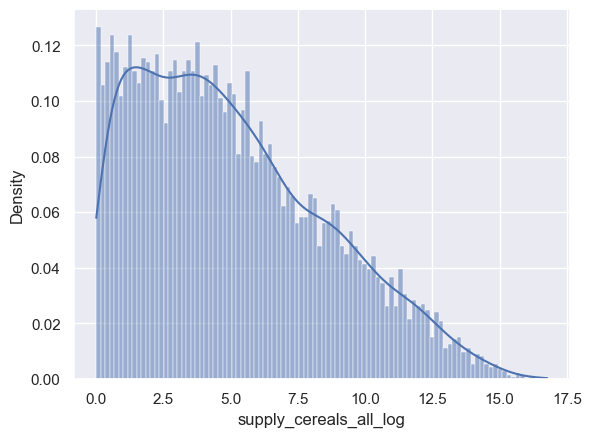

In [202]:
print(y_train.mean())
sns.histplot(x=y_train, kde=True, bins=100, stat='density')

5.163715893579383


<Axes: xlabel='supply_cereals_all_log', ylabel='Density'>

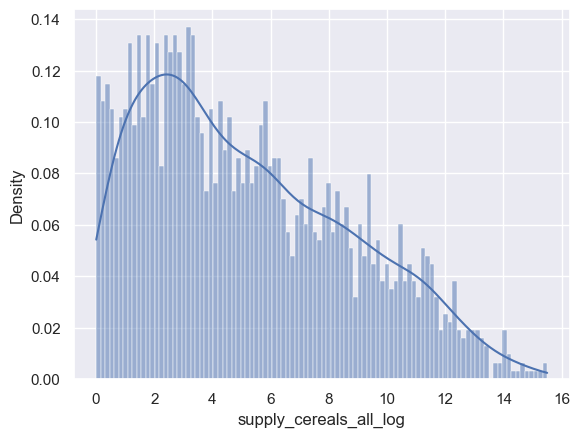

In [203]:
print(y_test.mean())
sns.histplot(x=y_test, kde=True, bins=100, stat='density')

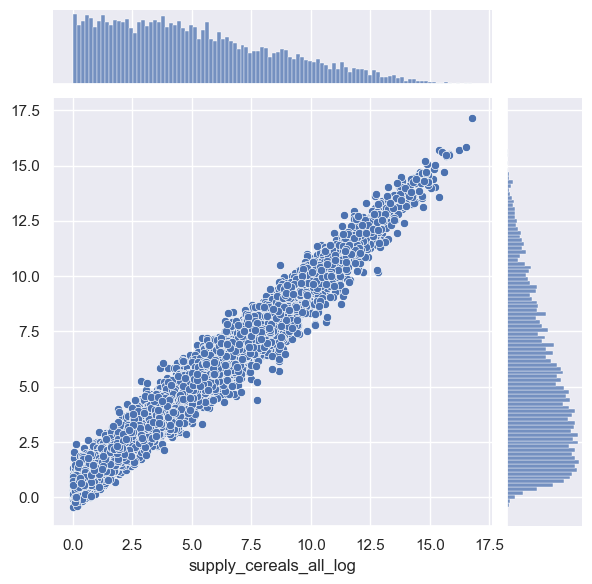

In [204]:
sns.jointplot(x=y_train, y=y_train_pred, marginal_kws=dict(stat='density', bins=100))

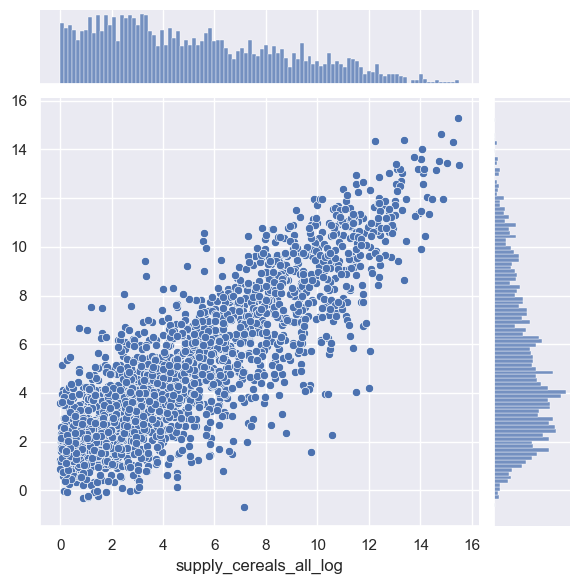

In [205]:
sns.jointplot(x=y_test, y=y_test_pred, marginal_kws=dict(stat='density', bins=100))

In [ ]:
# cereals all

# grad
# train
# r2 train: 0.8573055874554208
# r2 train log: 0.9710093240559441
# test
# r2 test: 0.3176465295089587
# r2 test log: 0.7356141970860598

# rf
# train
# r2 train: 0.011947565498248314
# r2 train log: 0.5759739791148564
# test
# r2 test: 0.015297067342105185
# r2 test log: 0.5496557568115417

# deep learning
# train
# r2 train: 0.15489677254360723
# r2 train log: 0.657607279142613
# test
# r2 test: 0.099285073677816
# r2 test log: 0.6273200656574802

# lin reg
# train
# r2 train: -4.904856186678241e-05
# r2 train log: 0.4241329875365351
# test
# r2 test: 0.0014695738300464223
# r2 test log: 0.42781830064446014

# maize

# rice

# wheat

# other cereals

In [258]:
r2_train = []
r2_log_train = []

r2_test = []
r2_log_test = []

for i in range(5):
    print(i)

    train = train_dfs[i]
    test = test_dfs[i]
    
    train =  train[train['supply_cereals_all']>1].reset_index(drop=True)
    test = test[test['supply_cereals_all']>1].reset_index(drop=True)
    
    X_train = train[X_cols2]
    y_train = train[y_col2]
    
    X_test = test[X_cols2]
    y_test = test[y_col2]

    # hist and rf
    # preprocessor = ColumnTransformer(
    #     transformers=[('scaler', preprocessing.StandardScaler(), to_transform2)],
    #     remainder='passthrough'
    # )

    # reg = HistGradientBoostingRegressor(
    #             l2_regularization=10, 
    #             # loss='gamma',
    #             max_iter=1000,
    #             max_depth=10,
    #             max_features=0.4,
    #             min_samples_leaf=100,
    #             # categorical_features=['from_region_0','from_region_0', 'from_region_2', 'from_region_3', 'from_region_4', 'from_region_5',
    #             #                       'to_region_0', 'to_region_1', 'to_region_2', 'to_region_3',
    #             #                       'to_region_4', 'to_region_5'],
    #            )

    # reg = RandomForestRegressor(
    #     n_estimators= 200,
    #     max_depth=5
    #    )
    
    # pipe_reg = Pipeline([                                                                                        
    #         ('scale', preprocessor),
    #         ('reg', reg)
    # ])

    # pipe_reg.fit(X_train, y_train)
    # y_train_pred = pipe_reg.predict(X_train)
    # y_test_pred = pipe_reg.predict(X_test)

    # deep learning
    # params = {'lr': 0.01,
    #      'batch_size': 256,
    #      'epochs': 500,
    #      'optimizer': tf.keras.optimizers.Adam,
    #      'dropout': 0.2,
    #      'dense_neurons': 8
    #     }
    
    # lr = params['lr']
    # # decay = params['decay']
    # batch_size = params['batch_size']
    # epochs = params['epochs']
    # optimizer = params['optimizer']
    # dropout = params['dropout']
    # dense_neurons = params['dense_neurons']
    
    # metrics = [tfa.metrics.RSquare()]
    # activation='relu'
    
    # model = keras.Sequential()
    # model.add(layers.BatchNormalization())
    # model.add(layers.Input(shape=(X_train.shape[1])))
    # model.add(layers.Dense(dense_neurons, activation=activation)) # hidden layer 1
    # model.add(layers.Dropout(dropout))
    # model.add(layers.Dense(dense_neurons, activation=activation)) # hidden layer 2
    # model.add(layers.Dropout(dropout))
    # model.add(layers.Dense(1, activation='softplus')) 
    
    # model.compile(loss='mean_squared_error', optimizer=optimizer(learning_rate=lr), metrics=metrics)
    
    # model.fit(X_train, y_train, 
    #           epochs=epochs, 
    #           batch_size=batch_size, 
    #           verbose=0)
    
    # y_train_pred = model.predict(X_train)
    # y_test_pred = model.predict(X_test)

    # lin reg
    fml = f"{y_col2} ~ " + " + ".join(X_cols1) + " - 1"
    mod = sm.OLS.from_formula(fml, data=train)
    res = mod.fit()
    y_train_pred = res.predict(train)
    y_test_pred = res.predict(test)
    
    r2_log_train.append(r2_score(y_train, y_train_pred))
    r2_train.append(r2_score(np.exp(y_train), np.exp(y_train_pred)))

    r2_log_test.append(r2_score(y_test, y_test_pred))
    r2_test.append(r2_score(np.exp(y_test), np.exp(y_test_pred)))

0
1
2
3
4


In [254]:
print('grad')

print('train')
print(f'r2 train: {np.mean(r2_train)}')
print(f'r2 train log: {np.mean(r2_log_train)}')

print('test')
print(f'r2 test: {np.mean(r2_test)}')
print(f'r2 test log: {np.mean(r2_log_test)}')

grad
train
r2 train: 0.8573055874554208
r2 train log: 0.9710093240559441
test
r2 test: 0.3176465295089587
r2 test log: 0.7356141970860598


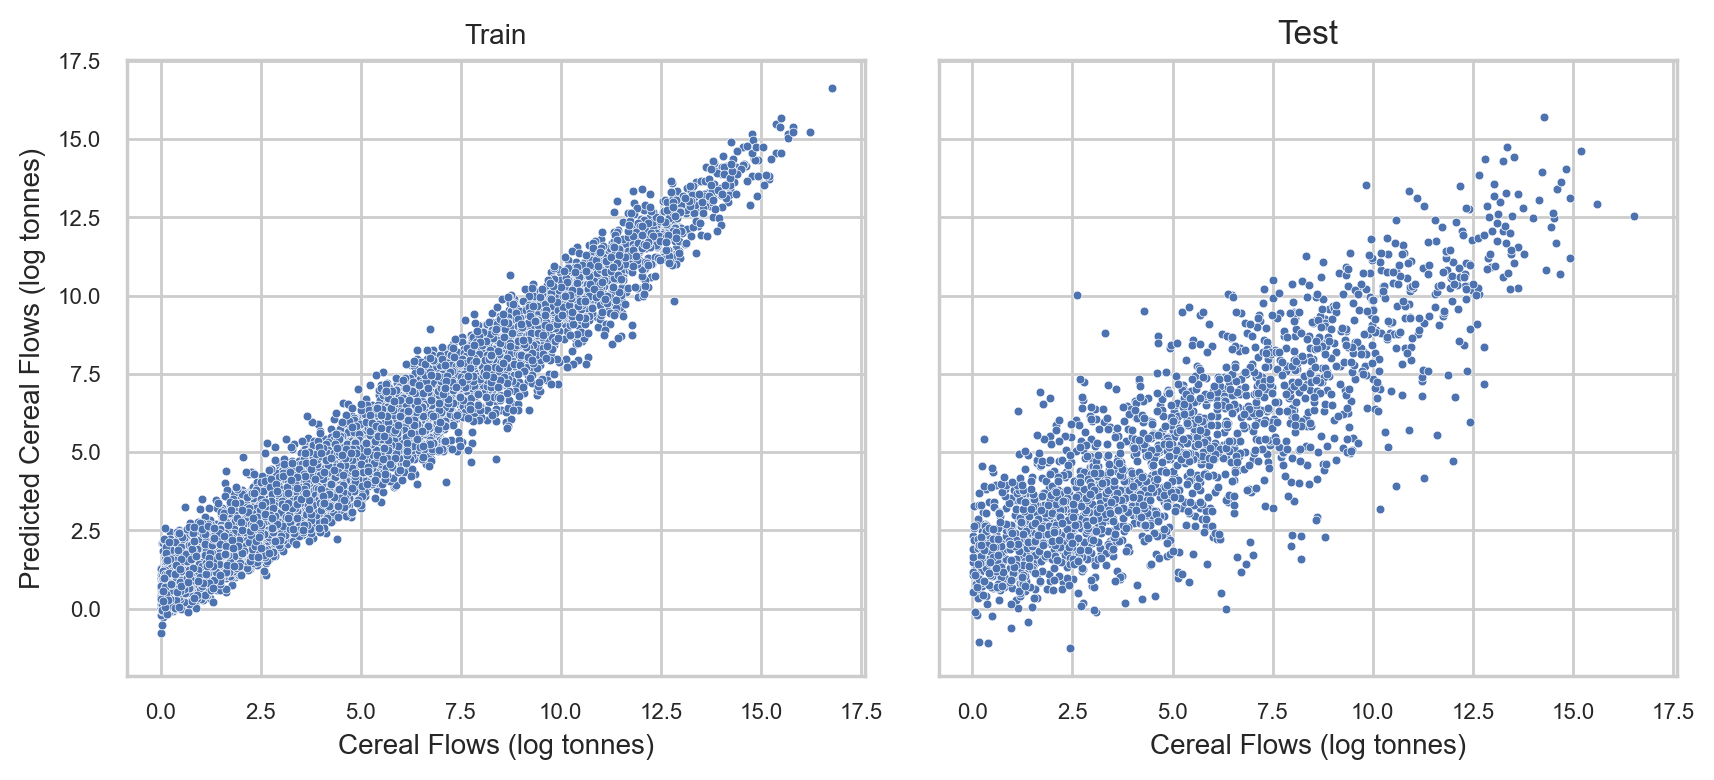

In [250]:
# cereals all
sns.set_style("whitegrid")
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=200, sharex=True, sharey=True)

ax = axs[0]
g = sns.scatterplot(ax=ax, x=y_train, y=y_train_pred, s=10)
ax.set_xlabel("Cereal Flows (log tonnes)", fontsize=10)
ax.set_ylabel("Predicted Cereal Flows (log tonnes)", fontsize=10)
ax.set_title("Train", fontsize=10) 
ax.tick_params(axis='both', which='major', labelsize=8)
# ax.set_xlim([0,16])
# ax.set_ylim([0,16])

ax = axs[1]
g = sns.scatterplot(ax=ax, x=y_test, y=y_test_pred, s=10)
ax.set_xlabel("Cereal Flows (log tonnes)", fontsize=10)
ax.set_ylabel("Predicted Cereal Flows (log tonnes)", fontsize=10)
ax.set_title("Test", fontsize=12) 
ax.tick_params(axis='both', which='major', labelsize=8)
# ax.set_xlim([0,16])
# ax.set_ylim([0,16])


g.figure.subplots_adjust(wspace=.1)

In [252]:
print('rf')

print('train')
print(f'r2 train: {np.mean(r2_train)}')
print(f'r2 train log: {np.mean(r2_log_train)}')

print('test')
print(f'r2 test: {np.mean(r2_test)}')
print(f'r2 test log: {np.mean(r2_log_test)}')

rf
train
r2 train: 0.011947565498248314
r2 train log: 0.5759739791148564
test
r2 test: 0.015297067342105185
r2 test log: 0.5496557568115417


In [256]:
print('deep learning')

print('train')
print(f'r2 train: {np.mean(r2_train)}')
print(f'r2 train log: {np.mean(r2_log_train)}')

print('test')
print(f'r2 test: {np.mean(r2_test)}')
print(f'r2 test log: {np.mean(r2_log_test)}')

deep learning
train
r2 train: 0.15489677254360723
r2 train log: 0.657607279142613
test
r2 test: 0.099285073677816
r2 test log: 0.6273200656574802


In [259]:
print('lin reg')

print('train')
print(f'r2 train: {np.mean(r2_train)}')
print(f'r2 train log: {np.mean(r2_log_train)}')

print('test')
print(f'r2 test: {np.mean(r2_test)}')
print(f'r2 test log: {np.mean(r2_log_test)}')

lin reg
train
r2 train: -4.904856186678241e-05
r2 train log: 0.4241329875365351
test
r2 test: 0.0014695738300464223
r2 test log: 0.42781830064446014


#### train on all data

In [37]:
y_col1 = f'supply_cereals_all_exists'

X_train = df_country[X_cols1]
y_train = df_country[y_col1]

clf = HistGradientBoostingClassifier(
    max_iter=5000, 
    class_weight='balanced', 
    min_samples_leaf=100, 
    max_features=0.8,
    # categorical_features=['from_region_0','from_region_0', 'from_region_2', 'from_region_3', 'from_region_4', 'from_region_5',
    #    'to_region_0', 'to_region_1', 'to_region_2', 'to_region_3',
    #    'to_region_4', 'to_region_5'],
    # early_stopping=True, 
    # scoring='f1'
)

preprocessor = ColumnTransformer(
    transformers=[('scaler', preprocessing.StandardScaler(), to_transform1)],
    remainder='passthrough'
)

pipe_clf = Pipeline([                                                                                        
        # ('scale', preprocessor),
        ('clf', clf)
])

pipe_clf.fit(X_train, y_train)

python(23839) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Pipeline(steps=[('clf',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                max_features=0.8, max_iter=5000,
                                                min_samples_leaf=100))])

In [38]:
hp_cereals_all = {'reg__l2_regularization': 10, 'reg__max_depth': 10, 'reg__max_features': 0.4, 'reg__max_iter': 1000, 'reg__min_samples_leaf': 100}
hp_maize = {'reg__l2_regularization':3, 'reg__max_depth':5, 'reg__max_features':0.8, 'reg__max_iter':1000, 'reg__min_samples_leaf':100}
hp_wheat = {'reg__l2_regularization': 100, 'reg__max_depth': 10, 'reg__max_features': 0.4, 'reg__max_iter': 1000, 'reg__min_samples_leaf': 100}
hp_rice = {'reg__l2_regularization':3, 'reg__max_depth':5, 'reg__max_features':0.8, 'reg__max_iter':1000, 'reg__min_samples_leaf':100}
hp_other_cereals = {'reg__l2_regularization':3, 'reg__max_depth':5, 'reg__max_features':0.4, 'reg__max_iter':2000, 'reg__min_samples_leaf':100}

In [39]:
crop = 'cereals_all'

train = df_country[df_country[f'supply_{crop}']>1].reset_index(drop=True)

train = pd.concat([train, pd.get_dummies(train['from_region'].astype('int32').astype('category'), prefix = 'from_region')], axis=1)
train = pd.concat([train, pd.get_dummies(train['to_region'].astype('int32').astype('category'), prefix = 'to_region')], axis=1)

y_col2 = f'supply_{crop}_log'

X_train = train[X_cols2]
y_train = train[y_col2]

preprocessor = ColumnTransformer(
    transformers=[('scaler', preprocessing.StandardScaler(), to_transform2)],
    remainder='passthrough'
)

pipe_reg_cereals_all = Pipeline([                                                                                        
        ('scale', preprocessor),
        ('reg', HistGradientBoostingRegressor())
])

pipe_reg_cereals_all.set_params(**hp_cereals_all)

pipe_reg_cereals_all.fit(X_train, y_train)

Pipeline(steps=[('scale',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  [])])),
                ('reg',
                 HistGradientBoostingRegressor(l2_regularization=10,
                                               max_depth=10, max_features=0.4,
                                               max_iter=1000,
                                               min_samples_leaf=100))])

In [40]:
crop = 'maize'

train = df_country[df_country[f'supply_{crop}']>1].reset_index(drop=True)

train = pd.concat([train, pd.get_dummies(train['from_region'].astype('int32').astype('category'), prefix = 'from_region')], axis=1)
train = pd.concat([train, pd.get_dummies(train['to_region'].astype('int32').astype('category'), prefix = 'to_region')], axis=1)

y_col2 = f'supply_{crop}_log'

X_train = train[X_cols2]
y_train = train[y_col2]

preprocessor = ColumnTransformer(
    transformers=[('scaler', preprocessing.StandardScaler(), to_transform2)],
    remainder='passthrough'
)

pipe_reg_maize = Pipeline([                                                                                        
        ('scale', preprocessor),
        ('reg', HistGradientBoostingRegressor())
])

pipe_reg_maize.set_params(**hp_maize)

pipe_reg_maize.fit(X_train, y_train)

Pipeline(steps=[('scale',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  [])])),
                ('reg',
                 HistGradientBoostingRegressor(l2_regularization=3, max_depth=5,
                                               max_features=0.8, max_iter=1000,
                                               min_samples_leaf=100))])

In [41]:
crop = 'wheat'

train = df_country[df_country[f'supply_{crop}']>1].reset_index(drop=True)

train = pd.concat([train, pd.get_dummies(train['from_region'].astype('int32').astype('category'), prefix = 'from_region')], axis=1)
train = pd.concat([train, pd.get_dummies(train['to_region'].astype('int32').astype('category'), prefix = 'to_region')], axis=1)

y_col2 = f'supply_{crop}_log'

X_train = train[X_cols2]
y_train = train[y_col2]

preprocessor = ColumnTransformer(
    transformers=[('scaler', preprocessing.StandardScaler(), to_transform2)],
    remainder='passthrough'
)

pipe_reg_wheat = Pipeline([                                                                                        
        ('scale', preprocessor),
        ('reg', HistGradientBoostingRegressor())
])

pipe_reg_wheat.set_params(**hp_wheat)

pipe_reg_wheat.fit(X_train, y_train)

Pipeline(steps=[('scale',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  [])])),
                ('reg',
                 HistGradientBoostingRegressor(l2_regularization=100,
                                               max_depth=10, max_features=0.4,
                                               max_iter=1000,
                                               min_samples_leaf=100))])

In [42]:
crop = 'rice'

train = df_country[df_country[f'supply_{crop}']>1].reset_index(drop=True)

train = pd.concat([train, pd.get_dummies(train['from_region'].astype('int32').astype('category'), prefix = 'from_region')], axis=1)
train = pd.concat([train, pd.get_dummies(train['to_region'].astype('int32').astype('category'), prefix = 'to_region')], axis=1)

y_col2 = f'supply_{crop}_log'

X_train = train[X_cols2]
y_train = train[y_col2]

preprocessor = ColumnTransformer(
    transformers=[('scaler', preprocessing.StandardScaler(), to_transform2)],
    remainder='passthrough'
)

pipe_reg_rice = Pipeline([                                                                                        
        ('scale', preprocessor),
        ('reg', HistGradientBoostingRegressor())
])

pipe_reg_rice.set_params(**hp_rice)

pipe_reg_rice.fit(X_train, y_train)

Pipeline(steps=[('scale',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  [])])),
                ('reg',
                 HistGradientBoostingRegressor(l2_regularization=3, max_depth=5,
                                               max_features=0.8, max_iter=1000,
                                               min_samples_leaf=100))])

In [43]:
crop = 'other_cereals'

train = df_country[df_country[f'supply_{crop}']>1].reset_index(drop=True)

train = pd.concat([train, pd.get_dummies(train['from_region'].astype('int32').astype('category'), prefix = 'from_region')], axis=1)
train = pd.concat([train, pd.get_dummies(train['to_region'].astype('int32').astype('category'), prefix = 'to_region')], axis=1)

y_col2 = f'supply_{crop}_log'

X_train = train[X_cols2]
y_train = train[y_col2]

preprocessor = ColumnTransformer(
    transformers=[('scaler', preprocessing.StandardScaler(), to_transform2)],
    remainder='passthrough'
)

pipe_reg_other_cereals = Pipeline([                                                                                        
        ('scale', preprocessor),
        ('reg', HistGradientBoostingRegressor())
])

pipe_reg_other_cereals.set_params(**hp_other_cereals)

pipe_reg_other_cereals.fit(X_train, y_train)

Pipeline(steps=[('scale',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  [])])),
                ('reg',
                 HistGradientBoostingRegressor(l2_regularization=3, max_depth=5,
                                               max_features=0.4, max_iter=2000,
                                               min_samples_leaf=100))])

#### predict on admin level data

In [44]:
# degrees make predictions larger, so keep them. try domestic with 2 sets of degrees, see which ones work better
# degrees separately for domestic arent helpful. either use all at country scale or all at subnat scale but with feature scaling (?) (latter is better)
# check what's happening in usa when predictions are larger

# column transformation [log vs scaler] + threshold for classifier + choice of features + crops + rf/deep learning/hist (redo tuning)
# whichever classifier keeps most countries is best, whichever regreor has least bias/variance issues and best admin predictions is best

df_admin.shape

(12412218, 149)

In [45]:
trade_exists = pipe_clf.predict_proba(df_admin[X_cols1])
df_admin['trade_exists'] = trade_exists[:,1]
print(df_admin[df_admin['trade_exists']>0.4].shape)

(558211, 150)


In [46]:
domestic = df_admin[(df_admin['from_iso3']==df_admin['to_iso3'])]
international = df_admin[(df_admin['from_iso3']!=df_admin['to_iso3'])]

In [47]:
domestic[domestic['trade_exists']>0.4].shape

(57705, 150)

In [48]:
domestic[domestic['trade_exists']>0.4]['from_iso3'].nunique()

147

In [49]:
master_df[master_df['iso3'].isin(set(
    master_df['iso3'].unique().tolist()).difference(set(domestic[domestic['trade_exists']>0.4]['from_iso3'].unique().tolist())))]

,iso3,wheat_outflows,wheat_inflows,wheat_exports,wheat_imports,wheat_prod,wheat_cons_trade,wheat_cons_flows,maize_outflows,maize_inflows,maize_exports,maize_imports,maize_prod,maize_cons_trade,maize_cons_flows,rye_outflows,rye_inflows,rye_exports,rye_imports,rye_prod,rye_cons_trade,rye_cons_flows,barley_outflows,barley_inflows,barley_exports,barley_imports,barley_prod,barley_cons_trade,barley_cons_flows,oats_outflows,oats_inflows,oats_exports,oats_imports,oats_prod,oats_cons_trade,oats_cons_flows,sorghum_outflows,sorghum_inflows,Sorghum_exports,sorghum_imports,sorghum_prod,sorghum_cons_trade,sorghum_cons_flows,rice_outflows,rice_inflows,rice_exports,rice_imports,rice_prod,rice_cons_trade,rice_cons_flows,buckwheat_outflows,buckwheat_inflows,buckwheat_exports,buckwheat_imports,buckwheat_prod,buckwheat_cons_trade,buckwheat_cons_flows,millet_outflows,millet_inflows,millet_exports,millet_imports,millet_prod,millet_cons_trade,millet_cons_flows,quinoa_outflows,quinoa_inflows,quinoa_exports,quinoa_imports,quinoa_prod,quinoa_cons_trade,quinoa_cons_flows,other_cereals_outflows,other_cereals_inflows,other_cereals_exports,other_cereals_imports,other_cereals_prod,other_cereals_cons_trade,other_cereals_cons_flows,cereals_all_outflows,cereals_all_inflows,cereals_all_exports,cereals_all_imports,cereals_all_prod,cereals_all_cons_trade,cereals_all_cons_flows
6,ATG,0.000000,6.262018,11446.004,6.446,0.000,-11439.558,6.262018,17.196410,4.569324,13112.876,53.560,26.920,-13032.396,14.292914,0.0,0.000000,0.000,0.000,0.000,0.000,0.000000,0.000000,0.010000,0.000,0.010,0.000,0.010,0.010000,0.0,106.429984,0.002,106.432,0.0,106.430,106.429984,0.00,0.000000,0.000,0.000,0.000,0.000,0.000000,0.000000,262.511858,6582.2,1410.6,0.0000,-5.171600e+03,2.625119e+02,0.0,0.103994,0.000,0.462,0.0,0.462,0.103994,0.0,0.000000,0.000,0.000,0.000,0.000,0.000000,0.0,0.000000,0.000,0.000,0.0,0.000,0.000000,0.000000,12.648244,2.002,36.994,0.000,34.992,12.648244,17.196410,3.925354e+02,31143.084,1614.504,26.9200,-2.950166e+04,4.022590e+02
16,BHR,0.000000,114001.965230,1.168,114003.312,0.000,114002.144,114001.965230,0.000000,17641.740612,2.164,17804.564,0.000,17802.400,17641.740612,0.0,0.288651,0.006,1.496,0.000,1.490,0.288651,0.000000,1921.308893,0.000,1921.412,0.000,1921.412,1921.308893,0.0,939.342248,0.922,943.044,0.0,942.122,939.342248,0.00,851.925103,0.000,853.468,0.000,853.468,851.925103,0.000000,75742.133051,44.6,75786.8,0.0000,7.574220e+04,7.574213e+04,0.0,10.752646,0.004,31.280,0.0,31.276,10.752646,0.0,1547.989364,0.000,1548.370,0.000,1548.370,1547.989364,0.0,50.492033,0.384,51.354,0.0,50.970,50.492033,0.000000,71.972722,0.474,137.068,0.000,136.594,71.972722,0.000000,2.127799e+05,49.722,213082.168,0.0000,2.130324e+05,2.127799e+05
17,BHS,0.000000,23.694000,0.000,23.694,0.000,23.694,23.694000,132.664000,1381.076226,7293.962,1866.670,664.352,-4762.940,1912.764226,0.0,2.582000,0.000,2.582,0.000,2.582,2.582000,0.000000,5.056000,0.000,5.056,0.000,5.056,5.056000,0.0,501.776788,0.000,580.712,0.0,580.712,501.776788,0.00,0.005999,0.000,0.006,0.000,0.006,0.005999,0.000000,7548.599847,0.0,7548.6,0.0000,7.548600e+03,7.548600e+03,0.0,0.067994,0.000,0.068,0.0,0.068,0.067994,0.0,0.000000,0.000,0.000,0.000,0.000,0.000000,0.0,1.727827,0.000,1.728,0.0,1.728,1.727827,0.000000,8.642343,0.000,20.196,0.000,20.196,8.642343,132.664000,9.473229e+03,7293.962,10049.312,664.3520,3.419702e+03,1.000492e+04
23,BRB,0.000000,15865.737877,1398.790,17264.420,0.000,15865.630,15865.737877,0.085915,27645.056731,20.298,27665.268,72.212,27717.182,27717.182816,0.0,0.900000,0.000,0.900,0.000,0.900,0.900000,0.000000,35.482041,0.410,35.892,0.000,35.482,35.482041,0.0,580.233144,0.558,580.796,0.0,580.238,580.233144,0.00,0.000000,0.000,0.000,0.000,0.000,0.000000,0.000000,4887.243855,0.8,4926.8,0.0000,4.926000e+03,4.887244e+03,0.0,13.208000,0.000,13.208,0.0,13.208,13.208000,0.0,0.039996,0.000,0.040,0.000,0.040,0.039996,0.0,8.209179,0.000,8.210,0.0,8.210,8.209179,0.000000,66.099269,0.006,111.300,0.000,111.294,66.099269

In [50]:
international[international['trade_exists']>0.4].shape

(500506, 150)

In [90]:
X = international[international['trade_exists']>0.1][['from_iso3', 'to_iso3', 'trade_exists']].drop_duplicates(subset=['from_iso3', 'to_iso3']).merge(
    df_country[df_country['supply_cereals_all_exists']==1], how='outer')

In [91]:
X.shape

(12970, 261)

In [92]:
# falsely prediced country links
print(X[X['supply_cereals_all'].isna()].shape)

(2985, 261)


In [93]:
# country links not captured
print(X[X['trade_exists'].isna()].shape)
print(X[X['trade_exists'].isna()]['supply_cereals_all'].describe())
X[X['trade_exists'].isna()].sort_values('supply_cereals_all').tail(10)[['from_iso3', 'to_iso3', 'supply_cereals_all',
                                                                 'supply_wheat', 'supply_maize', 'supply_rice',
                                                                 'supply_other_cereals']]

(2061, 261)
count      2061.000000
mean       1336.398027
std       10422.994650
min           1.000328
25%           2.882733
50%          10.340873
75%          71.658813
max      248293.994893
Name: supply_cereals_all, dtype: float64


,from_iso3,to_iso3,supply_cereals_all,supply_wheat,supply_maize,supply_rice,supply_other_cereals
12353,ROU,NZL,67627.820922,0.000000,67627.238241,0.000000,0.000000
11398,EST,DZA,70158.550833,41175.094444,0.000000,0.000000,28983.454547
11707,MDA,IDN,71633.121672,71547.950306,0.000000,0.000000,84.151442
11334,MDA,CYP,74436.380051,7166.597369,51211.403949,0.000000,16058.372894
12092,URY,MEX,82509.287945,0.000000,5.369369,82503.840971,0.000000
11861,MEX,KEN,85939.637470,2.082897,85935.735234,0.000000,1.777225
11769,URY,IRQ,102437.631588,0.000000,0.000000,102437.516538,0.000000
12404,URY,PER,170630.176086,0.000000,77.241812,170472.798724,79.940857
12913,ZAF,VNM,231389.355363,0.000000,231358.202665,0.000000,31.090883
12817,ZAF,TWN,248293.994893,12.780862,248234.000729,0.000000,47.155205


In [94]:
X[(X['trade_exists'].isna()) & (X['supply_cereals_all']>1000)].shape

(168, 261)

In [95]:
# country links captured correctly
print(X[X.notnull().all(axis=1)].shape)
print(X[X.notnull().all(axis=1)]['supply_cereals_all'].describe())
X[X.notnull().all(axis=1)].sort_values('supply_cereals_all').tail(10)[['from_iso3', 'to_iso3', 'supply_cereals_all',
                                                                 'supply_wheat', 'supply_maize', 'supply_rice',
                                                                 'supply_other_cereals']]

(7920, 261)
count    7.920000e+03
mean     5.688620e+04
std      4.356849e+05
min      1.000439e+00
25%      1.652004e+01
50%      1.756350e+02
75%      3.476131e+03
max      1.915667e+07
Name: supply_cereals_all, dtype: float64


,from_iso3,to_iso3,supply_cereals_all,supply_wheat,supply_maize,supply_rice,supply_other_cereals
5460,USA,KOR,5.419977e+06,1.424782e+06,3.862788e+06,121540.214227,1.086738e+04
2132,USA,COL,5.422900e+06,5.701368e+05,4.768612e+06,78377.834945,5.773544e+03
1247,ARG,BRA,5.990197e+06,5.032543e+06,3.285797e+05,81078.904787,5.479956e+05
10532,ARG,VNM,6.465872e+06,3.637912e+05,6.078972e+06,3.400889,2.310496e+04
1790,UKR,CHN,6.470786e+06,4.618752e+03,4.962243e+06,0.000000,1.503924e+06
9909,RUS,TUR,7.226723e+06,5.824087e+06,9.180393e+05,22467.665669,4.621285e+05
2956,RUS,EGY,7.339801e+06,7.331702e+06,3.191089e+03,116.446998,4.791891e+03
1791,USA,CHN,1.116676e+07,1.380939e+06,5.633837e+06,1997.215976,4.149982e+06
5145,USA,JPN,1.507073e+07,2.557127e+06,1.199062e+07,274770.682740,2.482082e+05
6397,USA,MEX,1.915667e+07,2.967657e+06,1.530522e+07,482423.515892,4.013713e+05


In [96]:
international_sub = international.merge(df_country[df_country['supply_cereals_all']>1][['from_iso3', 'to_iso3']], how='right')

In [58]:
international_sub['trade_exists'].describe()

count    5.003780e+06
mean     1.067904e-01
std      2.069965e-01
min      4.859996e-06
25%      3.402673e-03
50%      1.376295e-02
75%      8.589986e-02
max      9.991656e-01
Name: trade_exists, dtype: float64

In [59]:
international_sub[['from_iso3', 'to_iso3']].drop_duplicates().shape

(9985, 2)

In [60]:
df_sub = pd.concat([international_sub, domestic], ignore_index=True)

In [61]:
df_sub = df_sub.merge(emb_df, left_on='from_iso3', right_on='iso3').drop('iso3', axis=1).rename(columns={
    'dim_0': 'from_dim_0', 
    'dim_1': 'from_dim_1', 
    'dim_2': 'from_dim_2', 
    'dim_3': 'from_dim_3', 
    'dim_4': 'from_dim_4', 
    'dim_5': 'from_dim_5', 
    'dim_6': 'from_dim_6', 
    'dim_7': 'from_dim_7',
    'dim_8': 'from_dim_8', 
    'dim_9': 'from_dim_9', 
    'dim_10': 'from_dim_10', 
    'dim_11': 'from_dim_11', 
    'dim_12': 'from_dim_12', 
    'dim_13': 'from_dim_13', 
    'dim_14': 'from_dim_14',
    'dim_15': 'from_dim_15',
    'degree': 'from_degree',
    'in_degree': 'from_in_degree',
    'out_degree': 'from_out_degree'
})

df_sub = df_sub.merge(emb_df, left_on='to_iso3', right_on='iso3').drop('iso3', axis=1).rename(columns={
    'dim_0': 'to_dim_0', 
    'dim_1': 'to_dim_1', 
    'dim_2': 'to_dim_2', 
    'dim_3': 'to_dim_3', 
    'dim_4': 'to_dim_4', 
    'dim_5': 'to_dim_5', 
    'dim_6': 'to_dim_6', 
    'dim_7': 'to_dim_7',
    'dim_8': 'to_dim_8', 
    'dim_9': 'to_dim_9', 
    'dim_10': 'to_dim_10', 
    'dim_11': 'to_dim_11', 
    'dim_12': 'to_dim_12', 
    'dim_13': 'to_dim_13', 
    'dim_14': 'to_dim_14',
    'dim_15': 'to_dim_15',
    'degree': 'to_degree',
    'in_degree': 'to_in_degree',
    'out_degree': 'to_out_degree'
})

In [62]:
df_sub['cereals_all_pred'] = np.exp(pipe_reg_cereals_all.predict(df_sub[X_cols2]))
df_sub['maize_pred'] = np.exp(pipe_reg_maize.predict(df_sub[X_cols2]))
df_sub['wheat_pred'] = np.exp(pipe_reg_wheat.predict(df_sub[X_cols2]))
df_sub['rice_pred'] = np.exp(pipe_reg_rice.predict(df_sub[X_cols2]))
df_sub['other_cereals_pred'] = np.exp(pipe_reg_other_cereals.predict(df_sub[X_cols2]))

In [63]:
df_sub = df_sub.merge(df_country[df_country['supply_maize']>1][['from_iso3', 'to_iso3', 'supply_maize']], how='left')
df_sub = df_sub.merge(df_country[df_country['supply_wheat']>1][['from_iso3', 'to_iso3', 'supply_wheat']], how='left')
df_sub = df_sub.merge(df_country[df_country['supply_rice']>1][['from_iso3', 'to_iso3', 'supply_rice']], how='left')
df_sub = df_sub.merge(df_country[df_country['supply_other_cereals']>1][['from_iso3', 'to_iso3', 'supply_other_cereals']], how='left')

In [64]:
df_sub.loc[(df_sub['supply_maize'].isna()) & (df_sub['from_iso3']!=df_sub['to_iso3']), 'maize_pred'] = 0
df_sub.loc[(df_sub['supply_wheat'].isna()) & (df_sub['from_iso3']!=df_sub['to_iso3']), 'wheat_pred'] = 0
df_sub.loc[(df_sub['supply_rice'].isna()) & (df_sub['from_iso3']!=df_sub['to_iso3']), 'rice_pred'] = 0
df_sub.loc[(df_sub['supply_other_cereals'].isna()) & (df_sub['from_iso3']!=df_sub['to_iso3']), 'other_cereals_pred'] = 0

In [65]:
df_sub = df_sub.drop(['supply_maize', 'supply_wheat', 'supply_rice', 'supply_other_cereals'], axis=1)

In [66]:
df_sub[['cereals_all_pred', 'maize_pred', 'wheat_pred', 'rice_pred', 'other_cereals_pred']].describe()

,cereals_all_pred,maize_pred,wheat_pred,rice_pred,other_cereals_pred
count,5.132775e+06,5.132775e+06,5.132775e+06,5.132775e+06,5.132775e+06
mean,3.723351e+02,2.278112e+01,4.798307e+01,1.481547e+02,2.713732e+01
std,3.845945e+03,1.204112e+03,4.753265e+02,1.426292e+03,3.429050e+02
min,1.739612e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.128373e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.049399e+01,0.000000e+00,8.537009e-01,1.411546e+00,1.843653e+00
75%,1.316381e+02,3.950272e+00,1.020102e+01,1.560348e+01,8.550850e+00
max,2.081586e+06,9.551344e+05,2.206884e+05,4.213536e+05,2.112305e+05


In [66]:
df_sub[['cereals_all_pred', 'maize_pred', 'wheat_pred', 'rice_pred', 'other_cereals_pred']].describe()

,cereals_all_pred,maize_pred,wheat_pred,rice_pred,other_cereals_pred
count,5.132775e+06,5.132775e+06,5.132775e+06,5.132775e+06,5.132775e+06
mean,2.321053e+01,9.916110e+00,7.164589e+00,8.366823e+00,7.623489e+00
std,1.142694e+03,8.156425e+02,1.168235e+02,8.330086e+01,1.231757e+02
min,8.236977e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.713878e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.251532e+00,0.000000e+00,3.213132e-01,6.233095e-01,7.490606e-01
75%,7.234187e+00,1.521894e+00,2.182666e+00,3.897214e+00,2.723215e+00
max,9.970988e+05,1.056747e+06,7.996857e+04,3.311927e+04,9.660265e+04


In [67]:
5.132775e+06*2.321053e+01

119134428.12075

In [68]:
5.132775e+06*(9.916110e+00+7.164589e+00+8.366823e+00+7.623489e+00)

169746058.48552498

<Axes: xlabel='cereals_all_pred'>

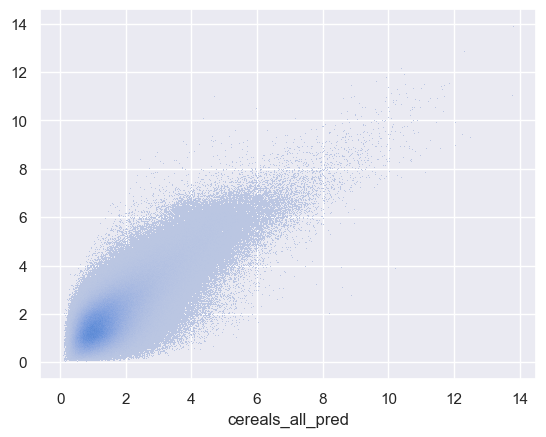

In [69]:
sns.histplot(x=np.log(df_sub['cereals_all_pred']+1), y=np.log(df_sub['maize_pred']+df_sub['wheat_pred']
                                                              +df_sub['rice_pred']+df_sub['other_cereals_pred']+1))

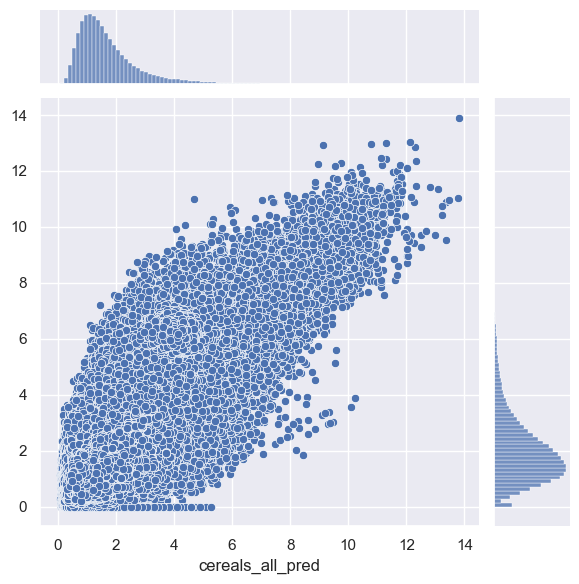

In [70]:
sns.jointplot(x=np.log(df_sub['cereals_all_pred']+1), y=np.log(df_sub['maize_pred']+df_sub['wheat_pred']
                                                              +df_sub['rice_pred']+df_sub['other_cereals_pred']+1),
             marginal_kws=dict(stat='density', bins=100))

In [69]:
X = df_sub[(df_sub['from_iso3']!=df_sub['to_iso3'])].groupby(['from_iso3', 'to_iso3'])[[
    'cereals_all_pred', 'maize_pred', 'wheat_pred', 'rice_pred', 'other_cereals_pred']].sum().reset_index().merge(
    df_country[df_country['supply_cereals_all_exists']==1], how='outer')

In [70]:
X.shape

(9985, 265)

In [71]:
X[X['cereals_all_pred']==0].head()

,from_iso3,to_iso3,cereals_all_pred,maize_pred,wheat_pred,rice_pred,other_cereals_pred,freight_USD_t,transport_USD_t,time_h,distance_km,border_USD_t,customs_cost,mode,Pref_Applied_AVE,supply_wheat,supply_wheat_exists,trade_Wheat,trade_Wheat_exists,supply_maize,supply_maize_exists,trade_Maize (corn),trade_Maize (corn)_exists,supply_Rye,supply_Rye_exists,trade_Rye,trade_Rye_exists,supply_Barley,supply_Barley_exists,trade_Barley,trade_Barley_exists,supply_Oats,supply_Oats_exists,trade_Oats,trade_Oats_exists,supply_Sorghum,supply_Sorghum_exists,trade_Sorghum,trade_Sorghum_exists,supply_rice,supply_rice_exists,"trade_Rice, paddy (rice milled equivalent)","trade_Rice, paddy (rice milled equivalent)_exists",supply_Buckwheat,supply_Buckwheat_exists,trade_Buckwheat,trade_Buckwheat_exists,supply_Millet,supply_Millet_exists,trade_Millet,trade_Millet_exists,supply_Quinoa,supply_Quinoa_exists,trade_Quinoa,trade_Quinoa_exists,supply_Cereals n.e.c.,supply_Cereals n.e.c._exists,trade_Cereals n.e.c.,trade_Cereals n.e.c._exists,supply_cereals_all,supply_cereals_all_exists,trade_cereals_all,trade_cereals_all_exists,from_barley_area,from_maize_area,from_millet_area,from_rice_area,from_sorghum_area,from_wheat_area,from_other_cereals_area,from_barley_production,from_maize_production,from_millet_production,from_rice_production,from_sorghum_production,from_wheat_production,from_other_cereals_production,from_buffaloes,from_cattle,from_chickens,from_ducks,from_goats,from_horses,from_pigs,from_sheep,from_pop,from_gdp,from_area,from_built_surface,from_built_volume_total,from_built_volume_nres,to_barley_area,to_maize_area,to_millet_area,to_rice_area,to_sorghum_area,to_wheat_area,to_other_cereals_area,to_barley_production,to_maize_production,to_millet_production,to_rice_production,to_sorghum_production,to_wheat_production,to_other_cereals_production,to_buffaloes,to_cattle,to_chickens,to_ducks,to_goats,to_horses,to_pigs,to_sheep,to_pop,to_gdp,to_area,to_built_surface,to_built_volume_total,to_built_volume_nres,from_region,to_region,freight_USD_t_log,transport_USD_t_log,time_h_log,distance_km_log,border_USD_t_log,customs_cost_log,Pref_Applied_AVE_log,supply_wheat_log,trade_Wheat_log,supply_maize_log,trade_Maize (corn)_log,supply_Rye_log,trade_Rye_log,supply_Barley_log,trade_Barley_log,supply_Oats_log,trade_Oats_log,supply_Sorghum_log,trade_Sorghum_log,supply_rice_log,"trade_Rice, paddy (rice milled equivalent)_log",supply_Buckwheat_log,trade_Buckwheat_log,supply_Millet_log,trade_Millet_log,supply_Quinoa_log,trade_Quinoa_log,supply_Cereals n.e.c._log,trade_Cereals n.e.c._log,supply_cereals_all_log,trade_cereals_all_log,from_barley_area_log,from_maize_area_log,from_millet_area_log,from_rice_area_log,from_sorghum_area_log,from_wheat_area_log,from_other_cereals_area_log,from_barley_production_log,from_maize_production_log,from_millet_production_log,from_rice_production_log,from_sorghum_production_log,from_wheat_production_log,from_other_cereals_production_log,from_buffaloes_log,from_cattle_log,from_chickens_log,from_ducks_log,from_goats_log,from_horses_log,from_pigs_log,from_sheep_log,from_pop_log,from_gdp_log,from_area_log,from_built_surface_log,from_built_volume_total_log,from_built_volume_nres_log,to_barley_area_log,to_maize_area_log,to_millet_area_log,to_rice_area_log,to_sorghum_area_log,to_wheat_area_log,to_other_cereals_area_log,to_barley_production_log,to_maize_production_log,to_millet_production_log,to_rice_production_log,to_sorghum_production_log,to_wheat_production_log,to_other_cereals_production_log,to_buffaloes_log,to_cattle_log,to_chickens_log,to_ducks_log,to_goats_log,to_horses_log,to_pigs_log,to_sheep_log,to_pop_log,to_gdp_log,to_area_log,to_built_surface_log,to_built_volume_total_log,to_built_volume_nres_log,supply_other_cereals,supply_other_cereals_exists,supply_other_cereals_log,barley_ratio,maize_ratio,millet_ratio,rice_ratio,sorghum_ratio,wheat_ratio,other_cereals_ratio,buffaloes_ratio,cattle_ratio,chickens_ratio,ducks_ratio,goats_ratio,horses

In [72]:
X[['from_iso3', 'to_iso3', 
   'cereals_all_pred', 'maize_pred', 'wheat_pred', 'rice_pred', 'other_cereals_pred',
   'supply_cereals_all', 'supply_wheat', 'supply_maize', 'supply_rice', 'supply_other_cereals']].describe()

,cereals_all_pred,maize_pred,wheat_pred,rice_pred,other_cereals_pred,supply_cereals_all,supply_wheat,supply_maize,supply_rice,supply_other_cereals
count,9.985000e+03,9.985000e+03,9.985000e+03,9.985000e+03,9.985000e+03,9.985000e+03,9.985000e+03,9.985000e+03,9.985000e+03,9.985000e+03
mean,1.183265e+05,5.293287e+03,1.453946e+04,6.952758e+04,7.240604e+03,4.543903e+04,1.843714e+04,1.775772e+04,4.261565e+03,4.982307e+03
std,6.911121e+05,7.509532e+04,1.004588e+05,7.144409e+05,3.935963e+04,3.887135e+05,1.661965e+05,2.613230e+05,4.122425e+04,7.616847e+04
min,6.110535e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000328e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.361335e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.966606e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.383941e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.846948e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.111526e+04,1.096030e+03,2.700008e+03,4.141650e+03,2.290998e+03,1.755648e+03,5.500723e+01,1.934180e+01,3.724560e+01,2.416536e+01
max,2.394872e+07,6.276337e+06,5.402184e+06,3.246013e+07,1.119776e+06,1.915667e+07,7.331702e+06,1.530522e+07,1.653919e+06,4.149982e+06


In [73]:
X.sort_values('supply_cereals_all').tail(20)[['from_iso3', 'to_iso3', 
                                              'cereals_all_pred', 'maize_pred', 'wheat_pred', 'rice_pred', 
                                              'other_cereals_pred', 
                                              'supply_cereals_all', 'supply_wheat', 'supply_maize', 'supply_rice',
                                              'supply_other_cereals']]

,from_iso3,to_iso3,cereals_all_pred,maize_pred,wheat_pred,rice_pred,other_cereals_pred,supply_cereals_all,supply_wheat,supply_maize,supply_rice,supply_other_cereals
1563,CAN,USA,3.474341e+06,5.228371e+04,2.900841e+05,0.000000e+00,7.249025e+05,3.431604e+06,1.132874e+06,2.775703e+05,0.000000,2.021159e+06
9092,UKR,ESP,6.000933e+05,2.868746e+04,2.971910e+05,0.000000e+00,1.169350e+05,3.502816e+06,4.812481e+05,2.858446e+06,0.000000,1.631206e+05
1422,CAN,CHN,2.938346e+05,4.208264e+03,3.453112e+04,0.000000e+00,2.250059e+04,3.757635e+06,1.831816e+06,3.709268e+03,0.000000,1.922109e+06
85,ARG,DZA,2.091991e+05,4.940830e+04,1.061480e+05,1.580104e+04,4.623936e+03,3.982302e+06,7.173531e+05,3.264749e+06,197.740453,1.803399e+00
3158,FRA,NLD,1.880221e+06,9.079814e+04,1.304700e+06,3.454393e+03,6.822143e+05,4.007129e+06,2.235702e+06,7.775278e+05,309.415876,9.935899e+05
3087,FRA,DZA,7.880402e+05,2.118994e+04,5.210101e+05,4.374728e+03,1.385575e+05,4.015949e+06,3.865461e+06,3.413385e+03,1.620020,1.470736e+05
3053,FRA,BEL,1.119550e+06,6.681607e+04,2.939993e+05,1.470183e+03,5.355783e+05,4.225868e+06,2.101445e+06,7.242445e+05,542.668212,1.399636e+06
1272,BRA,IRN,2.253079e+05,3.706731e+04,0.000000e+00,1.423044e+05,0.000000e+00,4.803030e+06,0.000000e+00,4.799774e+06,3255.598974,0.000000e+00
246,AUS,CHN,1.497064e+06,1.169674e+04,1.160016e+05,0.000000e+00,4.107167e+04,4.809236e+06,1.431952e+06,2.738452e+00,0.000000,3.377282e+06
9090,UKR,EGY,5.122762e+05,2.623019e+04,3.408590e+05,5.557175e+03,7.069027e+04,5.300958e+06,2.488093e+06,2.790434e+06,1.767292,2.242884e+04


In [74]:
print(r2_score(np.log(X['supply_maize']+1), np.log(X['maize_pred']+1)))
print(r2_score(X['supply_maize'], X['maize_pred']))

0.31474088142141377
0.300105693009043


<Axes: xlabel='supply_maize', ylabel='maize_pred'>

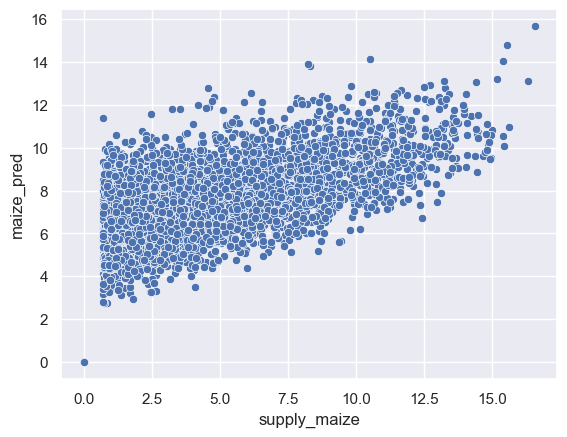

In [75]:
sns.scatterplot(x=np.log(X['supply_maize']+1), y=np.log(X['maize_pred']+1))

In [76]:
print(r2_score(np.log(X['supply_wheat']+1), np.log(X['wheat_pred']+1)))
print(r2_score(X['supply_wheat'], X['wheat_pred']))

0.3655575931364238
-0.08100445050885852


<Axes: xlabel='supply_wheat', ylabel='wheat_pred'>

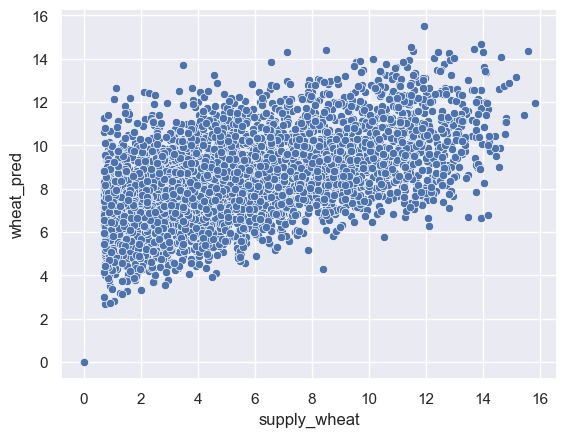

In [77]:
sns.scatterplot(x=np.log(X['supply_wheat']+1), y=np.log(X['wheat_pred']+1))

In [78]:
print(r2_score(np.log(X['supply_rice']+1), np.log(X['rice_pred']+1)))
print(r2_score(X['supply_rice'], X['rice_pred']))

-0.14138126221920877
-281.7830478430192


<Axes: xlabel='supply_rice', ylabel='rice_pred'>

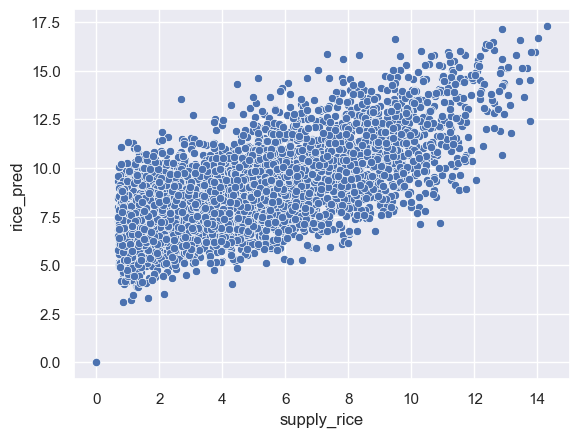

In [79]:
sns.scatterplot(x=np.log(X['supply_rice']+1), y=np.log(X['rice_pred']+1))

In [80]:
print(r2_score(np.log(X['supply_other_cereals']+1), np.log(X['other_cereals_pred']+1)))
print(r2_score(X['supply_other_cereals'], X['other_cereals_pred']))

-0.16392819444771445
0.026657126626233763


<Axes: xlabel='supply_other_cereals', ylabel='other_cereals_pred'>

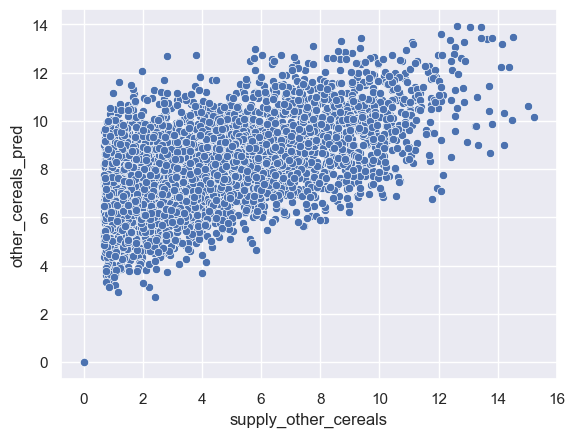

In [81]:
sns.scatterplot(x=np.log(X['supply_other_cereals']+1), y=np.log(X['other_cereals_pred']+1))

In [82]:
print(r2_score(np.log(X['supply_cereals_all']+1), np.log(X['cereals_all_pred']+1)))
print(r2_score(X['supply_cereals_all'], X['cereals_all_pred']))

-0.6881222939315925
-2.32628964123956


<Axes: xlabel='supply_cereals_all', ylabel='cereals_all_pred'>

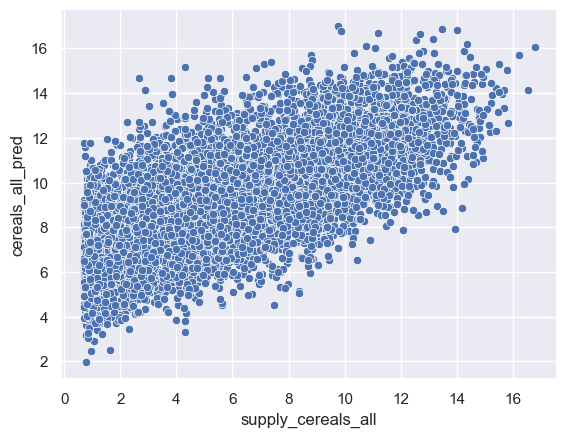

In [83]:
sns.scatterplot(x=np.log(X['supply_cereals_all']+1), y=np.log(X['cereals_all_pred']+1))

In [84]:
print(r2_score(np.log(X['supply_cereals_all']+1), 
               np.log(X['maize_pred']+X['wheat_pred']+X['rice_pred']+X['other_cereals_pred']+1)))
print(r2_score(X['supply_cereals_all'], X['maize_pred']+X['wheat_pred']+X['rice_pred']+X['other_cereals_pred']))

-0.38813593618382547
-2.928023241595629


<Axes: xlabel='supply_cereals_all'>

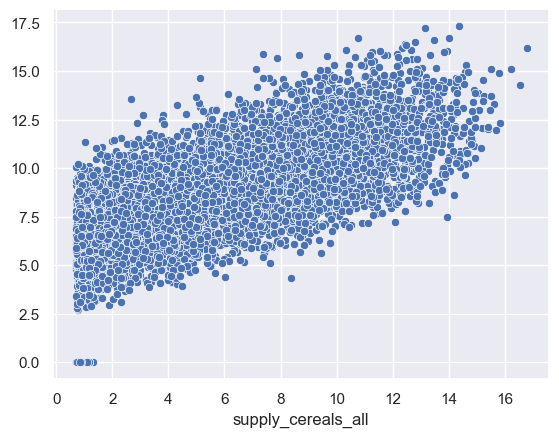

In [85]:
sns.scatterplot(x=np.log(X['supply_cereals_all']+1), 
                y=np.log(X['maize_pred']+X['wheat_pred']+X['rice_pred']+X['other_cereals_pred']+1))

In [86]:
df_sub[df_sub['cereals_all_pred']<df_sub['wheat_pred']].sort_values('wheat_pred').tail()

,from_id,to_id,from_iso3,to_iso3,transport_USD_t,time_h,distance_km,border_USD_t,mode,customs_cost,freight_USD_t,Pref_Applied_AVE,from_barley_area,from_maize_area,from_millet_area,from_rice_area,from_sorghum_area,from_wheat_area,from_other_cereals_area,from_barley_production,from_maize_production,from_millet_production,from_rice_production,from_sorghum_production,from_wheat_production,from_other_cereals_production,from_buffaloes,from_cattle,from_chickens,from_ducks,from_goats,from_horses,from_pigs,from_sheep,from_pop,from_gdp,from_area,from_built_surface,from_built_volume_total,from_built_volume_nres,to_barley_area,to_maize_area,to_millet_area,to_rice_area,to_sorghum_area,to_wheat_area,to_other_cereals_area,to_barley_production,to_maize_production,to_millet_production,to_rice_production,to_sorghum_production,to_wheat_production,to_other_cereals_production,to_buffaloes,to_cattle,to_chickens,to_ducks,to_goats,to_horses,to_pigs,to_sheep,to_pop,to_gdp,to_area,to_built_surface,to_built_volume_total,to_built_volume_nres,from_region,to_region,transport_USD_t_log,time_h_log,distance_km_log,border_USD_t_log,customs_cost_log,freight_USD_t_log,Pref_Applied_AVE_log,from_barley_area_log,from_maize_area_log,from_millet_area_log,from_rice_area_log,from_sorghum_area_log,from_wheat_area_log,from_other_cereals_area_log,from_barley_production_log,from_maize_production_log,from_millet_production_log,from_rice_production_log,from_sorghum_production_log,from_wheat_production_log,from_other_cereals_production_log,from_buffaloes_log,from_cattle_log,from_chickens_log,from_ducks_log,from_goats_log,from_horses_log,from_pigs_log,from_sheep_log,from_pop_log,from_gdp_log,from_area_log,from_built_surface_log,from_built_volume_total_log,from_built_volume_nres_log,to_barley_area_log,to_maize_area_log,to_millet_area_log,to_rice_area_log,to_sorghum_area_log,to_wheat_area_log,to_other_cereals_area_log,to_barley_production_log,to_maize_production_log,to_millet_production_log,to_rice_production_log,to_sorghum_production_log,to_wheat_production_log,to_other_cereals_production_log,to_buffaloes_log,to_cattle_log,to_chickens_log,to_ducks_log,to_goats_log,to_horses_log,to_pigs_log,to_sheep_log,to_pop_log,to_gdp_log,to_area_log,to_built_surface_log,to_built_volume_total_log,to_built_volume_nres_log,barley_ratio,maize_ratio,millet_ratio,rice_ratio,sorghum_ratio,wheat_ratio,other_cereals_ratio,buffaloes_ratio,cattle_ratio,chickens_ratio,ducks_ratio,goats_ratio,horses_ratio,pigs_ratio,sheep_ratio,pop_ratio,trade_exists,from_dim_0,from_dim_1,from_dim_2,from_dim_3,from_dim_4,from_dim_5,from_dim_6,from_dim_7,from_dim_8,from_dim_9,from_dim_10,from_dim_11,from_dim_12,from_dim_13,from_dim_14,from_dim_15,from_degree,from_in_degree,from_out_degree,to_dim_0,to_dim_1,to_dim_2,to_dim_3,to_dim_4,to_dim_5,to_dim_6,to_dim_7,to_dim_8,to_dim_9,to_dim_10,to_dim_11,to_dim_12,to_dim_13,to_dim_14,to_dim_15,to_degree,to_in_degree,to_out_degree,cereals_all_pred,maize_pred,wheat_pred,rice_pred,other_cereals_pred
1044832,ESP.2_1,ESP.5_1,ESP,ESP,43.855212,101.154439,852.847448,0.0,1,0.0,216.141031,0.0,399681.762991,45722.321875,0.000000,4146.403728,0.000000,249687.604870,84041.682007,1.213134e+06,531215.378355,17.111111,18586.763294,0.000000,7.485023e+05,138101.869990,3.563758,3.606639e+05,1.484565e+07,9.807154e+04,6.629481e+04,5533.162625,6.288049e+06,1.928380e+06,1.486068e+06,3.685582e+10,4.769560e+10,2.306251e+08,1.248973e+09,3.169468e+08,590977.224296,2.853760e+04,0.000000,9.147443e+01,0.000000,2.966177e+05,358942.466314,2.088666e+06,3.009313e+05,1.711111e+01,3.958922e+02,0.000000,1.063098e+06,606923.735460,1.280145e+01,1.295629e+06,1.528905e+07,20651.272745,1.824471e+05,34231.860246,3.569420e+06,3.414911e+06,2.618654e+06,6.251436e+10,9.405502e+10,5.010242e+08,2.215387e+09,4.770050e+08,2.0,2.0,3.803440,4.626486,6.749753,0.0,0.0,5.380547,0.0,12.898426,10.730364,0.000000,8.330238,0.00000,12.427970,11.339080,14.008718,13.182925,2.896526,9.830259,0.000000,13.525831,11.835754,1.518146,12.795704,16.

In [87]:
df_sub[df_sub['cereals_all_pred']<df_sub['maize_pred']+df_sub['wheat_pred']+df_sub['rice_pred']+df_sub['other_cereals_pred']].shape

(1657731, 193)

In [88]:
df_sub[df_sub['cereals_all_pred']>=df_sub['maize_pred']+df_sub['wheat_pred']+df_sub['rice_pred']+df_sub['other_cereals_pred']].shape

(3475044, 193)

In [89]:
df_sub[df_sub['cereals_all_pred']<df_sub['maize_pred']+df_sub['wheat_pred']+df_sub['rice_pred']+df_sub['other_cereals_pred']][[
    'cereals_all_pred', 'maize_pred', 'wheat_pred', 'rice_pred', 'other_cereals_pred']].describe()

,cereals_all_pred,maize_pred,wheat_pred,rice_pred,other_cereals_pred
count,1.657731e+06,1.657731e+06,1.657731e+06,1.657731e+06,1.657731e+06
mean,1.629137e+02,2.918443e+01,3.931398e+01,3.608561e+02,2.487203e+01
std,1.262172e+03,1.742274e+03,4.025781e+02,2.404626e+03,3.802956e+02
min,1.739612e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.853117e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.009181e+01,0.000000e+00,0.000000e+00,4.783311e+00,1.664723e+00
75%,5.472378e+01,4.251034e+00,7.078851e+00,3.600281e+01,8.664203e+00
max,4.810483e+05,9.551344e+05,1.134046e+05,4.213536e+05,2.112305e+05


In [90]:
df_sub[df_sub['cereals_all_pred']>df_sub['maize_pred']+df_sub['wheat_pred']+df_sub['rice_pred']+df_sub['other_cereals_pred']][[
    'cereals_all_pred', 'maize_pred', 'wheat_pred', 'rice_pred', 'other_cereals_pred']].describe()

,cereals_all_pred,maize_pred,wheat_pred,rice_pred,other_cereals_pred
count,3.475044e+06,3.475044e+06,3.475044e+06,3.475044e+06,3.475044e+06
mean,4.722373e+02,1.972649e+01,5.211857e+01,4.668793e+01,2.821795e+01
std,4.588731e+03,8.327358e+02,5.063092e+02,4.631746e+02,3.235440e+02
min,2.734947e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.162796e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.773017e+01,0.000000e+00,2.246351e+00,0.000000e+00,1.913660e+00
75%,1.642748e+02,3.809188e+00,1.151795e+01,1.008684e+01,8.498589e+00
max,2.081586e+06,5.906786e+05,2.206884e+05,1.554967e+05,1.373686e+05


In [167]:
df_sub[df_sub['from_iso3']==df_sub['to_iso3']][['cereals_all_pred', 
                                                'maize_pred', 'wheat_pred', 'rice_pred', 'other_cereals_pred']].describe()

,cereals_all_pred,maize_pred,wheat_pred,rice_pred,other_cereals_pred
count,128995.000000,1.289950e+05,128995.000000,128995.000000,128995.000000
mean,465.843802,2.673110e+02,110.518955,43.626589,168.567647
std,7080.753178,4.915360e+03,587.899557,241.361392,693.159037
min,0.544300,1.103898e-01,0.186548,0.105810,0.170557
25%,34.572425,1.007787e+01,23.373399,5.403223,24.828331
50%,74.526090,3.117023e+01,52.146075,10.825510,76.353864
75%,166.756915,8.224714e+01,95.666872,24.605572,189.558304
max,997098.761828,1.056747e+06,79968.568626,33119.269785,96602.646138


In [168]:
128995*465.843802

60091521.23899

In [169]:
128995*(2.673110e+02+110.518955+43.626589+168.567647)

76110170.518045

### matching

In [97]:
df_ids = df_admin[['from_id', 'from_iso3']].drop_duplicates().sort_values(by='from_id').reset_index(drop=True)
df_ids = df_ids.rename(columns={'from_id': 'id', 'from_iso3': 'iso3'})
df_ids.shape

(3536, 2)

In [83]:
# add all admins to from and to columns
df_mat = df_admin[['from_id', 'from_iso3', 'to_id', 'to_iso3']].merge(df_ids, left_on='from_id', right_on='id', how='right')
df_mat = df_mat.drop(['from_id', 'from_iso3'], axis=1).rename(columns={'id': 'from_id', 'iso3': 'from_iso3'})
df_mat = df_mat.sort_values(by='from_id')

def _add_all_admins(m):
    m = m.merge(df_ids, left_on='to_id', right_on='id', how='right')
    m = m.drop(['to_id', 'to_iso3', 'from_id', 'from_iso3'], axis=1).rename(columns={'id': 'to_id', 'iso3': 'to_iso3'})
    m = m.sort_values(by='to_id')
    return m

df_mat = df_mat.groupby(['from_id', 'from_iso3']).apply(lambda g: _add_all_admins(g)).reset_index()

In [82]:
# merge with trade exists and trade (both domestic and international) - all possible trades, for domestic all trades, whatever the probability
df_mat = df_mat.drop('level_2', axis=1)
df_mat = df_mat.merge(df_sub[['from_id', 'to_id', 'trade_exists', 
                              'cereals_all_pred', 'maize_pred', 'wheat_pred', 'rice_pred', 'other_cereals_pred']], how='left')
df_mat = df_mat.fillna(0)
df_mat.to_csv(f'../../data/admin_predictions/df_mat_raw.csv', index=False)

In [98]:
# data up untill here has been saved
df_mat = pd.read_csv(f'../../data/admin_predictions/df_mat_raw.csv')
df_mat['exclude'] = 0
# just to make sure names match with previous coding
df_mat['trade_real'] = 0
df_mat['trade'] = df_mat['maize_pred'] + df_mat['wheat_pred'] + df_mat['rice_pred'] \
+ df_mat['other_cereals_pred'] # total of separate cereal commodities

In [99]:
cons_admin = cons_admin.sort_values(by='ID').reset_index(drop=True)
prod_val = cons_admin['production_admin_est'].values
cons_val = cons_admin['cons'].values

In [100]:
# create a matrix for keeping track of admin - est prod, est cons, est trade max, current cons, current trade
admin_current_status = cons_admin[['ID', 'iso3', 'production_admin_est', 'cons', 'exp_max']]
admin_current_status['current_cons'] = admin_current_status['production_admin_est']
admin_current_status['current_exp'] = 0
admin_current_status['current_imp'] = 0

/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/415400924.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admin_current_status['current_cons'] = admin_current_status['production_admin_est']
/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/415400924.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admin_current_status['current_exp'] = 0
/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/415400924.py:5: SettingWithCopyWarning: 
A value is trying to be set 

In [101]:
exporters = df_country[['from_iso3', 'to_iso3', 'supply_cereals_all']].groupby('from_iso3').sum()[['supply_cereals_all']].sort_values(
    by='supply_cereals_all', ascending=False).reset_index().rename(columns={'from_iso3': 'iso3'})
exporters = exporters[exporters['supply_cereals_all']>0].reset_index(drop=True)
exporters = exporters.merge(cons_admin.groupby('iso3').agg({'exp_max':['sum', 'max']}).xs('exp_max', axis=1, drop_level=True).reset_index()).rename(
    columns={'sum':'exp_est_sum', 'max': 'exp_est_max'})
# just to make sure names match with previous coding
exporters = exporters.rename(columns={'supply_cereals_all': 'trade'})

In [102]:
# just to make sure names match with previous coding
df_country['trade'] = df_country['supply_cereals_all']

In [103]:
def process_mats(df_mat, prod_val, admin_current_status, df_ids, df_country):

    print(df_mat[['trade', 'trade_real']].sum())
    
    # make 3 3536*3536 mats - real trade mat that will be filled, ml pred probs, ml pred trades 
    df_mat = df_mat.sort_values(by=['from_id', 'to_id'])
    df_mat_probs = pd.pivot(df_mat, index=['from_id'], columns = 'to_id',values = 'trade_exists').reset_index().drop('from_id', axis=1).to_numpy()
    df_mat_trade = pd.pivot(df_mat, index=['from_id'], columns = 'to_id',values = 'trade').reset_index().drop('from_id', axis=1).to_numpy()
    df_mat_real = pd.pivot(df_mat, index=['from_id'], columns = 'to_id',values = 'trade_real').reset_index().drop('from_id', axis=1).to_numpy()
    
    # fill in diagonal elements (domestic supply)
    exports_pred = df_mat_real.sum(axis=1)
    imports_pred = df_mat_real.sum(axis=0)
    dom_sup_pred = prod_val - exports_pred
    np.fill_diagonal(df_mat_real, dom_sup_pred)
    
    # matrix for keeping track of admin - est prod, est cons, est trade max, current cons, current trade
    admin_current_status['current_cons'] = df_mat_real.sum(axis=0)
    admin_current_status['current_exp'] = exports_pred
    admin_current_status['current_imp'] = imports_pred
    admin_current_status['exp_max'] = admin_current_status['production_admin_est'] + admin_current_status['current_imp'] - admin_current_status['cons']
    admin_current_status.loc[admin_current_status['exp_max']>admin_current_status['production_admin_est'], 'exp_max'] = admin_current_status[
        admin_current_status['exp_max']>admin_current_status['production_admin_est']]['production_admin_est']
    
    df_mat_real_pd = pd.DataFrame(df_mat_real, columns = df_ids['id'].values.tolist())
    df_mat_real_pd['from_id'] = pd.Series(df_ids['id'].values.tolist(), index=df_mat_real_pd.index)
    first_column = df_mat_real_pd.pop('from_id')
    df_mat_real_pd.insert(0, 'from_id', first_column)
    df_mat_real_pd = df_mat_real_pd.melt(id_vars=['from_id'], value_vars=df_ids['id'].values.tolist()).rename(
        columns={'variable': 'to_id', 'value': 'trade'})
    df_mat_real_pd = df_mat_real_pd.merge(df_ids, left_on='from_id', right_on='id').rename(columns={'iso3': 'from_iso3'}).drop('id', axis=1)
    df_mat_real_pd = df_mat_real_pd.merge(df_ids, left_on='to_id', right_on='id').rename(columns={'iso3': 'to_iso3'}).drop('id', axis=1)
    df_mat_real_pd = df_mat_real_pd[df_mat_real_pd['from_iso3']!=df_mat_real_pd['to_iso3']]
    
    trade_bal_pred = df_mat_real_pd.groupby(['from_iso3', 'to_iso3']).sum()[['trade']].reset_index()
    trade_bal_pred = trade_bal_pred.rename(columns={'trade': 'trade_pred'}).merge(df_country[['from_iso3', 'to_iso3', 'trade']])

    print(len(trade_bal_pred[trade_bal_pred['trade_pred']>trade_bal_pred['trade']+0.1]))
    print(trade_bal_pred[trade_bal_pred['trade_pred']>trade_bal_pred['trade']+0.1]['from_iso3'].nunique())
    
    return df_mat, df_mat_probs, df_mat_trade, df_mat_real, admin_current_status, trade_bal_pred

In [104]:
def sel_trades(df, cons_admin, constrain=True, prob_thresh=0.4, exclude=True, scale=False):

    # spread out production for each admin row (decreasing order of ml preds until all allowed trade is used up)
    trade_max = cons_admin[cons_admin['ID']==df['from_id'].values[0]]['exp_max'].values[0]

    if constrain:
        if trade_max<=0:
            df['trade_real'] = 0
            return df

    if len(df[df['trade_exists']>prob_thresh])>0:
        d = df[df['trade_exists']>prob_thresh]
    else:
        # d = df[df['trade_exists']>df["trade_exists"].quantile(0.4)] # commented this out and added the next two lines to export the second set of results 
        df['trade_real'] = 0
        return df

    if exclude:
        d = d[d['exclude']==0]

    if d['trade'].sum()>trade_max:
        d['trade'] = d['trade'] * trade_max/d['trade'].sum()
    
    df = df.merge(d.rename(columns={'trade': 'trade_real'}), how='left').fillna(0)
    
    return df

In [105]:
def remove_trades(df, trade_total):

    d = df[df['trade_real']>0]
    df = df.drop('trade_real', axis=1)
    d = d.sort_values(by='trade_real', ascending=False)
    d['trade_total'] = d['trade_real'].cumsum()
    d['trade_total_copy'] = d['trade_total']
    d.loc[d['trade_total_copy']>trade_total, 'trade_total_copy'] = trade_total
    d = d.drop_duplicates(subset=['trade_total_copy'], keep='first')
    d['trade_real'] = d['trade_real'] + d['trade_total_copy'] - d['trade_total']
    d = d.drop(['trade_total', 'trade_total_copy', 'trade'], axis=1)
    df = df.merge(d[['from_id', 'to_id', 'trade_real']], how='left').fillna(0)
    df.loc[df['trade_real']==0, 'exclude'] = 1
    df.loc[(df['trade_real']!=df['trade']) & (df['exclude']==0), 'trade'] = df[(df['trade_real']!=df['trade']) & (df['exclude']==0)]['trade_real']
    return df

In [106]:
loop = True
i = 0

while loop:

    # add dropped trades to other countries
    df_mat = df_mat.drop('trade_real', axis=1).groupby('from_id').apply(lambda g: sel_trades(g, cons_admin=admin_current_status, prob_thresh=0)).reset_index(drop=True)
    df_mat, df_mat_probs, df_mat_trade, df_mat_real, admin_current_status, trade_bal_pred = process_mats(
        df_mat, prod_val, admin_current_status, df_ids, df_country)
                                                                                                                                              
    np.save(f'../../data/admin_predictions/df_mat_real_{i}.npy', df_mat_real)
    admin_current_status.to_csv(f'../../data/admin_predictions/adm_current_status_{i}.csv', index=False)
    df_mat.to_csv(f'../../data/admin_predictions/df_mat_{i}.csv', index=False)                                                                                                  
                                                                                                                                              
    if len(trade_bal_pred[trade_bal_pred['trade_pred']>trade_bal_pred['trade']+0.1])==0:
        loop = False
    else:
        # in decreasing order of exporter prominence, transfer trade from countries receiving too much to countries receiving too little (from the same admins so that row balance isnt disturbed)
        for exporter in exporters['iso3'].values:
            df_exp = trade_bal_pred[trade_bal_pred['from_iso3']==exporter]
            df_over_exp = df_exp[df_exp['trade']+0.1<df_exp['trade_pred']]
        
            if len(df_over_exp)>0:
                df_over_exp['diff'] = df_over_exp['trade'] - df_over_exp['trade_pred']
                df_over_exp = df_over_exp.sort_values(by='diff')
            
                df_mat_extract = df_mat.merge(df_over_exp[['from_iso3', 'to_iso3']], how='right')
                df_mat_extract = df_mat_extract.groupby(['from_iso3','to_iso3']).apply(lambda g: remove_trades(g, 
                                 df_over_exp[(df_over_exp['from_iso3']==g['from_iso3'].values[0]) 
                                 & (df_over_exp['to_iso3']==g['to_iso3'].values[0])]['trade'].values[0])).reset_index(drop=True)
                df_mat = pd.concat([df_mat, df_mat_extract], axis=0).drop_duplicates(subset=['from_id', 'to_id'], keep=False)
                df_mat = pd.concat([df_mat, df_mat_extract], axis=0).sort_values(by=['from_id', 'to_id'])

    i+=1
    
    if i==10:
        loop = False
        df_mat, df_mat_probs, df_mat_trade, df_mat_real, admin_current_status, trade_bal_pred = process_mats(
            df_mat, prod_val, admin_current_status, df_ids, df_country)
        np.save(f'../../data/admin_predictions/df_mat_real_{i}.npy', df_mat_real)
        admin_current_status.to_csv(f'../../data/admin_predictions/adm_current_status_{i}.csv', index=False)
        df_mat.to_csv(f'../../data/admin_predictions/df_mat_{i}.csv', index=False)        

trade         1.262951e+09
trade_real    3.287811e+08
dtype: float64


/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/796289598.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admin_current_status['current_cons'] = df_mat_real.sum(axis=0)
/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/796289598.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admin_current_status['current_exp'] = exports_pred
/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/796289598.py:20: SettingWithCopyWarning: 
A value is trying to be set on a co

7078
122


/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/1449074760.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_over_exp['diff'] = df_over_exp['trade'] - df_over_exp['trade_pred']
/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/1449074760.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_over_exp['diff'] = df_over_exp['trade'] - df_over_exp['trade_pred']
/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/1449074760.py:24: SettingWithCopyWarning: 
A va

trade         1.219905e+09
trade_real    2.782554e+08
dtype: float64


/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/796289598.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admin_current_status['current_cons'] = df_mat_real.sum(axis=0)
/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/796289598.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admin_current_status['current_exp'] = exports_pred
/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/796289598.py:20: SettingWithCopyWarning: 
A value is trying to be set on a co

783
82


/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/1449074760.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_over_exp['diff'] = df_over_exp['trade'] - df_over_exp['trade_pred']
/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/1449074760.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_over_exp['diff'] = df_over_exp['trade'] - df_over_exp['trade_pred']
/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/1449074760.py:24: SettingWithCopyWarning: 
A va

trade         1.211010e+09
trade_real    2.732754e+08
dtype: float64


/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/796289598.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admin_current_status['current_cons'] = df_mat_real.sum(axis=0)
/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/796289598.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admin_current_status['current_exp'] = exports_pred
/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/796289598.py:20: SettingWithCopyWarning: 
A value is trying to be set on a co

64
12


/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/1449074760.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_over_exp['diff'] = df_over_exp['trade'] - df_over_exp['trade_pred']
/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/1449074760.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_over_exp['diff'] = df_over_exp['trade'] - df_over_exp['trade_pred']
/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/1449074760.py:24: SettingWithCopyWarning: 
A va

trade         1.209219e+09
trade_real    2.750119e+08
dtype: float64


/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/796289598.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admin_current_status['current_cons'] = df_mat_real.sum(axis=0)
/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/796289598.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admin_current_status['current_exp'] = exports_pred
/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/796289598.py:20: SettingWithCopyWarning: 
A value is trying to be set on a co

6
2


/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/1449074760.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_over_exp['diff'] = df_over_exp['trade'] - df_over_exp['trade_pred']
/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/1449074760.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_over_exp['diff'] = df_over_exp['trade'] - df_over_exp['trade_pred']


trade         1.209140e+09
trade_real    2.764718e+08
dtype: float64


/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/796289598.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admin_current_status['current_cons'] = df_mat_real.sum(axis=0)
/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/796289598.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admin_current_status['current_exp'] = exports_pred
/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/796289598.py:20: SettingWithCopyWarning: 
A value is trying to be set on a co

5
2


/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/1449074760.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_over_exp['diff'] = df_over_exp['trade'] - df_over_exp['trade_pred']
/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/1449074760.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_over_exp['diff'] = df_over_exp['trade'] - df_over_exp['trade_pred']


trade         1.208229e+09
trade_real    2.771469e+08
dtype: float64


/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/796289598.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admin_current_status['current_cons'] = df_mat_real.sum(axis=0)
/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/796289598.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admin_current_status['current_exp'] = exports_pred
/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/796289598.py:20: SettingWithCopyWarning: 
A value is trying to be set on a co

3
2


/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/1449074760.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_over_exp['diff'] = df_over_exp['trade'] - df_over_exp['trade_pred']
/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/1449074760.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_over_exp['diff'] = df_over_exp['trade'] - df_over_exp['trade_pred']


trade         1.207803e+09
trade_real    2.775981e+08
dtype: float64


/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/796289598.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admin_current_status['current_cons'] = df_mat_real.sum(axis=0)
/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/796289598.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admin_current_status['current_exp'] = exports_pred
/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/796289598.py:20: SettingWithCopyWarning: 
A value is trying to be set on a co

1
1


/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/1449074760.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_over_exp['diff'] = df_over_exp['trade'] - df_over_exp['trade_pred']


trade         1.207775e+09
trade_real    2.779535e+08
dtype: float64


/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/796289598.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admin_current_status['current_cons'] = df_mat_real.sum(axis=0)
/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/796289598.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admin_current_status['current_exp'] = exports_pred
/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_23400/796289598.py:20: SettingWithCopyWarning: 
A value is trying to be set on a co

0
0


In [108]:
# data uptil here has been saved
df_mat_real = np.load('../../data/admin_predictions/df_mat_real_7.npy')
admin_current_status = pd.read_csv('../../data/admin_predictions/adm_current_status_7.csv')
df_mat = pd.read_csv('../../data/admin_predictions/df_mat_7.csv')

df_mat_real_pd = pd.DataFrame(df_mat_real, columns = df_ids['id'].values.tolist())
df_mat_real_pd['from_id'] = pd.Series(df_ids['id'].values.tolist(), index=df_mat_real_pd.index)
first_column = df_mat_real_pd.pop('from_id')
df_mat_real_pd.insert(0, 'from_id', first_column)
df_mat_real_pd = df_mat_real_pd.melt(id_vars=['from_id'], value_vars=df_ids['id'].values.tolist()).rename(columns={'variable': 'to_id', 'value': 'trade'})
df_mat_real_pd = df_mat_real_pd.merge(df_ids, left_on='from_id', right_on='id').rename(columns={'iso3': 'from_iso3'}).drop('id', axis=1)
df_mat_real_pd = df_mat_real_pd.merge(df_ids, left_on='to_id', right_on='id').rename(columns={'iso3': 'to_iso3'}).drop('id', axis=1)
df_mat_real_pd = df_mat_real_pd[df_mat_real_pd['from_iso3']!=df_mat_real_pd['to_iso3']]

trade_bal_pred = df_mat_real_pd.groupby(['from_iso3', 'to_iso3']).sum()[['trade']].reset_index()
trade_bal_pred = trade_bal_pred.rename(columns={'trade': 'trade_pred'}).merge(df_country[['from_iso3', 'to_iso3', 'trade']])

In [109]:
trade_bal_pred['diff']= trade_bal_pred['trade'] - trade_bal_pred['trade_pred']
print(len(trade_bal_pred[trade_bal_pred['diff']>=1]))
print(trade_bal_pred[trade_bal_pred['diff']>=1]['diff'].sum()) 

admin_current_status['available'] = 1
admin_current_status.loc[admin_current_status['exp_max']<1, 'available'] = 0
admin_current_status.loc[admin_current_status['exp_max'].round()<=admin_current_status['current_exp'].round(), 'available'] = 0 
admin_current_status['prod_imp'] = admin_current_status['production_admin_est'] + admin_current_status['current_imp']
print(admin_current_status['available'].value_counts()) 

3014
316509232.73412645
available
0    2416
1    1120
Name: count, dtype: int64


In [111]:
# go in decreasing order of trade_diff
def fill_trade(df_mat, admin_current_status, from_iso3, to_iso3, diff, prob_thresh=0.4, i=0):

    def _down_scale(df, var='exp_max'):
        max_val = df[var].values[0] - df['current_exp'].values[0] + df['trade_real'].sum()
        if df['trade'].sum()>max_val:
            if max_val<0:
                df['trade'] = 0
            else:
                df['trade'] = df['trade'] * max_val/df['trade'].sum()
        return df

    d = df_mat[(df_mat['from_iso3']==from_iso3) & (df_mat['to_iso3']==to_iso3)]
    # using admin_current_status, remove all admins from exporter that have reached capacity
    d = d.merge(admin_current_status, left_on='from_id', right_on='ID', how='left').drop(['ID', 'iso3'], axis=1)
    admins_full = d[(d['available']==0)]['from_id'].unique()
    
    # if any are left
    if len(d[~d['from_id'].isin(admins_full)])>0:
        d = d[~d['from_id'].isin(admins_full)]
        # if there are any links for which trade is predicted, but hasn't been counted because of probability<0.4, 
        # take those trade values before considering scaling 
        # this only needs to happen in the first loop instance, 
        # don't reinitiate this in subsequent loops, if a below 0.4 previously unused link becomes newly available due to added imports
        if len(d[(d['trade']>d['trade_real'])])==len(d[(d['trade_exists']<=prob_thresh)]) and len(d[(d['trade']>d['trade_real'])])>0 and i==-1:
            print('reached 1')
            d = d[d['trade']>d['trade_real']] 
            d = d.groupby('from_id').apply(lambda g: _down_scale(g)).reset_index(drop=True)
            if d['trade'].sum()>diff: # we don't need all the uncounted trade, only count until diff is covered
                d = d.sort_values(by='trade', ascending=False)
                d['trade_total'] = d['trade'].cumsum()
                d['trade_total_copy'] = d['trade_total']
                d.loc[d['trade_total_copy']>diff, 'trade_total_copy'] = diff
                d = d.drop_duplicates(subset=['trade_total_copy'], keep='first')
                d['trade'] = d['trade'] + d['trade_total_copy'] - d['trade_total']
        else:
            # if there are any links for which current
            # are any currently exporting? if yes, scale those up to meet the total required, take whatever possible
            if len(d[d['trade_exists']>prob_thresh])>0:
                d = d[d['trade_exists']>prob_thresh]
                if d['trade'].sum()>0:
                    print('reached 2a')
                    diff = diff + d['trade_real'].sum()
                    d['trade'] = d['trade'] * diff/d['trade'].sum()
                    d = d.groupby('from_id').apply(lambda g: _down_scale(g)).reset_index(drop=True)
                # if no trades on these links are>0, take whatever possible prioritizing trade from regions with most excess to those with most deficit
                else:
                    print('reached 2b')
                    d = d.merge(admin_current_status[['ID', 'exp_max']].rename(columns={
                        'ID': 'to_id', 'exp_max': 'to_exp_max'
                    }), how='left')
                    if len(d[d['to_exp_max']<0])>0:
                        d = d[d['to_exp_max']<0]
                        d['trade'] = d['to_exp_max'].abs() 
                    else:
                        d['trade'] = (diff + d['trade_real'].sum()) / len(d)
                    diff = diff + d['trade_real'].sum()
                    d['trade'] = d['trade'] * diff/d['trade'].sum()
                    d = d.groupby('from_id').apply(lambda g: _down_scale(g)).reset_index(drop=True)
            # if none are currently exporting, 
            else:
                #i.e. all trade probs are less than 0.4, take all trades>0, scale those to meet total required, take whatever possible
                if d['trade'].sum()>0:
                    print('reached 3a')
                    diff = diff + d['trade_real'].sum()
                    d['trade'] = d['trade'] * diff/d['trade'].sum()
                    d = d.groupby('from_id').apply(lambda g: _down_scale(g)).reset_index(drop=True)
                # if no trades on remaining links are>0, take whatever possible prioritizing trade from regions with most excess to those with most deficit
                else:
                    print('reached 3b')
                    d = d.merge(admin_current_status[['ID', 'exp_max']].rename(columns={
                        'ID': 'to_id', 'exp_max': 'to_exp_max'
                    }), how='left')
                    if len(d[d['to_exp_max']<0])>0:
                        d = d[d['to_exp_max']<0]
                        d['trade'] = d['to_exp_max'].abs() 
                    else:
                        d['trade'] = (diff + d['trade_real'].sum()) / len(d)
                    diff = diff + d['trade_real'].sum()
                    d['trade'] = d['trade'] * diff/d['trade'].sum()
                    d = d.groupby('from_id').apply(lambda g: _down_scale(g)).reset_index(drop=True) 

    # if none are left
    else:
        print('reached 4')
        # divide remainder across all admins 
        d = d.merge(admin_current_status[['ID', 'cons', 'current_cons']].rename(columns={'ID': 'from_id'}), how='left')
        d['cons_frac'] = d['current_cons'] / d['cons']
        d['trade'] = diff * d['cons_frac'] / d['cons_frac'].sum() + d['trade_real']
        d = d.groupby('from_id').apply(lambda g: _down_scale(g, var='prod_imp')).reset_index(drop=True)
    
    # update df_mat
    d = d[['from_id', 'to_id', 'trade']].rename(columns={'trade': 'trade_real_upd'})
    df_mat = df_mat.merge(d, how='left')
    df_mat.loc[df_mat['trade_real_upd'].notnull(), 'trade_real'] = df_mat[df_mat['trade_real_upd'].notnull()]['trade_real_upd']
    df_mat = df_mat.drop('trade_real_upd', axis=1)

    # update admin_current_status
    df_mat = df_mat.sort_values(by=['from_id', 'to_id'])
    df_mat_real = pd.pivot(df_mat, index=['from_id'], columns = 'to_id',values = 'trade_real').reset_index().drop('from_id', axis=1).to_numpy()
    
    # fill in diagonal elements (domestic supply)
    exports_pred = df_mat_real.sum(axis=1)
    imports_pred = df_mat_real.sum(axis=0)
    dom_sup_pred = prod_val - exports_pred
    np.fill_diagonal(df_mat_real, dom_sup_pred)
    
    # matrix for keeping track of admin - est prod, est cons, est trade max, current cons, current trade
    admin_current_status['current_cons'] = df_mat_real.sum(axis=0)
    admin_current_status['current_exp'] = exports_pred
    admin_current_status['current_imp'] = imports_pred
    admin_current_status['exp_max'] = admin_current_status['production_admin_est'] + admin_current_status['current_imp'] - admin_current_status['cons']
    admin_current_status.loc[admin_current_status['exp_max']>admin_current_status['production_admin_est'], 'exp_max'] = admin_current_status[
        admin_current_status['exp_max']>admin_current_status['production_admin_est']]['production_admin_est']
    admin_current_status['available'] = 1 
    admin_current_status.loc[admin_current_status['exp_max']<1, 'available'] = 0
    admin_current_status.loc[admin_current_status['exp_max'].round()<=admin_current_status['current_exp'].round(), 'available'] = 0
    admin_current_status['prod_imp'] = admin_current_status['production_admin_est'] + admin_current_status['current_imp']

    if len(admin_current_status[admin_current_status['current_exp']<0])>0:
        print('error1')
    if len(df_mat[df_mat['trade_real']<0])>0:
        print('error2')
    if len(admin_current_status[admin_current_status['current_cons']<-0.9])>0:
        print('error3')
    
    return df_mat, df_mat_real, admin_current_status

In [112]:
loop = True
i = 0

while loop:
    # apply for loop on sorted trade_bal_pred and return df_mat, only when diff is positive
    for index, row in trade_bal_pred[trade_bal_pred['diff']>=1].sort_values('diff', ascending=False).reset_index(drop=True).iterrows():
        from_iso3 = row['from_iso3']
        to_iso3 = row['to_iso3']
        diff = row['diff']
        print(f"{index} {from_iso3} to {to_iso3}")
        df_mat, df_mat_real, admin_current_status = fill_trade(df_mat, admin_current_status, from_iso3, to_iso3, diff, i=i)
        print('done')

    np.save(f'../../data/admin_predictions/df_mat_real_bal_{i}.npy', df_mat_real)
    admin_current_status.to_csv(f'../../data/admin_predictions/adm_current_status_bal_{i}.csv', index=False)
    df_mat.to_csv(f'../../data/admin_predictions/df_mat_bal_{i}.csv', index=False)

    # re calculate trade_bal_pred
    df_mat_real_pd = pd.DataFrame(df_mat_real, columns = df_ids['id'].values.tolist())
    df_mat_real_pd['from_id'] = pd.Series(df_ids['id'].values.tolist(), index=df_mat_real_pd.index)
    first_column = df_mat_real_pd.pop('from_id')
    df_mat_real_pd.insert(0, 'from_id', first_column)
    df_mat_real_pd = df_mat_real_pd.melt(id_vars=['from_id'], value_vars=df_ids['id'].values.tolist()).rename(columns={'variable': 'to_id', 
                                                                                                                       'value': 'trade'})
    df_mat_real_pd = df_mat_real_pd.merge(df_ids, left_on='from_id', right_on='id').rename(columns={'iso3': 'from_iso3'}).drop('id', axis=1)
    df_mat_real_pd = df_mat_real_pd.merge(df_ids, left_on='to_id', right_on='id').rename(columns={'iso3': 'to_iso3'}).drop('id', axis=1)
    df_mat_real_pd = df_mat_real_pd[df_mat_real_pd['from_iso3']!=df_mat_real_pd['to_iso3']]
    
    trade_bal_pred = df_mat_real_pd.groupby(['from_iso3', 'to_iso3']).sum()[['trade']].reset_index()
    trade_bal_pred = trade_bal_pred.rename(columns={'trade': 'trade_pred'}).merge(df_country[['from_iso3', 'to_iso3', 'trade']])
    trade_bal_pred['diff']= trade_bal_pred['trade'] - trade_bal_pred['trade_pred']

    print(len(trade_bal_pred[trade_bal_pred['diff']>=1]))
    print(trade_bal_pred[trade_bal_pred['diff']>=1]['diff'].sum())
    print(admin_current_status['available'].value_counts())
    
    if len(trade_bal_pred[trade_bal_pred['diff']>=1])==0:
        loop = False
    
    i+=1
    if i==20:
        loop = False

0 USA to JPN
reached 2a
done
1 USA to MEX
reached 2a
done
2 USA to CHN
reached 2a
done
3 RUS to EGY
reached 2a
done
4 ARG to VNM
reached 2a
done
5 UKR to CHN
reached 2a
done
6 ARG to BRA
reached 2a
done
7 UKR to EGY
reached 2a
done
8 RUS to TUR
reached 2a
done
9 USA to KOR
reached 2a
done
10 BRA to IRN
reached 2a
done
11 AUS to CHN
reached 2a
done
12 ARG to DZA
reached 2a
done
13 CAN to CHN
reached 2a
done
14 FRA to DZA
reached 2a
done
15 FRA to BEL
reached 2a
done
16 UKR to ESP
reached 2a
done
17 ARG to EGY
reached 2a
done
18 BRA to JPN
reached 2a
done
19 BRA to EGY
reached 2a
done
20 USA to TWN
reached 2a
done
21 USA to COL
reached 2a
done
22 ARG to KOR
reached 2a
done
23 AUS to IDN
reached 2a
done
24 CAN to USA
reached 2a
done
25 BRA to VNM
reached 2a
done
26 UKR to IDN
reached 2a
done
27 ARG to CHL
reached 2a
done
28 USA to PHL
reached 2a
done
29 BRA to ESP
reached 2a
done
30 ARG to SAU
reached 2a
done
31 FRA to CHN
reached 2a
done
32 UKR to NLD
reached 2a
done
33 ARG to MYS
reache

In [113]:
# data uptil here has been saved 
df_mat_real = np.load('../../data/admin_predictions/df_mat_real_bal_10.npy')
admin_current_status = pd.read_csv('../../data/admin_predictions/adm_current_status_bal_10.csv')
df_mat = pd.read_csv('../../data/admin_predictions/df_mat_bal_10.csv')

df_mat_real_pd = pd.DataFrame(df_mat_real, columns = df_ids['id'].values.tolist())
df_mat_real_pd['from_id'] = pd.Series(df_ids['id'].values.tolist(), index=df_mat_real_pd.index)
first_column = df_mat_real_pd.pop('from_id')
df_mat_real_pd.insert(0, 'from_id', first_column)
df_mat_real_pd = df_mat_real_pd.melt(id_vars=['from_id'], value_vars=df_ids['id'].values.tolist()).rename(columns={'variable': 'to_id', 'value': 'trade'})
df_mat_real_pd = df_mat_real_pd.merge(df_ids, left_on='from_id', right_on='id').rename(columns={'iso3': 'from_iso3'}).drop('id', axis=1)
df_mat_real_pd = df_mat_real_pd.merge(df_ids, left_on='to_id', right_on='id').rename(columns={'iso3': 'to_iso3'}).drop('id', axis=1)
df_mat_real_pd = df_mat_real_pd[df_mat_real_pd['from_iso3']!=df_mat_real_pd['to_iso3']]

trade_bal_pred = df_mat_real_pd.groupby(['from_iso3', 'to_iso3']).sum()[['trade']].reset_index()
trade_bal_pred = trade_bal_pred.rename(columns={'trade': 'trade_pred'}).merge(df_country[['from_iso3', 'to_iso3', 'trade']])
trade_bal_pred['diff']= trade_bal_pred['trade'] - trade_bal_pred['trade_pred']

print(len(trade_bal_pred[trade_bal_pred['diff']>=1]))
print(trade_bal_pred[trade_bal_pred['diff']>=1]['diff'].sum())
print(admin_current_status['available'].value_counts())

0
0.0
available
0    2239
1    1297
Name: count, dtype: int64


In [114]:
df_mat[(df_mat['from_iso3']!=df_mat['to_iso3'])][['trade', 'trade_real']].sum()

trade         9.093546e+08
trade_real    4.537087e+08
dtype: float64

In [90]:
2.984204e+08+9.585774e+08

1256997800.0

In [115]:
df_mat[(df_mat['trade_real']>0) & (df_mat['from_iso3']!=df_mat['to_iso3'])][['trade', 'trade_real']].sum()

trade         2.886070e+08
trade_real    4.537087e+08
dtype: float64

In [116]:
df_mat[(df_mat['trade_real']>0) & (df_mat['trade_exists']>0.4) & (df_mat['from_iso3']!=df_mat['to_iso3'])][['trade', 'trade_real']].sum()

trade         1.218119e+08
trade_real    3.722043e+08
dtype: float64

In [117]:
r2_score(np.log(df_mat[(df_mat['trade_real']>0) & (df_mat['from_iso3']!=df_mat['to_iso3'])]['trade']+1), 
         np.log(df_mat[(df_mat['trade_real']>0) & (df_mat['from_iso3']!=df_mat['to_iso3'])]['trade_real']+1))

-0.3317894348573953

In [118]:
(df_mat[(df_mat['trade_real']>0) & (df_mat['from_iso3']!=df_mat['to_iso3'])]['trade_real'] / (
    df_mat[(df_mat['trade_real']>0) & (df_mat['from_iso3']!=df_mat['to_iso3'])]['trade']+1)).describe()

count    7.935750e+05
mean     3.515214e+00
std      3.963031e+01
min      1.902126e-07
25%      3.336168e-02
50%      8.186304e-01
75%      9.910892e-01
max      1.510458e+04
dtype: float64

<Axes: ylabel='Count'>

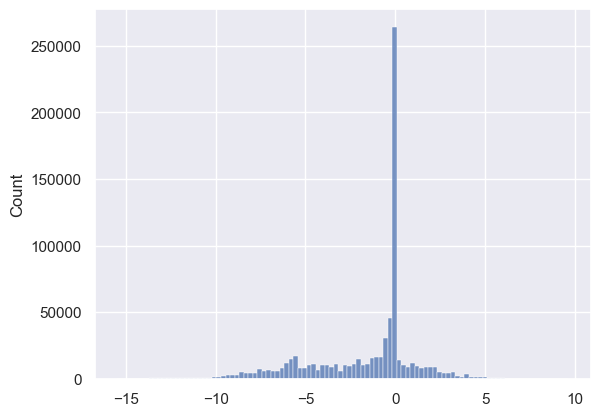

In [119]:
sns.histplot(np.log((df_mat[(df_mat['trade_real']>0) & (df_mat['from_iso3']!=df_mat['to_iso3'])]['trade_real'] / (
    df_mat[(df_mat['trade_real']>0) & (df_mat['from_iso3']!=df_mat['to_iso3'])]['trade']+1))), bins=100)

In [120]:
df_mat[(df_mat['trade_real']==0) & (df_mat['from_iso3']!=df_mat['to_iso3'])][['trade']].sum()

trade    6.207476e+08
dtype: float64

In [121]:
df_mat[(df_mat['trade_real']==0) & (df_mat['from_iso3']==df_mat['to_iso3']) & (df_mat['from_id']!=df_mat['to_id'])][['trade']].sum()

trade    9.679000e+07
dtype: float64

In [122]:
df_mat[(df_mat['from_iso3']==df_mat['to_iso3']) & (df_mat['trade_exists']<0.4) & (df_mat['from_id']!=df_mat['to_id'])][['trade', 'trade_real']].sum()

trade         1.253416e+08
trade_real    2.810713e+07
dtype: float64

In [123]:
df_mat[(df_mat['from_iso3']==df_mat['to_iso3']) & (df_mat['trade_exists']>0.4) & (df_mat['from_id']!=df_mat['to_id'])][['trade', 'trade_real']].sum()

trade         1.730788e+08
trade_real    1.126469e+08
dtype: float64

In [124]:
df_mat[(df_mat['from_iso3']==df_mat['to_iso3']) & (df_mat['from_id']!=df_mat['to_id'])][['trade', 'trade_real']].sum()

trade         2.984204e+08
trade_real    1.407540e+08
dtype: float64

In [125]:
df_mat[(df_mat['trade_real']>0) & (df_mat['from_iso3']!=df_mat['to_iso3'])]['trade_exists'].describe()

count    793575.000000
mean          0.154132
std           0.255763
min           0.000004
25%           0.005234
50%           0.025444
75%           0.158142
max           0.999277
Name: trade_exists, dtype: float64

In [126]:
df_mat[(df_mat['trade']>0) & (df_mat['from_iso3']!=df_mat['to_iso3'])]['trade_exists'].describe()

count    4.932487e+06
mean     9.408975e-02
std      1.957298e-01
min      2.143298e-06
25%      3.016919e-03
50%      1.150084e-02
75%      6.423333e-02
max      9.992772e-01
Name: trade_exists, dtype: float64

In [127]:
df_mat[(df_mat['trade_exists']>0.4) & (df_mat['from_iso3']!=df_mat['to_iso3'])][['trade', 'trade_real']].describe()

,trade,trade_real
count,408257.000000,4.082570e+05
mean,864.890321,9.116911e+02
std,3974.309133,9.625492e+03
min,0.000000,0.000000e+00
25%,36.945734,0.000000e+00
50%,119.737498,0.000000e+00
75%,474.006230,3.112676e+01
max,348699.803602,1.877111e+06


In [128]:
df_mat[(df_mat['from_iso3']!=df_mat['to_iso3'])].sort_values(by='trade_real').tail()

,from_id,from_iso3,to_id,to_iso3,trade_exists,cereals_all_pred,maize_pred,wheat_pred,rice_pred,other_cereals_pred,exclude,trade,trade_real
11719928,USA.14_1,USA,KOR.8_1,KOR,0.732957,28775.587323,15756.207529,21.299682,761.153865,20.873163,0,16559.534238,8.529974e+05
11772806,USA.28_1,USA,JPN.19_1,JPN,0.423230,2107.681816,4340.130050,24.703437,511.900484,30.189132,0,4906.923102,8.894939e+05
322567,ARG.6_1,ARG,EGY.8_1,EGY,0.429544,102.052725,134.835742,38.120536,3.227551,0.000000,0,176.183829,1.124618e+06
11719767,USA.14_1,USA,JPN.1_1,JPN,0.458760,1662.752620,5930.694867,21.854801,301.131062,49.840196,0,6303.520926,1.142660e+06
289840,ARG.1_1,ARG,VNM.27_1,VNM,0.631467,3185.984095,2552.568941,166.404807,2.965767,42.348985,0,2764.288499,1.877111e+06


In [129]:
admin_current_status[admin_current_status['iso3']=='USA']

,ID,iso3,production_admin_est,cons,exp_max,current_cons,current_exp,current_imp,available,prod_imp
3310,USA.10_1,USA,3.331958e+06,1.830207e+07,-1.403637e+07,4.265703e+06,0.000000e+00,9.337450e+05,0,4.265703e+06
3311,USA.11_1,USA,1.022453e+07,1.201540e+07,-8.011990e+05,1.121420e+07,0.000000e+00,9.896745e+05,0,1.121420e+07
3312,USA.12_1,USA,6.028131e+04,1.128889e+06,-1.024752e+06,1.041373e+05,0.000000e+00,4.385601e+04,0,1.041373e+05
3313,USA.13_1,USA,4.158671e+06,2.449339e+06,1.844184e+06,3.699711e+06,5.938117e+05,1.348521e+05,1,4.293523e+06
3314,USA.14_1,USA,3.526028e+07,9.642879e+06,2.702609e+07,1.938992e+07,1.727904e+07,1.408689e+06,1,3.666897e+07
3315,USA.15_1,USA,1.717384e+07,8.785325e+06,9.247671e+06,1.438420e+07,3.648793e+06,8.591586e+05,1,1.803300e+07
3316,USA.16_1,USA,3.116494e+07,3.885714e+06,2.862638e+07,2.558171e+07,6.930385e+06,1.347159e+06,1,3.251210e+07
3317,USA.17_1,USA,2.433695e+07,3.357251e+06,2.189829e+07,1.589949e+07,9.356056e+06,9.185936e+05,1,2.525554e+07
3318,USA.18_1,USA,9.416786e+06,6.261332e+06,4.003682e+06,8.588172e+06,1.676842e+06,8.482279e+05,1,1.026501e+07
3319,USA.19_1,USA,9.157964e+06,5.617465e+06,4.666278e+06,5.617465e+06,4.666278e+06,1.125780e+06,0,1.028374e+07


In [130]:
df_mat[(df_mat['trade_exists']<=0.4) & (df_mat['from_iso3']!=df_mat['to_iso3'])][['trade', 'trade_real']].describe()

,trade,trade_real
count,1.195641e+07,1.195641e+07
mean,4.652375e+01,6.816795e+00
std,5.294296e+02,1.881523e+02
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,7.331415e+00,0.000000e+00
max,1.312554e+05,1.199719e+05


In [131]:
df_country.sort_values('trade').tail(10)

,from_iso3,to_iso3,freight_USD_t,transport_USD_t,time_h,distance_km,border_USD_t,customs_cost,mode,Pref_Applied_AVE,supply_wheat,supply_wheat_exists,trade_Wheat,trade_Wheat_exists,supply_maize,supply_maize_exists,trade_Maize (corn),trade_Maize (corn)_exists,supply_Rye,supply_Rye_exists,trade_Rye,trade_Rye_exists,supply_Barley,supply_Barley_exists,trade_Barley,trade_Barley_exists,supply_Oats,supply_Oats_exists,trade_Oats,trade_Oats_exists,supply_Sorghum,supply_Sorghum_exists,trade_Sorghum,trade_Sorghum_exists,supply_rice,supply_rice_exists,"trade_Rice, paddy (rice milled equivalent)","trade_Rice, paddy (rice milled equivalent)_exists",supply_Buckwheat,supply_Buckwheat_exists,trade_Buckwheat,trade_Buckwheat_exists,supply_Millet,supply_Millet_exists,trade_Millet,trade_Millet_exists,supply_Quinoa,supply_Quinoa_exists,trade_Quinoa,trade_Quinoa_exists,supply_Cereals n.e.c.,supply_Cereals n.e.c._exists,trade_Cereals n.e.c.,trade_Cereals n.e.c._exists,supply_cereals_all,supply_cereals_all_exists,trade_cereals_all,trade_cereals_all_exists,from_barley_area,from_maize_area,from_millet_area,from_rice_area,from_sorghum_area,from_wheat_area,from_other_cereals_area,from_barley_production,from_maize_production,from_millet_production,from_rice_production,from_sorghum_production,from_wheat_production,from_other_cereals_production,from_buffaloes,from_cattle,from_chickens,from_ducks,from_goats,from_horses,from_pigs,from_sheep,from_pop,from_gdp,from_area,from_built_surface,from_built_volume_total,from_built_volume_nres,to_barley_area,to_maize_area,to_millet_area,to_rice_area,to_sorghum_area,to_wheat_area,to_other_cereals_area,to_barley_production,to_maize_production,to_millet_production,to_rice_production,to_sorghum_production,to_wheat_production,to_other_cereals_production,to_buffaloes,to_cattle,to_chickens,to_ducks,to_goats,to_horses,to_pigs,to_sheep,to_pop,to_gdp,to_area,to_built_surface,to_built_volume_total,to_built_volume_nres,from_region,to_region,freight_USD_t_log,transport_USD_t_log,time_h_log,distance_km_log,border_USD_t_log,customs_cost_log,Pref_Applied_AVE_log,supply_wheat_log,trade_Wheat_log,supply_maize_log,trade_Maize (corn)_log,supply_Rye_log,trade_Rye_log,supply_Barley_log,trade_Barley_log,supply_Oats_log,trade_Oats_log,supply_Sorghum_log,trade_Sorghum_log,supply_rice_log,"trade_Rice, paddy (rice milled equivalent)_log",supply_Buckwheat_log,trade_Buckwheat_log,supply_Millet_log,trade_Millet_log,supply_Quinoa_log,trade_Quinoa_log,supply_Cereals n.e.c._log,trade_Cereals n.e.c._log,supply_cereals_all_log,trade_cereals_all_log,from_barley_area_log,from_maize_area_log,from_millet_area_log,from_rice_area_log,from_sorghum_area_log,from_wheat_area_log,from_other_cereals_area_log,from_barley_production_log,from_maize_production_log,from_millet_production_log,from_rice_production_log,from_sorghum_production_log,from_wheat_production_log,from_other_cereals_production_log,from_buffaloes_log,from_cattle_log,from_chickens_log,from_ducks_log,from_goats_log,from_horses_log,from_pigs_log,from_sheep_log,from_pop_log,from_gdp_log,from_area_log,from_built_surface_log,from_built_volume_total_log,from_built_volume_nres_log,to_barley_area_log,to_maize_area_log,to_millet_area_log,to_rice_area_log,to_sorghum_area_log,to_wheat_area_log,to_other_cereals_area_log,to_barley_production_log,to_maize_production_log,to_millet_production_log,to_rice_production_log,to_sorghum_production_log,to_wheat_production_log,to_other_cereals_production_log,to_buffaloes_log,to_cattle_log,to_chickens_log,to_ducks_log,to_goats_log,to_horses_log,to_pigs_log,to_sheep_log,to_pop_log,to_gdp_log,to_area_log,to_built_surface_log,to_built_volume_total_log,to_built_volume_nres_log,supply_other_cereals,supply_other_cereals_exists,supply_other_cereals_log,barley_ratio,maize_ratio,millet_ratio,rice_ratio,sorghum_ratio,wheat_ratio,other_cereals_ratio,buffaloes_ratio,cattle_ratio,chickens_ratio,ducks_ratio,goats_ratio,horses_ratio,pigs_ratio,sheep_ratio,pop_ratio,from_dim_0,from_dim_1,from_d

In [139]:
# domestic
def fill_dom_trade(df_mat, admin_current_status, iso3):

    def _up_scale(df):
        to_id = df['to_id'].values[0]
        diff = admin_current_status[admin_current_status['ID']==to_id]['cons_diff'].values[0]*0.95
        if df['trade'].sum()>0:
            print('reached 1')
            diff = diff + df['trade_real'].sum()
            df['trade'] = df['trade'] * diff/df['trade'].sum()
        else:
            print('reached 2')
            df = df[df['cons_diff']<0]
            df['trade'] = df['cons_diff'].abs() 
            diff = diff + df['trade_real'].sum()
            df['trade'] = df['trade'] * diff/df['trade'].sum()
        return df

    def _down_scale(df):
        max_val = df['exp_max'].values[0] - df['current_exp'].values[0] + df['trade_real'].sum()
        if df['trade'].sum()>max_val:
            df['trade'] = df['trade'] * max_val/df['trade'].sum()
        return df
    
    d = df_mat[(df_mat['from_iso3']==iso3) & (df_mat['from_iso3']==df_mat['to_iso3']) & (df_mat['from_id']!=df_mat['to_id'])]
    to_ids = admin_current_status[(admin_current_status['iso3']==iso3) & (admin_current_status['cons_diff']>1) 
                                  & (admin_current_status['cons_diff']>0.05*admin_current_status['cons'])]['ID'].unique()
    d = d[d['to_id'].isin(to_ids)]
    d = d.merge(admin_current_status, left_on='from_id', right_on='ID', how='left').drop(['ID', 'iso3'], axis=1)
    d = d[(d['available']==1)]
        
    d = d.groupby('to_id').apply(lambda g: _up_scale(g)).reset_index(drop=True)
    d = d.groupby('from_id').apply(lambda g: _down_scale(g)).reset_index(drop=True)
    
    # update df_mat
    d = d[['from_id', 'to_id', 'trade']].rename(columns={'trade': 'trade_real_upd'})
    df_mat = df_mat.merge(d, how='left')
    df_mat.loc[df_mat['trade_real_upd'].notnull(), 'trade_real'] = df_mat[df_mat['trade_real_upd'].notnull()]['trade_real_upd']
    df_mat = df_mat.drop('trade_real_upd', axis=1)

    # update admin_current_status
    df_mat = df_mat.sort_values(by=['from_id', 'to_id'])
    df_mat_real = pd.pivot(df_mat, index=['from_id'], columns = 'to_id',values = 'trade_real').reset_index().drop('from_id', axis=1).to_numpy()
    
    # fill in diagonal elements (domestic supply)
    exports_pred = df_mat_real.sum(axis=1)
    imports_pred = df_mat_real.sum(axis=0)
    dom_sup_pred = prod_val - exports_pred
    np.fill_diagonal(df_mat_real, dom_sup_pred)
    
    # matrix for keeping track of admin - est prod, est cons, est trade max, current cons, current trade
    admin_current_status['current_cons'] = df_mat_real.sum(axis=0)
    admin_current_status['current_exp'] = exports_pred
    admin_current_status['current_imp'] = imports_pred
    admin_current_status['exp_max'] = admin_current_status['production_admin_est'] + admin_current_status['current_imp'] - admin_current_status['cons']
    admin_current_status.loc[admin_current_status['exp_max']>admin_current_status['production_admin_est'], 'exp_max'] = admin_current_status[
        admin_current_status['exp_max']>admin_current_status['production_admin_est']]['production_admin_est']
    admin_current_status['available'] = 1 
    admin_current_status.loc[admin_current_status['exp_max']<1, 'available'] = 0
    admin_current_status.loc[admin_current_status['exp_max'].round()<=admin_current_status['current_exp'].round(), 'available'] = 0
    admin_current_status['prod_imp'] = admin_current_status['production_admin_est'] + admin_current_status['current_imp']
    admin_current_status['cons_diff'] = admin_current_status['cons'] - admin_current_status['current_cons']

    if len(admin_current_status[admin_current_status['current_exp']<0])>0:
        print('error1')
    if len(df_mat[df_mat['trade_real']<0])>0:
        print('error2')
    if len(admin_current_status[admin_current_status['current_cons']<-0.9])>0:
        print('error3')
    
    return df_mat, df_mat_real, admin_current_status

In [140]:
admin_current_status['cons_diff'] = admin_current_status['cons'] - admin_current_status['current_cons']

In [141]:
for iso3 in admin_current_status[(admin_current_status['cons_diff']>1) 
                                & (admin_current_status['cons_diff']>admin_current_status['cons']*0.05)]['iso3'].unique():
    print(iso3)
    diff = admin_current_status[(admin_current_status['iso3']==iso3)  & (admin_current_status['cons_diff']>1) 
                               & (admin_current_status['cons_diff']>admin_current_status['cons']*0.05)]['cons_diff'].sum()
    while diff>0:
        print(diff)
        df_mat, df_mat_real, admin_current_status = fill_dom_trade(df_mat, admin_current_status, iso3)
        diff_new = admin_current_status[(admin_current_status['iso3']==iso3)  & (admin_current_status['cons_diff']>1) 
                                   & (admin_current_status['cons_diff']>admin_current_status['cons']*0.05)]['cons_diff'].sum()
        if diff_new==diff:
            print('nothing available')
            diff = 0
        else:
            diff = diff_new

AFG
1208258.6406240237
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
480941.4692951676
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
163865.0633307063
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
AGO
1539874.5755784998
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
685233.0605458946
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
400270.8331943492
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
reached 1
ALB
185206.46607079235
reached 1
reached 1
reached 1
58185.799580652674
reached 1
reached 1
ARE
659183.0806796724
reached 1
reached 1
647116.5480863994
nothing available
ARG
1710853.4408503985
reached 1
reached 1
reached 2
reached 1
reached 1
reached 1
ARM
90388.91536093615
reached

In [142]:
np.save(f'../../data/admin_predictions/df_mat_real_dom_bal.npy', df_mat_real)
admin_current_status.to_csv(f'../../data/admin_predictions/adm_current_status_dom_bal.csv', index=False)
df_mat.to_csv(f'../../data/admin_predictions/df_mat_dom_bal.csv', index=False)

In [148]:
admin_current_status[admin_current_status['cons_diff']>0.05*admin_current_status['cons']].head()

,ID,iso3,production_admin_est,cons,exp_max,current_cons,current_exp,current_imp,available,prod_imp,cons_diff
66,ARE.3_1,ARE,2897.952000,949108.750478,-462714.182965,486394.567514,0.0,483496.615514,0,486394.567514,462714.182965
69,ARE.6_1,ARE,2897.952000,672464.171654,-184402.365122,488061.806533,0.0,485163.854533,0,488061.806533,184402.365122
100,ARM.4_1,ARM,9002.661517,131035.107068,-22281.076073,108754.030994,0.0,99751.369478,0,108754.030994,22281.076073
101,ARM.5_1,ARM,15625.077562,56382.980204,-5240.587355,51142.392849,0.0,35517.315287,0,51142.392849,5240.587355
102,ARM.6_1,ARM,16989.109283,50780.466501,-2662.383265,48118.083236,0.0,31128.973953,0,48118.083236,2662.383265


In [149]:
admin_current_status[admin_current_status['cons_diff']>0.05*admin_current_status['cons']].shape

(554, 11)

In [151]:
admin_current_status[admin_current_status['cons_diff']>0.05*admin_current_status['cons']]['iso3'].unique()

array(['ARE', 'ARM', 'ATG', 'AUS', 'BEL', 'BHR', 'BHS', 'BRB', 'BRN',
       'BTN', 'BWA', 'CHE', 'CHL', 'COG', 'COL', 'CPV', 'CRI', 'CUB',
       'CYP', 'DJI', 'DMA', 'DOM', 'DZA', 'EGY', 'FJI', 'FSM', 'GAB',
       'GBR', 'GEO', 'GMB', 'GNQ', 'GRC', 'GRD', 'GTM', 'GUY', 'HKG',
       'HND', 'HTI', 'ISL', 'ISR', 'JAM', 'JOR', 'JPN', 'KEN', 'KNA',
       'KOR', 'KWT', 'LBN', 'LBR', 'LBY', 'LCA', 'LUX', 'MAC', 'MKD',
       'MNE', 'MRT', 'MUS', 'MYS', 'NAM', 'NCL', 'NIU', 'NLD', 'NRU',
       'NZL', 'OMN', 'PAN', 'PER', 'PNG', 'PRI', 'PRT', 'PSE', 'PYF',
       'QAT', 'SAU', 'SGP', 'SLB', 'SLV', 'SOM', 'SVN', 'SWZ', 'SYC',
       'THA', 'TJK', 'TON', 'TTO', 'TUN', 'TUR', 'TUV', 'TWN', 'VCT',
       'VEN', 'VNM', 'VUT', 'WSM', 'YEM'], dtype=object)

In [159]:
admin_current_status[admin_current_status['cons_diff']>0.05*admin_current_status['cons']]['cons_diff'].sum()

28833429.93956402

In [165]:
admin_current_status[admin_current_status['iso3']=='USA']

,ID,iso3,production_admin_est,cons,exp_max,current_cons,current_exp,current_imp,available,prod_imp,cons_diff
3310,USA.10_1,USA,3.331958e+06,1.830207e+07,-5.550818e+05,1.774699e+07,0.000000e+00,1.441503e+07,0,1.774699e+07,5.550818e+05
3311,USA.11_1,USA,1.022453e+07,1.201540e+07,-3.030174e+05,1.171238e+07,0.000000e+00,1.487856e+06,0,1.171238e+07,3.030174e+05
3312,USA.12_1,USA,6.028131e+04,1.128889e+06,-3.034671e+03,1.125855e+06,0.000000e+00,1.065573e+06,0,1.125855e+06,3.034671e+03
3313,USA.13_1,USA,4.158671e+06,2.449339e+06,1.844184e+06,2.449339e+06,1.844184e+06,1.348521e+05,0,4.293523e+06,4.656613e-10
3314,USA.14_1,USA,3.526028e+07,9.642879e+06,2.702609e+07,9.642879e+06,2.702609e+07,1.408689e+06,0,3.666897e+07,3.725290e-09
3315,USA.15_1,USA,1.717384e+07,8.785325e+06,9.247671e+06,8.785325e+06,9.247671e+06,8.591586e+05,0,1.803300e+07,-1.862645e-09
3316,USA.16_1,USA,3.116494e+07,3.885714e+06,2.862638e+07,1.125433e+07,2.125777e+07,1.347159e+06,1,3.251210e+07,-7.368615e+06
3317,USA.17_1,USA,2.433695e+07,3.357251e+06,2.189829e+07,3.357251e+06,2.189829e+07,9.185936e+05,0,2.525554e+07,-1.350418e-08
3318,USA.18_1,USA,9.416786e+06,6.261332e+06,4.003682e+06,6.261332e+06,4.003682e+06,8.482279e+05,0,1.026501e+07,-1.862645e-09
3319,USA.19_1,USA,9.157964e+06,5.617465e+06,4.666278e+06,5.617465e+06,4.666278e+06,1.125780e+06,0,1.028374e+07,9.313226e-10


In [152]:
df_mat.head()

,from_id,from_iso3,to_id,to_iso3,trade_exists,cereals_all_pred,maize_pred,wheat_pred,rice_pred,other_cereals_pred,exclude,trade,trade_real
0,AFG.10_1,AFG,AFG.10_1,AFG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.0
1,AFG.10_1,AFG,AFG.11_1,AFG,0.143161,41.934228,17.983731,29.022213,27.232657,16.065966,0,90.304566,0.0
2,AFG.10_1,AFG,AFG.12_1,AFG,0.199115,22.578610,14.827854,33.517267,22.621468,26.839924,0,97.806512,0.0
3,AFG.10_1,AFG,AFG.13_1,AFG,0.081880,5.667189,7.247319,7.088567,5.725852,3.642929,0,23.704667,0.0
4,AFG.10_1,AFG,AFG.14_1,AFG,0.085961,7.907786,5.378844,5.733576,5.783894,16.867016,0,33.763331,0.0


In [153]:
df_mat.sort_values('trade_real').tail(100)

,from_id,from_iso3,to_id,to_iso3,trade_exists,cereals_all_pred,maize_pred,wheat_pred,rice_pred,other_cereals_pred,exclude,trade,trade_real
11719928,USA.14_1,USA,KOR.8_1,KOR,0.732957,28775.587323,15756.207529,21.299682,761.153865,20.873163,0,1.655953e+04,8.529974e+05
11725181,USA.15_1,USA,USA.39_1,USA,0.981529,148490.671612,29611.900926,988.756541,1395.781595,2301.273318,0,3.429771e+04,8.577253e+05
1602254,CHN.28_1,CHN,CHN.21_1,CHN,0.993375,222478.539643,11788.061112,3105.039300,6601.568758,6083.466454,0,2.757814e+04,8.633518e+05
1570444,CHN.1_1,CHN,CHN.5_1,CHN,0.974963,10097.505691,160.916303,377.212280,18231.130578,52.800961,0,1.882206e+04,8.711449e+05
7951174,PAK.7_1,PAK,PAK.5_1,PAK,0.992820,254107.847090,6953.989218,7516.379524,1770.237835,5636.151939,0,2.187676e+04,8.751066e+05
11728709,USA.16_1,USA,USA.31_1,USA,0.955972,26001.153862,9109.758480,126.928442,967.057836,350.328987,0,1.055407e+04,8.804705e+05
2868509,ESP.4_1,ESP,ESP.6_1,ESP,0.996215,19377.306973,1637.970563,1546.944416,99.864959,17883.769695,0,2.116855e+04,8.845318e+05
11772806,USA.28_1,USA,JPN.19_1,JPN,0.423230,2107.681816,4340.130050,24.703437,511.900484,30.189132,0,4.906923e+03,8.894939e+05
1545689,CHN.13_1,CHN,CHN.31_1,CHN,0.991555,30821.592232,1687.831541,1416.775110,30386.023960,409.550488,0,3.390018e+04,9.010747e+05
4622840,IND.34_1,IND,IND.17_1,IND,0.981898,60130.836009,1212.779103,11278.905394,93082.387187,223.763582,0,1.057978e+05,9.100064e+05


In [156]:
df_mat[(df_mat['from_iso3']==df_mat['to_iso3']) & (df_mat['from_iso3']=='IND')]['trade_real'].sum()

54792195.02935282

In [164]:
master_df[master_df['iso3']=='USA']

,iso3,wheat_outflows,wheat_inflows,wheat_exports,wheat_imports,wheat_prod,wheat_cons_trade,wheat_cons_flows,maize_outflows,maize_inflows,maize_exports,maize_imports,maize_prod,maize_cons_trade,maize_cons_flows,rye_outflows,rye_inflows,rye_exports,rye_imports,rye_prod,rye_cons_trade,rye_cons_flows,barley_outflows,barley_inflows,barley_exports,barley_imports,barley_prod,barley_cons_trade,barley_cons_flows,oats_outflows,oats_inflows,oats_exports,oats_imports,oats_prod,oats_cons_trade,oats_cons_flows,sorghum_outflows,sorghum_inflows,Sorghum_exports,sorghum_imports,sorghum_prod,sorghum_cons_trade,sorghum_cons_flows,rice_outflows,rice_inflows,rice_exports,rice_imports,rice_prod,rice_cons_trade,rice_cons_flows,buckwheat_outflows,buckwheat_inflows,buckwheat_exports,buckwheat_imports,buckwheat_prod,buckwheat_cons_trade,buckwheat_cons_flows,millet_outflows,millet_inflows,millet_exports,millet_imports,millet_prod,millet_cons_trade,millet_cons_flows,quinoa_outflows,quinoa_inflows,quinoa_exports,quinoa_imports,quinoa_prod,quinoa_cons_trade,quinoa_cons_flows,other_cereals_outflows,other_cereals_inflows,other_cereals_exports,other_cereals_imports,other_cereals_prod,other_cereals_cons_trade,other_cereals_cons_flows,cereals_all_outflows,cereals_all_inflows,cereals_all_exports,cereals_all_imports,cereals_all_prod,cereals_all_cons_trade,cereals_all_cons_flows
184,USA,2.401713e+07,1.148216e+06,25098075.69,2229166.242,49161556.0,2.629265e+07,2.629265e+07,5.757367e+07,692569.103374,5.775311e+07,872016.322,364742120.0,3.078610e+08,3.078610e+08,2051.990848,248201.05805,4196.642,250374.73,257292.0,503470.088,503441.067202,154958.922843,159904.225781,166055.358,171023.602,3299698.0,3304666.244,3.304643e+06,12274.333314,1.772294e+06,51234.156,1811254.036,767850.0,2527869.88,2.527869e+06,5.312517e+06,7156.389273,5324594.968,19235.402,9597004.0,4291644.434,4.291644e+06,2.532346e+06,612958.075971,2943261.6,1023976.0,6391411.6,4472126.0,4.472024e+06,16701.909644,3355.106727,17740.674,4413.106,82225.62,68898.052,68878.817084,88649.343131,2736.139816,89816.676,4630.05,308628.0,223441.374,222714.796685,0.0,30718.846945,1973.542,33023.94,0.0,31050.398,30718.846945,0.0,0.301797,7608.828,5180.764,0.0,-2428.064,0.301797,8.971029e+07,4.678109e+06,91457668.03,6424294.194,4.346078e+08,3.495744e+08,3.495756e+08


In [155]:
121782729.29800099/3.495756e+08

0.3483730823833271

In [158]:
54792195.02935282/2.613379e+08

0.2096603478843016

In [ ]:
############### further domestic balancing using international reallocation????????